## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [83]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os, fnmatch
import glob
%matplotlib inline

save_path = './output_images/'

Could not find corners. Image name is ./camera_cal/calibration1.jpg
Successfully loaded ./camera_cal/calibration10.jpg
Successfully loaded ./camera_cal/calibration11.jpg
Successfully loaded ./camera_cal/calibration12.jpg
Successfully loaded ./camera_cal/calibration13.jpg
Successfully loaded ./camera_cal/calibration14.jpg
Successfully loaded ./camera_cal/calibration15.jpg
Successfully loaded ./camera_cal/calibration16.jpg
Successfully loaded ./camera_cal/calibration17.jpg
Successfully loaded ./camera_cal/calibration18.jpg
Successfully loaded ./camera_cal/calibration19.jpg
Successfully loaded ./camera_cal/calibration2.jpg
Successfully loaded ./camera_cal/calibration20.jpg
Successfully loaded ./camera_cal/calibration3.jpg
Could not find corners. Image name is ./camera_cal/calibration4.jpg
Could not find corners. Image name is ./camera_cal/calibration5.jpg
Successfully loaded ./camera_cal/calibration6.jpg
Successfully loaded ./camera_cal/calibration7.jpg
Successfully loaded ./camera_cal/ca

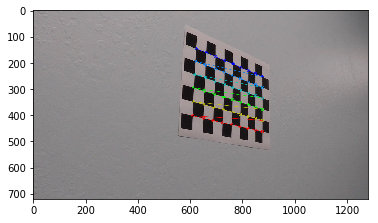

In [84]:
# camera calibration

# read in camera calibration images
cam_cal_imgs = glob.glob('./camera_cal/calibration*.jpg')

# prepare object points
nx = 9 # Chessboard size is 9x6
ny = 6 # Chessboard size is 9x6

obj_points = [] # object points
img_points = [] # image points

# prepare object points
objp = np.zeros((ny*nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for fname in cam_cal_imgs:

    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # append detected corners to the image points
        img_points.append(corners)
        obj_points.append(objp)
    
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)
        print('Successfully loaded {}'.format(fname))
    else:
        print('Could not find corners. Image name is {}'.format(fname))

        #cv2.destroyAllWindows()

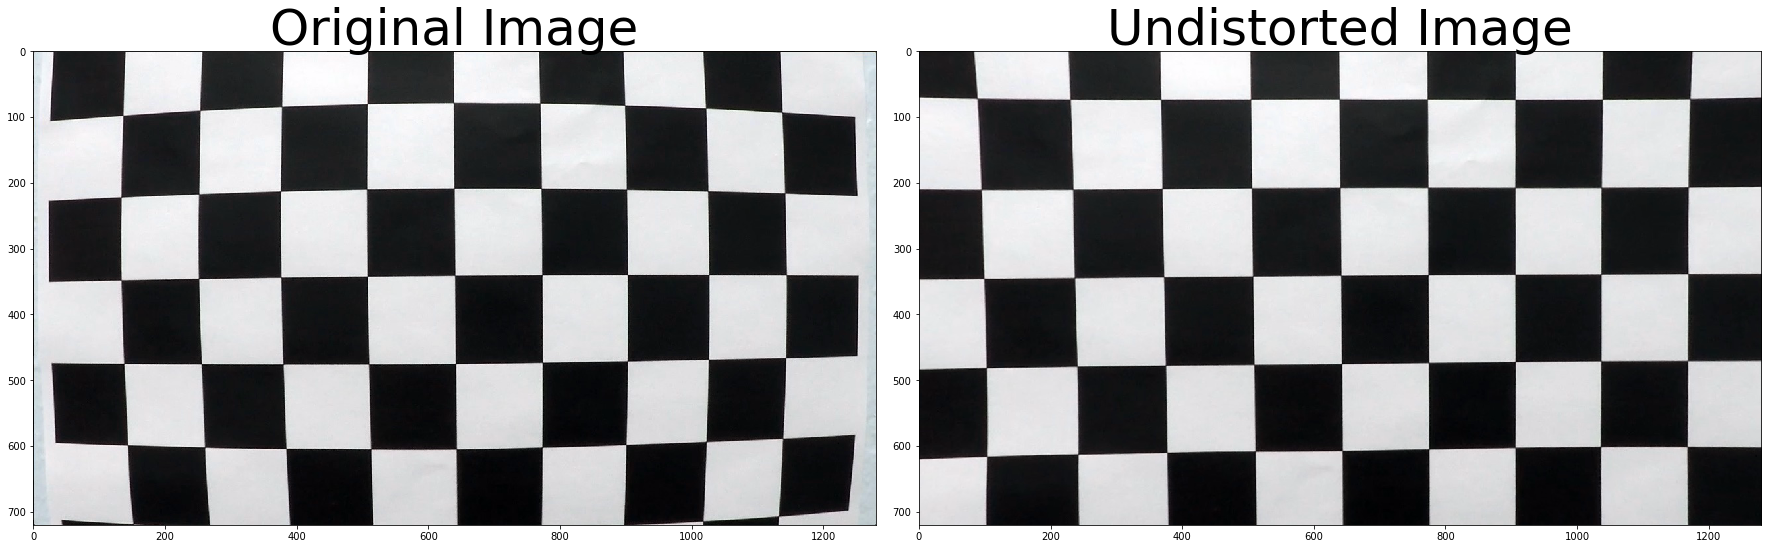

In [85]:
# use the first image as test image
img = cv2.imread(cam_cal_imgs[0])
shape = img.shape[0:2]

# perform camera calibration
# return value, camera calibration matrix, distortion coefficients, rotation and translation vectors
ret, cam_mat, dist_coeff, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, shape, None, None)

# undistort image
undistorted = cv2.undistort(img, cam_mat, dist_coeff)

# plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

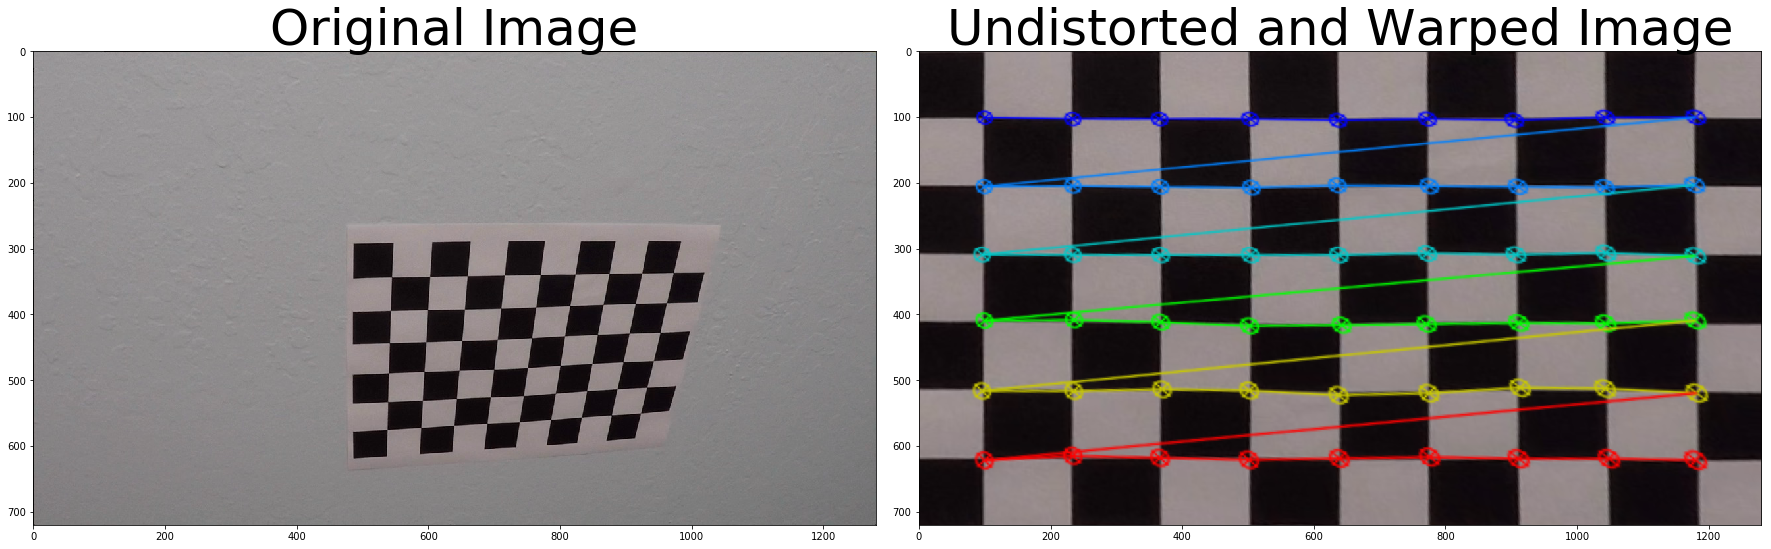

In [86]:
# unwarp images
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist)
    # 2) Convert to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny))
    # 4) If corners found: 
            # a) draw corners
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            # e) use cv2.warpPerspective() to warp your image to a top-down view
    if(ret):
        img_size = (gray.shape[::-1])
        offset = 100
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # dst = np.float32([[100, 100],[1100, 100],[1100, 900],[100, 900]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    else:
        M = None
        warped = np.copy(img) 
        print('Cannot unwarp image, returning the same image!')
    return warped, M

img = cv2.imread(cam_cal_imgs[1]) # choose a test image


top_down, perspective_M = corners_unwarp(img, nx, ny, cam_mat, dist_coeff)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Color and Gradient Threshold


In [87]:
# function definition

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if(orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif(orient == 'y'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(sobelx**2+sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    # 6) Return this mask as your binary_output image
    mag_binary[(scaled_sobel>=mag_thresh[0])&(scaled_sobel<=mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobel = np.sqrt(sobelx**2 + sobely **2)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(direction)
    
    # 6) Return this mask as your binary_output image
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return dir_binary

In [88]:

def combine_gradient_threshold(image):
    # Choose a Sobel kernel size
    ksize = 5 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(0, 63))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(128, 255))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.75, 1.25))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined[((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

def color_gradient_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

# Read in an image
image = mpimg.imread('../Lesson16AdvancedLaneFinding/signs_vehicles_xygrad.png')

combined = color_gradient_threshold(image)
mag_binary = mag_thresh(image, sobel_kernel=5, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=5, thresh=(0.75, 1.25))  

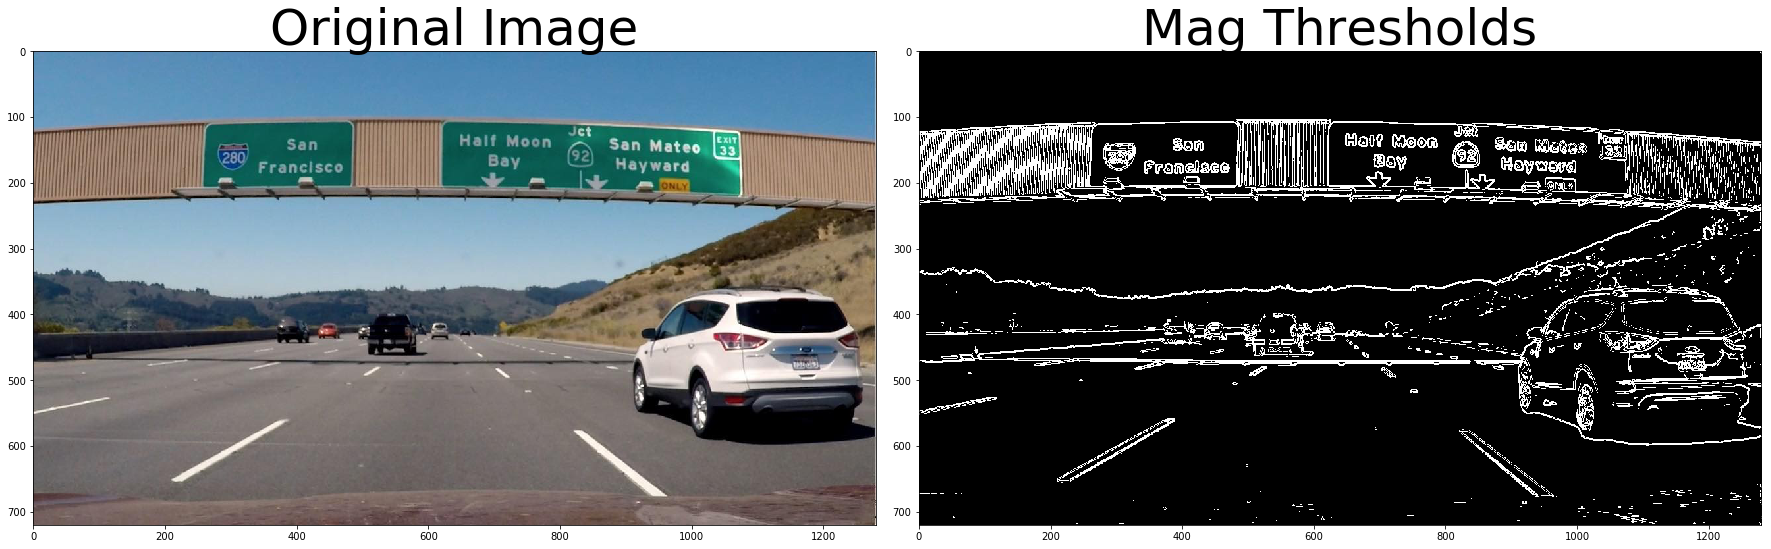

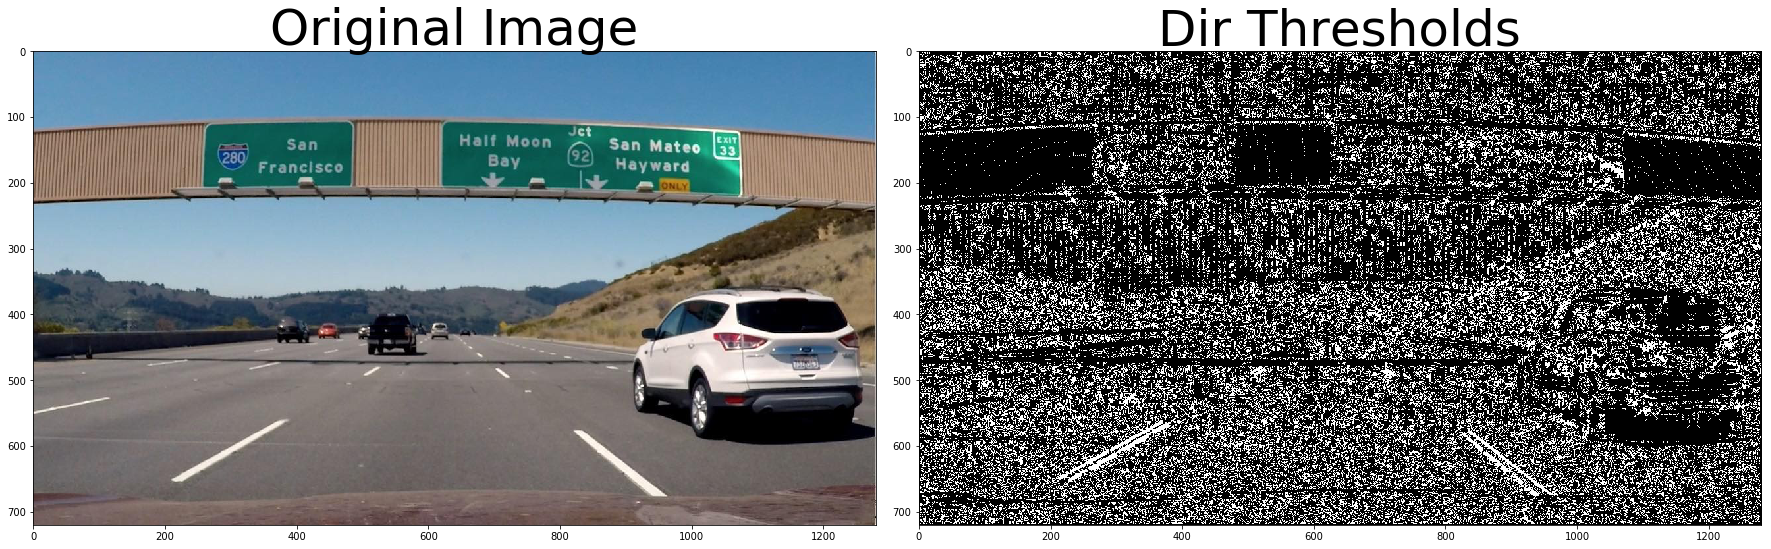

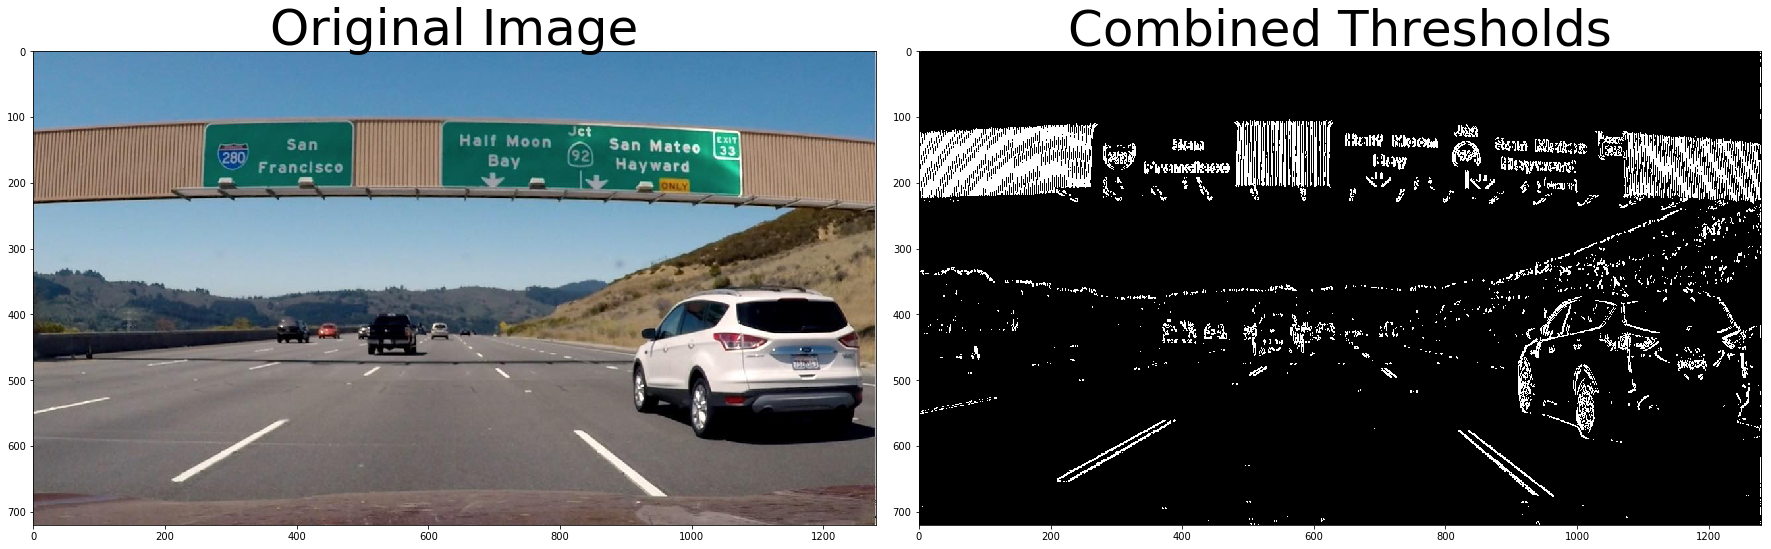

In [89]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Mag Thresholds', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Dir Thresholds', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined Thresholds', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig(save_path + 'color_grad_combined_thresh.png')

## Perspective Transform
warp the images using perspective transform

In [90]:
# perspective transform
perspective_test_img = ['./test_images/straight_lines1.jpg', './test_images/straight_lines2.jpg']
img = cv2.imread(perspective_test_img[0])
# hard coded src points
src = np.array([[595, 450], [210, 720], [1115, 720], [685, 450]], dtype = 'int32')

# hard codede destination points
dst = np.array([[320, 0], [320, 720], [960, 720], [960, 0]], dtype = 'int32')

# perspective transform matrix
M = cv2.getPerspectiveTransform(np.float32(src), np.float32(dst))
Minv = cv2.getPerspectiveTransform(np.float32(dst), np.float32(src))

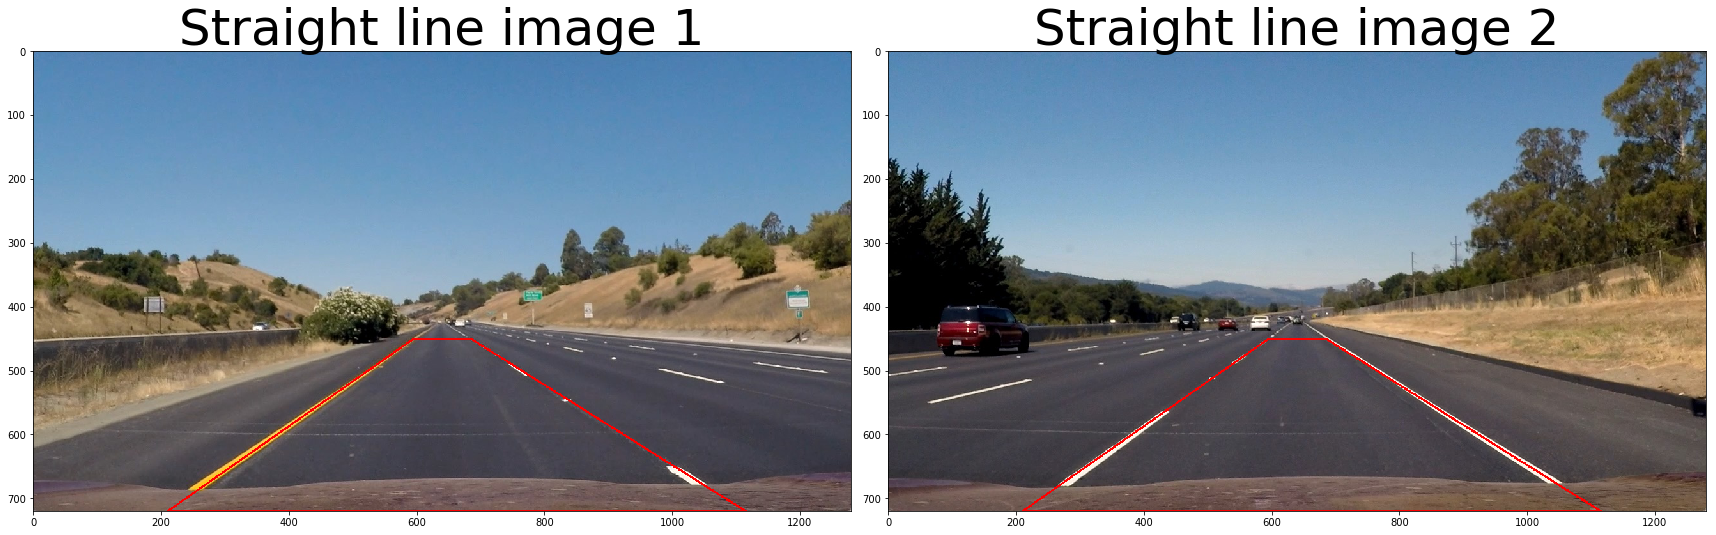

In [91]:
# visualize the polygon on two straight line images
img = cv2.imread(perspective_test_img[0])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
cv2.polylines(img, [src], True,(0,0,255), 2)
ax1.imshow((cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
ax1.set_title('Straight line image 1', fontsize=50)

img = cv2.imread(perspective_test_img[1])
f.tight_layout()
cv2.polylines(img, [src], True,(0,0,255), 2)
ax2.imshow((cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
ax2.set_title('Straight line image 2', fontsize=50)

plt.savefig(save_path + 'perspective_src_pnts.png')

In [92]:
# unwarp images

img = cv2.imread(perspective_test_img[0])
undist = cv2.undistort(img, cam_mat, dist_coeff)
img_size = (undist.shape[1], undist.shape[0])
top_down = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)


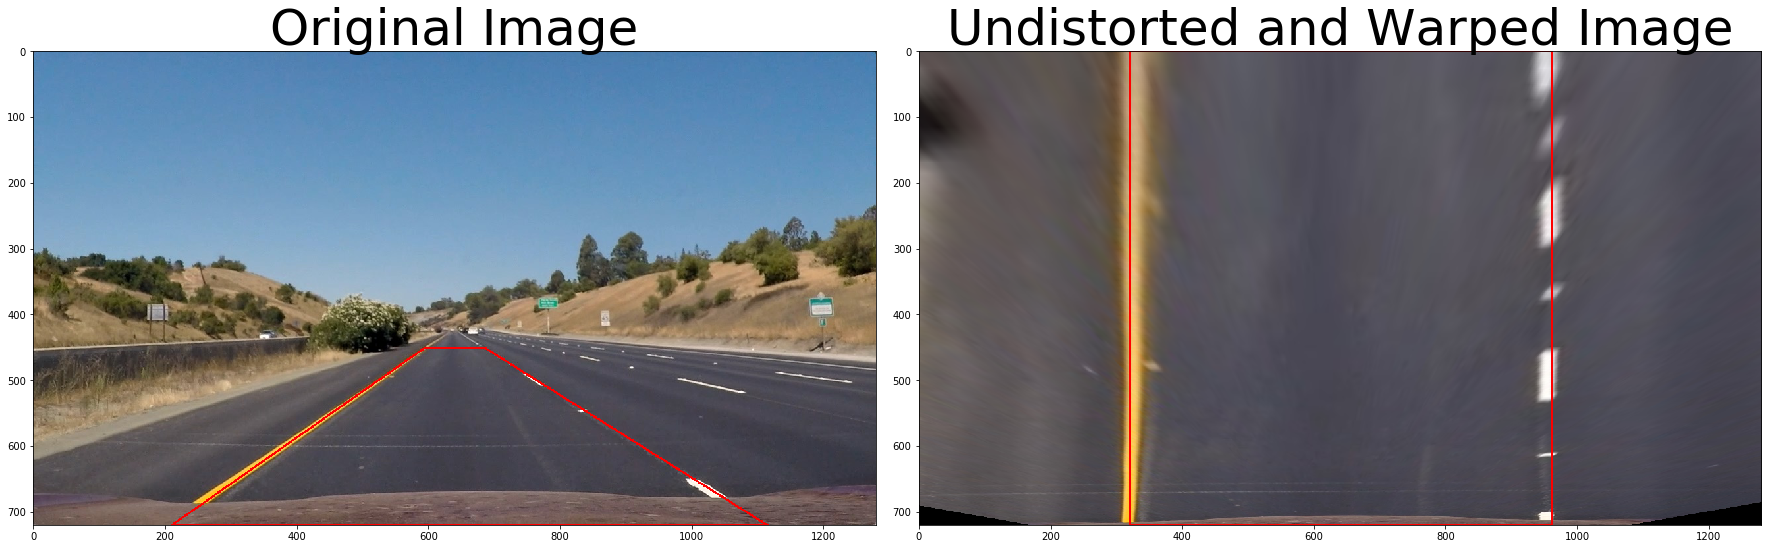

In [93]:
# plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
cv2.polylines(img, [src], True,(0,0,255), 2)
ax1.imshow((cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
ax1.set_title('Original Image', fontsize=50)

cv2.polylines(top_down, [dst], True,(0,0,255), 2)
ax2.imshow((cv2.cvtColor(top_down, cv2.COLOR_BGR2RGB)))
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig(save_path + 'perspective_transform_example')

## Finding the Lanes

In [94]:
## here are the steps

## 1. undistort image
# undistorted = cv2.undistort(img, cam_mat, dist_coeff)

## 2. color and gradient thresholding 
# combined = color_gradient_threshold(image)
# mag_binary = mag_thresh(image, sobel_kernel=5, mag_thresh=(30, 100))
# dir_binary = dir_threshold(image, sobel_kernel=5, thresh=(0.75, 1.25))  

## 3. unwarp the images
# top_down = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

def unwarp_image(img, cam_mat, dist_coeff, M):
    undistorted = cv2.undistort(img, cam_mat, dist_coeff)
    combined = color_gradient_threshold(undistorted)
    img_size = (img.shape[1], img.shape[0])
    top_down = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
    return top_down

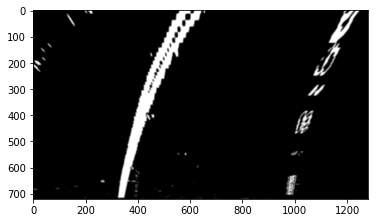

In [95]:

img = cv2.imread('./test_images/test3.jpg')
binary_warped = unwarp_image(img, cam_mat, dist_coeff, M)
plt.imshow(binary_warped, cmap = 'gray', interpolation = 'bicubic')

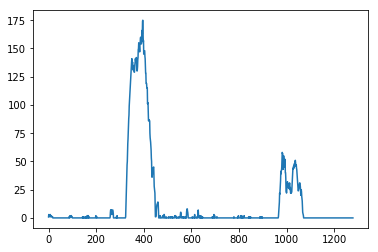

In [96]:
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

In [97]:
def sliding_window_test(binary_warped):
    overlay = True

    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if(overlay):
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
      
    if(overlay):
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        
    return out_img, leftx, lefty, rightx, righty

/Users/xingchihe/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


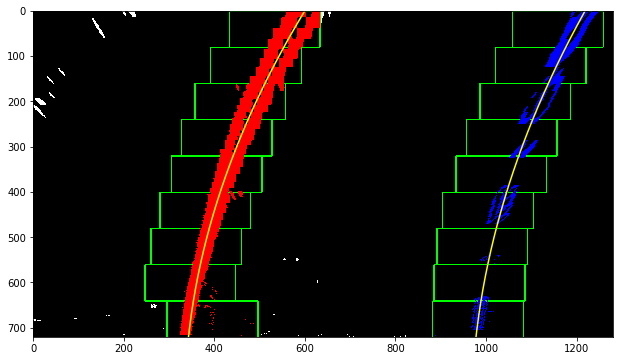

In [20]:
# visualization

out_img, leftx, lefty, rightx, righty = sliding_window_test(binary_warped)

    
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
    
    
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
   
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

#out_img[lefty, leftx] = [255, 0, 0]
#out_img[righty, rightx] = [0, 0, 255]

plt.figure(figsize=(16,6))
plt.imshow(np.uint8(out_img), vmin = 0, vmax=255)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig(save_path + 'sliding window')

## Skip the sliding windows step once you know where the lines are

In [21]:


# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]



(720, 0)

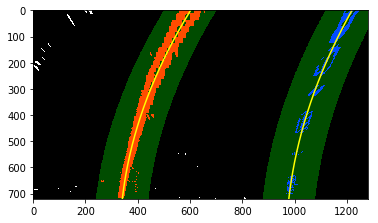

In [22]:
## visualize the result here as well
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(np.uint8(result))
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Sliding Window Search - using convolution

In [23]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

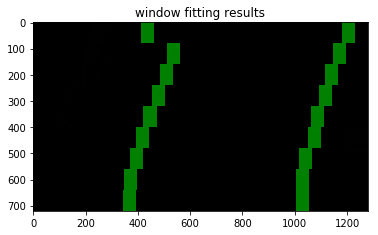

In [24]:
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

img = cv2.imread('./test_images/test6.jpg')
warped = unwarp_image(img, cam_mat, dist_coeff, M)

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows    
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(np.uint8(output))
plt.title('window fitting results')
plt.show()

[(370.0, 1030.0),
 (374.0, 1029.0),
 (395.0, 1040.0),
 (420.0, 1074.0),
 (447.0, 1088.0),
 (480.0, 1118.0),
 (511.0, 1142.0),
 (537.0, 1170.0),
 (437.0, 1206.0)]

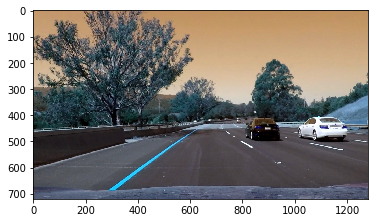

In [25]:
plt.imshow((img))
img.max()
window_centroids

## Measuring Curvature

In [26]:
def calc_curvature_meter(leftx, rightx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
  
    return left_curverad, right_curverad

  

In [27]:
def draw_lane(warped, undist, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    if((left_fitx is not None) and (right_fitx is not None)):
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        cv2.polylines(color_warp, np.int_(pts_left.reshape((-1,1,2))), True, (255, 0, 0), thickness = 50 )
        cv2.polylines(color_warp, np.int_(pts_right.reshape((-1,1,2))), True, (0, 0, 255), thickness = 50 )

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        
        result = cv2.addWeighted(np.dstack((warped*255, warped*255, warped*255)), 0.5, color_warp, 0.3, 0)
    
    else:
        result = undist
        result = np.dstack((warped*255, warped*255, warped*255))
    
    return result

In [28]:
def sliding_window(binary_warped):
 
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    return leftx, lefty, rightx, righty


def increment_window(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty

In [29]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        
        #y values for detected line pixels
        self.ally = None
        
        self.recent_fit = []
        
        self.cnt = 0
        
class CenterLine():
    def __init__(self):
    
        self.best_pos = None     
        self.best_curv = None  
        
        self.recent_pos = []
        self.recent_curv = []



In [30]:
lane_l = Line()
lane_r = Line()
center = CenterLine()

In [98]:
def polynomial_fit(x, y):
     # Fit a second order polynomial to each
    fit  = np.polyfit(y, x, 2)  
    fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    return fit, fitx

def calc_curv(x, y):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
   
    y_eval = np.max(y)
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    # Calculate the new radii of curvature
    curvature = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curvature
    
def process_lane(lane, x, y, ploty, img_center, n):
    max_curv_diff = 50
    curvature_min = 175
    curvature_max = 1400
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    fit, fitx  = polynomial_fit(x, y)  
    curvature = calc_curv(fitx, ploty)
      
    print('curvature : {}'.format(curvature))
    
    if(curvature > curvature_min):  #(curvature < curvature_max)):
            
        lane.cnt = 0 
        lane.detected = True
        lane.curvature = curvature
        print('curvature updated : {}'.format(curvature))
        
        #distance in meters of vehicle center from the line
        lane.line_base_pos = np.abs(img_center - fitx[-1]) * xm_per_pix
        
        if lane.bestx is None:
            lane.bestx = fitx;
            
        if(len(lane.bestx) == n):
            # x values of the last n fits of the line
            lane.recent_xfitted.pop(0)

            # recent polynomial fit
            lane.recent_fit.pop(0)     
        
        # x values of the last n fits of the line
        lane.recent_xfitted.append(fitx)
        
        # last n fits of the line
        lane.recent_fit.append(fit)
        
        #average x values of the fitted line over the last n iterations
        lane.bestx = np.mean(lane.recent_xfitted, axis=0) 
        
        #polynomial coefficients averaged over the last n iterations
        lane.best_fit = np.mean(lane.recent_fit, axis=0)   
    
        #difference in fit coefficients between last and new fits
        lane.diffs = lane.current_fit - fit
        
        #x values for detected line pixels
        lane.allx = x  
        #y values for detected line pixels
        lane.ally = y
        
        # Copy the polynomial fit
        lane.current_fit = fit
        
    else:
        print('curvature failed cnt: {}'.format(lane.cnt))
        lane.cnt = lane.cnt + 1
         # x values of the last n fits of the line
        lane.recent_xfitted.pop(0)
        
        # last n fits of the line
        lane.recent_fit.pop(0)
        
        #average x values of the fitted line over the last n iterations
        lane.bestx = np.mean(lane.recent_xfitted, axis=0) 
        
        #polynomial coefficients averaged over the last n iterations
        lane.best_fit = np.mean(lane.recent_fit, axis=0)   
    
        if lane.cnt > n:
            lane.detected = False
            
    return lane

In [99]:
def process_image(img):
    global lane_l 
    global lane_r
    global center
    
    # parameters
    n = 5 # avaerage over the past n frames
    img_center = img.shape[1]/2
  
    # parameters are cam_mat, dist_coeff, and M
    # undistort image
    undistorted = cv2.undistort(img, cam_mat, dist_coeff)
    # color and gradient thresholding
    combined = color_gradient_threshold(undistorted)
    img_size = (img.shape[1], img.shape[0])
    
    # perspective transform
    binary_warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)

    if(lane_l.detected & lane_r.detected):
        leftx, lefty, rightx, righty = increment_window(binary_warped, lane_l.best_fit, lane_r.best_fit)
    else:
        leftx, lefty, rightx, righty = sliding_window(binary_warped)
        
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        
    lane_l = process_lane(lane_l, leftx,  lefty,  ploty, img_center, n)
    lane_r = process_lane(lane_r, rightx, righty, ploty, img_center, n)
    
    if((lane_l.curvature is not None) and (lane_r.curvature is not None)):
        if(len(center.recent_curv)==n):
            center.recent_curv.pop(0)
        center.recent_curv.append(np.mean([lane_l.curvature, lane_r.curvature]))
        center.best_curv = np.mean(center.recent_curv, axis = 0)
    
    if((lane_l.line_base_pos is not None) and (lane_r.line_base_pos is not None)):
        if(len(center.recent_pos)==n):
            center.recent_pos.pop(0)
        center.recent_pos.append(np.mean([lane_l.line_base_pos, lane_r.line_base_pos]))
        center.best_pos = np.mean(center.recent_pos, axis = 0)
        
    out_img = draw_lane(binary_warped, undistorted, lane_l.bestx, lane_r.bestx, ploty)
    
    text_curv = 'Radius of Curvature is ' + str(center.best_curv) + ' (m)'
    text_pos  = 'Vehicle is ' + str(center.best_pos)  + ' m from the center'

    cv2.putText(out_img,  text_curv, (75, 75) , cv2.FONT_HERSHEY_SIMPLEX, 1.5, [255, 255, 255])
    cv2.putText(out_img,  text_pos,  (75, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, [255, 255, 255])
    
    return out_img

curvature : 400.54714985026874
curvature updated : 400.54714985026874
curvature : 422.1844357680675
curvature updated : 422.1844357680675


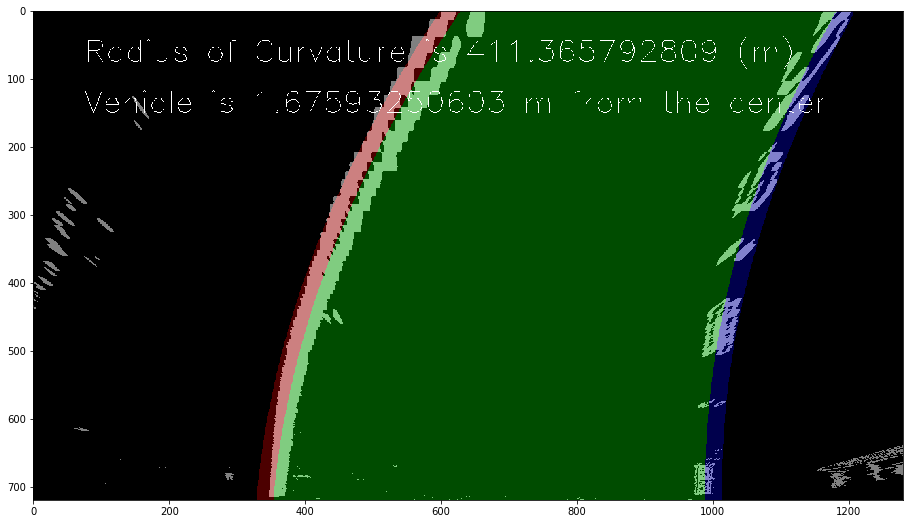

In [100]:
lane_l = Line()
lane_r = Line()
center = CenterLine()
test_results = process_image(frames[700,:,:,:])
plt.figure(figsize=(24,9))
plt.imshow(np.uint8(test_results))
#print('radius of curvature left {} and right {}' .format(lane_l.radius_of_curvature, lane_r.radius_of_curvature))

In [79]:
print(center.recent_curv)
print(lane_l.curvature)
print(lane_r.curvature)


[411.36579280916811]
400.54714985
422.184435768


curvature : 545.1064289294183
curvature updated : 545.1064289294183
curvature : 1507.451320248566
curvature updated : 1507.451320248566
curvature : 1466.385987597024
curvature updated : 1466.385987597024
curvature : 841.4857104059824
curvature updated : 841.4857104059824
curvature : 1013.5712338796541
curvature updated : 1013.5712338796541
curvature : 2432.739232792079
curvature updated : 2432.739232792079
curvature : 2632.811725844572
curvature updated : 2632.811725844572
curvature : 1658.176318925913
curvature updated : 1658.176318925913
curvature : 2968.872621511415
curvature updated : 2968.872621511415
curvature : 59938.714979208904
curvature updated : 59938.714979208904
curvature : 5038.04901142082
curvature updated : 5038.04901142082
curvature : 1110.9836823144535
curvature updated : 1110.9836823144535
curvature : 373.1225409101579
curvature updated : 373.1225409101579
curvature : 777.6081329922271
curvature updated : 777.6081329922271
curvature : 667.3171790059995
curvature upda

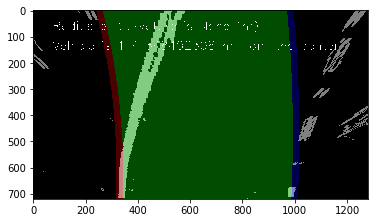

In [60]:
for k in range(250,1000,50):
    test_results = process_image(frames[k,:,:,:])
    plt.imshow(np.uint8(test_results))
    plt.savefig(str(k) + '.png')
#plt.imshow(np.uint8(test_results))
print('radius of curvature left {} and right {}' .format(lane_l.radius_of_curvature, lane_r.radius_of_curvature))

In [46]:
len(center.recent_curv) == 5

True

In [34]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import time
clip1 = VideoFileClip("project_video.mp4")
k = -1
t = 0
frame = []

while t < clip1.duration:
    k = k + 1
    frame.append(clip1.get_frame(t)) # gets the picture at time ``t``
    #imdisplay( picture )        # display the picture
    t = t + 1.0/25              # increment time
    #time.sleep( 1.0/25 ) 

In [35]:
frames = np.array(frame)

AttributeError: 'Line' object has no attribute 'pop'

In [82]:
if(True):
    lane_l = Line()
    lane_r = Line()
    project_video_output = 'project_video_output.mp4'
    clip1 = VideoFileClip("project_video.mp4")
    project_video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time project_video_clip.write_videofile(project_video_output, audio=False)

curvature : 396.7476451544936
curvature updated : 396.7476451544936
curvature : 734.5594789243233
curvature updated : 734.5594789243233
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

curvature : 402.9548982770407
curvature updated : 402.9548982770407
curvature : 734.7170259675047
curvature updated : 734.7170259675047


  0%|          | 1/1261 [00:00<03:36,  5.82it/s]

curvature : 389.87010527666183
curvature updated : 389.87010527666183
curvature : 601.6537003331471
curvature updated : 601.6537003331471


  0%|          | 2/1261 [00:00<03:36,  5.82it/s]

curvature : 389.179721308327
curvature updated : 389.179721308327
curvature : 646.262280124832
curvature updated : 646.262280124832


  0%|          | 3/1261 [00:00<03:44,  5.60it/s]

curvature : 398.5190979520447
curvature updated : 398.5190979520447
curvature : 575.2654065874262


  0%|          | 4/1261 [00:00<03:50,  5.45it/s]

curvature updated : 575.2654065874262
curvature : 427.3277596034715
curvature updated : 427.3277596034715
curvature : 457.277614513329
curvature updated : 457.277614513329


  0%|          | 6/1261 [00:01<03:32,  5.90it/s]

curvature : 401.07220011710075
curvature updated : 401.07220011710075
curvature : 399.8940146352436
curvature updated : 399.8940146352436


  1%|          | 7/1261 [00:01<03:29,  5.98it/s]

curvature : 431.8267051056021
curvature updated : 431.8267051056021
curvature : 399.1010716813539
curvature updated : 399.1010716813539
curvature : 459.9695782103081
curvature updated : 459.9695782103081
curvature : 456.59499412246265
curvature updated : 456.59499412246265


  1%|          | 8/1261 [00:01<03:38,  5.74it/s]

curvature : 526.1074906608947

  1%|          | 9/1261 [00:01<03:45,  5.55it/s]


curvature updated : 526.1074906608947
curvature : 595.5456180508511
curvature updated : 595.5456180508511
curvature : 486.7190912067633
curvature updated : 486.7190912067633
curvature : 684.6168933346194
curvature updated : 684.6168933346194


  1%|          | 11/1261 [00:01<03:54,  5.32it/s]

curvature : 504.5406407299954
curvature updated : 504.5406407299954
curvature : 863.888381073233
curvature updated : 863.888381073233
curvature : 548.1790960319555
curvature updated : 548.1790960319555
curvature : 895.3788887363021
curvature updated : 895.3788887363021


  1%|          | 13/1261 [00:02<04:03,  5.13it/s]

curvature : 544.8587821109786
curvature updated : 544.8587821109786
curvature : 1019.794319155175
curvature updated : 1019.794319155175
curvature : 545.3222440322995
curvature updated : 545.3222440322995
curvature : 565.967038251142
curvature updated : 565.967038251142


  1%|          | 15/1261 [00:02<03:56,  5.26it/s]

curvature : 495.62884876005097
curvature updated : 495.62884876005097
curvature : 580.0298795741478
curvature updated : 580.0298795741478
curvature : 476.3122664054313
curvature updated : 476.3122664054313
curvature : 411.8936031287235
curvature updated : 411.8936031287235


  1%|▏         | 17/1261 [00:03<03:54,  5.31it/s]

curvature : 483.81861971122794
curvature updated : 483.81861971122794
curvature : 379.1075967879615
curvature updated : 379.1075967879615
curvature : 516.2379818801887
curvature updated : 516.2379818801887
curvature : 407.35309121866345
curvature updated : 407.35309121866345


  2%|▏         | 19/1261 [00:03<03:50,  5.40it/s]

curvature : 534.6554124218239
curvature updated : 534.6554124218239
curvature : 366.85894777702686
curvature updated : 366.85894777702686
curvature : 500.41866725561306
curvature updated : 500.41866725561306
curvature : 356.11819370720474
curvature updated : 356.11819370720474


  2%|▏         | 21/1261 [00:03<03:48,  5.42it/s]

curvature : 531.2123193867817
curvature updated : 531.2123193867817
curvature : 380.2795109091448
curvature updated : 380.2795109091448
curvature : 575.0822886619977
curvature updated : 575.0822886619977
curvature : 389.96150540237375
curvature updated : 389.96150540237375


  2%|▏         | 23/1261 [00:04<03:46,  5.47it/s]

curvature : 556.5469285015186
curvature updated : 556.5469285015186
curvature : 416.7757445648344
curvature updated : 416.7757445648344
curvature : 553.003863062276
curvature updated : 553.003863062276
curvature : 494.0078421971988
curvature updated : 494.0078421971988


  2%|▏         | 25/1261 [00:04<03:46,  5.45it/s]

curvature : 483.3489042843846
curvature updated : 483.3489042843846
curvature : 750.2357078939666
curvature updated : 750.2357078939666


  2%|▏         | 26/1261 [00:04<04:18,  4.78it/s]

curvature : 511.71906407226766
curvature updated : 511.71906407226766
curvature : 830.6055410055707
curvature updated : 830.6055410055707


  2%|▏         | 27/1261 [00:05<04:19,  4.76it/s]

curvature : 440.22897345317296
curvature updated : 440.22897345317296
curvature : 776.8423511882692
curvature updated : 776.8423511882692
curvature : 464.04618890220206
curvature updated : 464.04618890220206
curvature : 696.6688377624432
curvature updated : 696.6688377624432


  2%|▏         | 29/1261 [00:05<04:01,  5.09it/s]

curvature : 438.18707846912696
curvature updated : 438.18707846912696
curvature : 518.156572446333
curvature updated : 518.156572446333


  2%|▏         | 30/1261 [00:05<04:13,  4.86it/s]

curvature : 389.68668173828263
curvature updated : 389.68668173828263
curvature : 571.4808971431364
curvature updated : 571.4808971431364


  2%|▏         | 31/1261 [00:05<04:15,  4.81it/s]

curvature : 390.21466782624145
curvature updated : 390.21466782624145
curvature : 323.1147899275129
curvature updated : 323.1147899275129
curvature : 348.25596597276444
curvature updated : 348.25596597276444
curvature : 314.37216601021544
curvature updated : 314.37216601021544


  3%|▎         | 33/1261 [00:06<04:30,  4.54it/s]

curvature : 343.0237802834667
curvature updated : 343.0237802834667
curvature : 297.8762261984313
curvature updated : 297.8762261984313
curvature : 319.28220474426496
curvature updated : 319.28220474426496


  3%|▎         | 34/1261 [00:06<04:19,  4.72it/s]

curvature : 382.01728226748895
curvature updated : 382.01728226748895
curvature : 316.4443529472998
curvature updated : 316.4443529472998
curvature : 461.0818492280777
curvature updated : 461.0818492280777


  3%|▎         | 36/1261 [00:06<04:04,  5.01it/s]

curvature : 317.5529967478978
curvature updated : 317.5529967478978
curvature : 493.91250757764016
curvature updated : 493.91250757764016


  3%|▎         | 37/1261 [00:07<04:08,  4.93it/s]

curvature : 307.11987017160595
curvature updated : 307.11987017160595
curvature : 420.14200568972825
curvature updated : 420.14200568972825
curvature : 291.4081137954509
curvature updated : 291.4081137954509


  3%|▎         | 38/1261 [00:07<04:08,  4.91it/s]

curvature : 380.58341212937546
curvature updated : 380.58341212937546


  3%|▎         | 39/1261 [00:07<04:15,  4.78it/s]

curvature : 299.44361647708587
curvature updated : 299.44361647708587
curvature : 419.23162566059335
curvature updated : 419.23162566059335
curvature : 319.20477787057763
curvature updated : 319.20477787057763
curvature : 354.9208501147474
curvature updated : 354.9208501147474


  3%|▎         | 41/1261 [00:07<03:55,  5.17it/s]

curvature : 333.7630075601224
curvature updated : 333.7630075601224
curvature : 345.86366955212617
curvature updated : 345.86366955212617
curvature : 332.7141064838653
curvature updated : 332.7141064838653
curvature : 332.02008134016137
curvature updated : 332.02008134016137


  3%|▎         | 43/1261 [00:08<03:49,  5.30it/s]

curvature : 370.3458758946594
curvature updated : 370.3458758946594
curvature : 321.8782028398506
curvature updated : 321.8782028398506
curvature : 368.8099192109589
curvature updated : 368.8099192109589
curvature : 299.61601683234016
curvature updated : 299.61601683234016


  4%|▎         | 45/1261 [00:08<03:50,  5.27it/s]

curvature : 386.5145069301716
curvature updated : 386.5145069301716
curvature : 303.9086019914928
curvature updated : 303.9086019914928
curvature : 408.8997662230776
curvature updated : 408.8997662230776


  4%|▎         | 46/1261 [00:08<03:55,  5.15it/s]

curvature : 328.8100626941771
curvature updated : 328.8100626941771


  4%|▎         | 47/1261 [00:09<04:17,  4.71it/s]

curvature : 406.18056652255274
curvature updated : 406.18056652255274
curvature : 405.3172327943929
curvature updated : 405.3172327943929


  4%|▍         | 48/1261 [00:09<04:10,  4.83it/s]

curvature : 437.1225796092384
curvature updated : 437.1225796092384
curvature : 486.9890172530939
curvature updated : 486.9890172530939
curvature : 457.803055092422
curvature updated : 457.803055092422
curvature : 498.39729564590823
curvature updated : 498.39729564590823


  4%|▍         | 50/1261 [00:09<03:55,  5.14it/s]

curvature : 501.68844999545126
curvature updated : 501.68844999545126
curvature : 463.563462217178
curvature updated : 463.563462217178
curvature : 518.6415302876655
curvature updated : 518.6415302876655


  4%|▍         | 51/1261 [00:09<03:57,  5.10it/s]

curvature : 475.8664054784225
curvature updated : 475.8664054784225
curvature : 505.93891786687146
curvature updated : 505.93891786687146


  4%|▍         | 52/1261 [00:10<04:01,  5.00it/s]

curvature : 483.28891052666614
curvature updated : 483.28891052666614
curvature : 500.90728453803234
curvature updated : 500.90728453803234
curvature : 422.89277891637033
curvature updated : 422.89277891637033


  4%|▍         | 54/1261 [00:10<03:53,  5.18it/s]

curvature : 495.6348805999425
curvature updated : 495.6348805999425
curvature : 363.05741472691176
curvature updated : 363.05741472691176
curvature : 515.3469112133355
curvature updated : 515.3469112133355
curvature : 369.7357269681715
curvature updated : 369.7357269681715


  4%|▍         | 56/1261 [00:10<03:48,  5.27it/s]

curvature : 525.6935437917463
curvature updated : 525.6935437917463
curvature : 360.68355395163485
curvature updated : 360.68355395163485
curvature : 497.7284335883219
curvature updated : 497.7284335883219
curvature : 381.976838330419
curvature updated : 381.976838330419


  5%|▍         | 58/1261 [00:11<03:48,  5.26it/s]

curvature : 516.1130535461871
curvature updated : 516.1130535461871
curvature : 434.7390212651963
curvature updated : 434.7390212651963
curvature : 492.5132010519658
curvature updated : 492.5132010519658
curvature : 631.4801602029563
curvature updated : 631.4801602029563


  5%|▍         | 60/1261 [00:11<04:06,  4.87it/s]

curvature : 458.4450318806339
curvature updated : 458.4450318806339
curvature : 493.36920103359404
curvature updated : 493.36920103359404
curvature : 488.8725262364758
curvature updated : 488.8725262364758
curvature : 488.7529014602267
curvature updated : 488.7529014602267


  5%|▍         | 62/1261 [00:11<03:52,  5.16it/s]

curvature : 485.5715659735027
curvature updated : 485.5715659735027
curvature : 452.742847758091
curvature updated : 452.742847758091


  5%|▍         | 63/1261 [00:12<04:22,  4.56it/s]

curvature : 512.7315103088588
curvature updated : 512.7315103088588
curvature : 404.01568415251154
curvature updated : 404.01568415251154
curvature : 516.4781396983514
curvature updated : 516.4781396983514


  5%|▌         | 64/1261 [00:12<04:17,  4.65it/s]

curvature : 375.3736973281467
curvature updated : 375.3736973281467


  5%|▌         | 65/1261 [00:12<04:35,  4.34it/s]

curvature : 506.4730604612632
curvature updated : 506.4730604612632
curvature : 333.52422353931973
curvature updated : 333.52422353931973


  5%|▌         | 66/1261 [00:13<04:45,  4.19it/s]

curvature : 492.8275761646108
curvature updated : 492.8275761646108
curvature : 380.669075519733
curvature updated : 380.669075519733


  5%|▌         | 67/1261 [00:13<04:50,  4.11it/s]

curvature : 520.8894545011995
curvature updated : 520.8894545011995
curvature : 400.29599762085115
curvature updated : 400.29599762085115


  5%|▌         | 68/1261 [00:13<04:35,  4.33it/s]

curvature : 526.8046064094018
curvature updated : 526.8046064094018
curvature : 427.92399819155685
curvature updated : 427.92399819155685


  5%|▌         | 69/1261 [00:13<04:38,  4.28it/s]

curvature : 527.0298735945684
curvature updated : 527.0298735945684
curvature : 405.7940090140248
curvature updated : 405.7940090140248


  6%|▌         | 70/1261 [00:13<04:27,  4.46it/s]

curvature : 558.8762517244761
curvature updated : 558.8762517244761
curvature : 452.25560388612325
curvature updated : 452.25560388612325
curvature : 546.0778626922679
curvature updated : 546.0778626922679
curvature : 425.0357357844991
curvature updated : 425.0357357844991


  6%|▌         | 72/1261 [00:14<04:11,  4.72it/s]

curvature : 579.5869471891612
curvature updated : 579.5869471891612
curvature : 446.29689064033795
curvature updated : 446.29689064033795


  6%|▌         | 73/1261 [00:14<04:12,  4.70it/s]

curvature : 580.5468833111075
curvature updated : 580.5468833111075
curvature : 422.50183679964385
curvature updated : 422.50183679964385


  6%|▌         | 74/1261 [00:14<04:15,  4.65it/s]

curvature : 593.7639579817851
curvature updated : 593.7639579817851
curvature : 417.33677052865
curvature updated : 417.33677052865


  6%|▌         | 75/1261 [00:14<04:18,  4.59it/s]

curvature : 644.0745626867264
curvature updated : 644.0745626867264
curvature : 416.16163676047137
curvature updated : 416.16163676047137


  6%|▌         | 76/1261 [00:15<04:15,  4.64it/s]

curvature : 602.7636711499703
curvature updated : 602.7636711499703
curvature : 386.1254995184268
curvature updated : 386.1254995184268


  6%|▌         | 77/1261 [00:15<04:23,  4.50it/s]

curvature : 633.6177095210182
curvature updated : 633.6177095210182
curvature : 441.19576353214313
curvature updated : 441.19576353214313


  6%|▌         | 78/1261 [00:15<04:15,  4.62it/s]

curvature : 664.2072449300418
curvature updated : 664.2072449300418
curvature : 455.1046588687396
curvature updated : 455.1046588687396
curvature : 701.8244753448872
curvature updated : 701.8244753448872
curvature : 440.799140752049
curvature updated : 440.799140752049


  6%|▋         | 80/1261 [00:15<03:54,  5.03it/s]

curvature : 647.7173461659945
curvature updated : 647.7173461659945
curvature : 394.38848590035695
curvature updated : 394.38848590035695
curvature : 610.1284151919274
curvature updated : 610.1284151919274
curvature : 345.18024954657307
curvature updated : 345.18024954657307


  7%|▋         | 82/1261 [00:16<03:42,  5.30it/s]

curvature : 626.8741217024586
curvature updated : 626.8741217024586
curvature : 344.3936670261445
curvature updated : 344.3936670261445
curvature : 584.9727886593063
curvature updated : 584.9727886593063
curvature : 360.44216177236166
curvature updated : 360.44216177236166


  7%|▋         | 84/1261 [00:16<03:34,  5.47it/s]

curvature : 598.7213357469938
curvature updated : 598.7213357469938
curvature : 343.81754516931676
curvature updated : 343.81754516931676
curvature : 554.7066892393078
curvature updated : 554.7066892393078
curvature : 411.3419934422233
curvature updated : 411.3419934422233


  7%|▋         | 86/1261 [00:17<03:33,  5.51it/s]

curvature : 530.1568069553147
curvature updated : 530.1568069553147
curvature : 477.89236065088323
curvature updated : 477.89236065088323
curvature : 457.280103908334
curvature updated : 457.280103908334
curvature : 509.36505345198907
curvature updated : 509.36505345198907


  7%|▋         | 88/1261 [00:17<03:31,  5.55it/s]

curvature : 426.81133159538507
curvature updated : 426.81133159538507
curvature : 459.1023809874328
curvature updated : 459.1023809874328
curvature : 404.82494785580815
curvature updated : 404.82494785580815
curvature : 422.1557208513095
curvature updated : 422.1557208513095


  7%|▋         | 90/1261 [00:17<03:31,  5.54it/s]

curvature : 378.5626293332929
curvature updated : 378.5626293332929
curvature : 311.0233312839897
curvature updated : 311.0233312839897
curvature : 380.7466519562412
curvature updated : 380.7466519562412
curvature : 346.8975983375733
curvature updated : 346.8975983375733


  7%|▋         | 92/1261 [00:18<03:32,  5.50it/s]

curvature : 394.6421567785323
curvature updated : 394.6421567785323
curvature : 347.39795596642995
curvature updated : 347.39795596642995
curvature : 389.63002490591606
curvature updated : 389.63002490591606
curvature : 365.35862795773375
curvature updated : 365.35862795773375


  7%|▋         | 94/1261 [00:18<03:30,  5.55it/s]

curvature : 380.7110646769597
curvature updated : 380.7110646769597
curvature : 403.3668909839668
curvature updated : 403.3668909839668
curvature : 410.0738097300033
curvature updated : 410.0738097300033


  8%|▊         | 95/1261 [00:18<03:40,  5.28it/s]

curvature : 413.03390686264413
curvature updated : 413.03390686264413
curvature : 395.29089161108885
curvature updated : 395.29089161108885
curvature : 420.0495269920164
curvature updated : 420.0495269920164


  8%|▊         | 97/1261 [00:19<03:31,  5.49it/s]

curvature : 392.5235379258201
curvature updated : 392.5235379258201
curvature : 443.45586321645646
curvature updated : 443.45586321645646
curvature : 408.50736763189536
curvature updated : 408.50736763189536
curvature : 440.79744613785186
curvature updated : 440.79744613785186


  8%|▊         | 99/1261 [00:19<03:28,  5.58it/s]

curvature : 395.0228163559632
curvature updated : 395.0228163559632
curvature : 371.9110937230016
curvature updated : 371.9110937230016
curvature : 402.7043868028681
curvature updated : 402.7043868028681
curvature : 381.6839135147913
curvature updated : 381.6839135147913


  8%|▊         | 101/1261 [00:19<03:25,  5.65it/s]

curvature : 377.347910895693
curvature updated : 377.347910895693
curvature : 410.15055643191903
curvature updated : 410.15055643191903
curvature : 372.0355535558333
curvature updated : 372.0355535558333
curvature : 313.5578409519731
curvature updated : 313.5578409519731


  8%|▊         | 103/1261 [00:20<03:23,  5.70it/s]

curvature : 380.4339039362028
curvature updated : 380.4339039362028
curvature : 297.7606120615457
curvature updated : 297.7606120615457
curvature : 391.89523207701166
curvature updated : 391.89523207701166
curvature : 299.6300526571827
curvature updated : 299.6300526571827


  8%|▊         | 105/1261 [00:20<03:25,  5.63it/s]

curvature : 414.4016126294416
curvature updated : 414.4016126294416
curvature : 300.7612243662982
curvature updated : 300.7612243662982
curvature : 395.2590410490678
curvature updated : 395.2590410490678
curvature : 307.93164588454795
curvature updated : 307.93164588454795


  8%|▊         | 107/1261 [00:20<03:22,  5.69it/s]

curvature : 423.0749854052919
curvature updated : 423.0749854052919
curvature : 312.35668648235844
curvature updated : 312.35668648235844
curvature : 399.9979438753083
curvature updated : 399.9979438753083
curvature : 281.06291220893917
curvature updated : 281.06291220893917


  9%|▊         | 109/1261 [00:21<03:21,  5.71it/s]

curvature : 400.20735567064366
curvature updated : 400.20735567064366
curvature : 307.55593094016774
curvature updated : 307.55593094016774
curvature : 400.54720670101983
curvature updated : 400.54720670101983
curvature : 358.08408256258224
curvature updated : 358.08408256258224


  9%|▉         | 111/1261 [00:21<03:21,  5.70it/s]

curvature : 382.7852837998392
curvature updated : 382.7852837998392
curvature : 436.1584466184473
curvature updated : 436.1584466184473
curvature : 405.5119945068363
curvature updated : 405.5119945068363
curvature : 431.4976582325767
curvature updated : 431.4976582325767


  9%|▉         | 113/1261 [00:21<03:21,  5.70it/s]

curvature : 365.9419843250898
curvature updated : 365.9419843250898
curvature : 344.77653709017255
curvature updated : 344.77653709017255
curvature : 377.14372252642966
curvature updated : 377.14372252642966
curvature : 366.4231810932078
curvature updated : 366.4231810932078


  9%|▉         | 115/1261 [00:22<03:26,  5.56it/s]

curvature : 354.75291976346887
curvature updated : 354.75291976346887
curvature : 335.7513862716717
curvature updated : 335.7513862716717
curvature : 356.5463435368774
curvature updated : 356.5463435368774
curvature : 282.63639384747864
curvature updated : 282.63639384747864


  9%|▉         | 117/1261 [00:22<03:22,  5.66it/s]

curvature : 348.67951686347413
curvature updated : 348.67951686347413
curvature : 279.6542425544874
curvature updated : 279.6542425544874
curvature : 350.0189603627121
curvature updated : 350.0189603627121
curvature : 276.79344507789614
curvature updated : 276.79344507789614


  9%|▉         | 119/1261 [00:22<03:27,  5.51it/s]

curvature : 351.58689501912613
curvature updated : 351.58689501912613
curvature : 306.74348021367916
curvature updated : 306.74348021367916
curvature : 332.80299150167593
curvature updated : 332.80299150167593


 10%|▉         | 120/1261 [00:23<03:32,  5.38it/s]

curvature : 343.1254322824971
curvature updated : 343.1254322824971
curvature : 344.9681273089927
curvature updated : 344.9681273089927
curvature : 409.77142035983576
curvature updated : 409.77142035983576


 10%|▉         | 122/1261 [00:23<03:26,  5.52it/s]

curvature : 343.6759568756949
curvature updated : 343.6759568756949
curvature : 402.045000604274
curvature updated : 402.045000604274
curvature : 336.14292244411416
curvature updated : 336.14292244411416
curvature : 356.0276689175779
curvature updated : 356.0276689175779


 10%|▉         | 124/1261 [00:23<03:24,  5.56it/s]

curvature : 339.47141638404037
curvature updated : 339.47141638404037
curvature : 316.01201421797845
curvature updated : 316.01201421797845
curvature : 341.20126770388316
curvature updated : 341.20126770388316
curvature : 279.8210848303477
curvature updated : 279.8210848303477


 10%|▉         | 126/1261 [00:24<03:23,  5.58it/s]

curvature : 368.7343601286635
curvature updated : 368.7343601286635
curvature : 342.9860648685687
curvature updated : 342.9860648685687
curvature : 367.16969941378386
curvature updated : 367.16969941378386
curvature : 297.4121737700654
curvature updated : 297.4121737700654


 10%|█         | 128/1261 [00:24<03:21,  5.62it/s]

curvature : 380.74802138629434
curvature updated : 380.74802138629434
curvature : 298.42781866404937
curvature updated : 298.42781866404937
curvature : 372.9599287600459
curvature updated : 372.9599287600459
curvature : 336.6674053300178
curvature updated : 336.6674053300178


 10%|█         | 130/1261 [00:24<03:29,  5.39it/s]

curvature : 395.8307641175754
curvature updated : 395.8307641175754
curvature : 346.50651013762047
curvature updated : 346.50651013762047
curvature : 399.72983884429635
curvature updated : 399.72983884429635
curvature : 372.12652174296204
curvature updated : 372.12652174296204


 10%|█         | 132/1261 [00:25<03:24,  5.51it/s]

curvature : 390.27456161074736
curvature updated : 390.27456161074736
curvature : 400.7121107173887
curvature updated : 400.7121107173887
curvature : 412.1617289729786
curvature updated : 412.1617289729786
curvature : 457.45562278813617
curvature updated : 457.45562278813617


 11%|█         | 134/1261 [00:25<03:23,  5.53it/s]

curvature : 420.7109244421999
curvature updated : 420.7109244421999
curvature : 418.93355570025733
curvature updated : 418.93355570025733
curvature : 446.5004344732219
curvature updated : 446.5004344732219
curvature : 467.73758860307646
curvature updated : 467.73758860307646


 11%|█         | 136/1261 [00:26<03:21,  5.59it/s]

curvature : 479.2176948654813
curvature updated : 479.2176948654813
curvature : 450.9255112800468
curvature updated : 450.9255112800468
curvature : 460.9454516414294
curvature updated : 460.9454516414294
curvature : 503.8557645955945
curvature updated : 503.8557645955945


 11%|█         | 138/1261 [00:26<03:22,  5.54it/s]

curvature : 482.6781187073702
curvature updated : 482.6781187073702
curvature : 499.14550647637543
curvature updated : 499.14550647637543
curvature : 486.23718633488375
curvature updated : 486.23718633488375


 11%|█         | 139/1261 [00:26<03:28,  5.38it/s]

curvature : 513.2307646215233
curvature updated : 513.2307646215233
curvature : 521.874025852102
curvature updated : 521.874025852102
curvature : 591.3585170638443
curvature updated : 591.3585170638443


 11%|█         | 141/1261 [00:26<03:25,  5.44it/s]

curvature : 558.5743856331787
curvature updated : 558.5743856331787
curvature : 486.1317244588832
curvature updated : 486.1317244588832
curvature : 556.1913396840304
curvature updated : 556.1913396840304
curvature : 444.8316278303707
curvature updated : 444.8316278303707


 11%|█▏        | 143/1261 [00:27<03:22,  5.52it/s]

curvature : 525.3420544122354
curvature updated : 525.3420544122354
curvature : 372.4089257315953
curvature updated : 372.4089257315953
curvature : 527.487785439462
curvature updated : 527.487785439462
curvature : 417.89438577764724
curvature updated : 417.89438577764724


 11%|█▏        | 145/1261 [00:27<03:23,  5.48it/s]

curvature : 526.4224158549476
curvature updated : 526.4224158549476
curvature : 429.5105553248746
curvature updated : 429.5105553248746


 12%|█▏        | 146/1261 [00:27<03:44,  4.97it/s]

curvature : 494.71812317574023
curvature updated : 494.71812317574023
curvature : 548.9916747950338
curvature updated : 548.9916747950338


 12%|█▏        | 147/1261 [00:28<04:00,  4.63it/s]

curvature : 524.3121310126736
curvature updated : 524.3121310126736
curvature : 547.5641684542044
curvature updated : 547.5641684542044


 12%|█▏        | 148/1261 [00:28<04:00,  4.64it/s]

curvature : 458.54490684860076
curvature updated : 458.54490684860076
curvature : 400.4271430669383
curvature updated : 400.4271430669383
curvature : 455.54845477216924
curvature updated : 455.54845477216924
curvature : 341.99597280291516
curvature updated : 341.99597280291516


 12%|█▏        | 150/1261 [00:28<03:47,  4.89it/s]

curvature : 450.8048614350643
curvature updated : 450.8048614350643
curvature : 396.59454674658946
curvature updated : 396.59454674658946
curvature : 472.49544732597093

 12%|█▏        | 151/1261 [00:28<03:45,  4.93it/s]


curvature updated : 472.49544732597093
curvature : 434.4345798809687
curvature updated : 434.4345798809687
curvature : 466.6911817658087
curvature updated : 466.6911817658087


 12%|█▏        | 152/1261 [00:29<03:44,  4.94it/s]

curvature : 396.1933773113413
curvature updated : 396.1933773113413
curvature : 456.22371976042535
curvature updated : 456.22371976042535
curvature : 322.7612458338678
curvature updated : 322.7612458338678


 12%|█▏        | 154/1261 [00:29<03:33,  5.17it/s]

curvature : 479.56998158047065
curvature updated : 479.56998158047065
curvature : 357.9050292873128
curvature updated : 357.9050292873128
curvature : 485.42860101053094
curvature updated : 485.42860101053094
curvature : 359.33914956919017
curvature updated : 359.33914956919017


 12%|█▏        | 156/1261 [00:29<03:35,  5.12it/s]

curvature : 480.20859210139383
curvature updated : 480.20859210139383
curvature : 365.3437273291904
curvature updated : 365.3437273291904


 12%|█▏        | 157/1261 [00:30<03:54,  4.72it/s]

curvature : 455.4057959443157
curvature updated : 455.4057959443157
curvature : 384.75512935118627
curvature updated : 384.75512935118627
curvature : 449.6941200167703
curvature updated : 449.6941200167703
curvature : 448.98007236997273
curvature updated : 448.98007236997273


 13%|█▎        | 159/1261 [00:30<03:42,  4.96it/s]

curvature : 429.6991650637108
curvature updated : 429.6991650637108
curvature : 437.65233319463886
curvature updated : 437.65233319463886


 13%|█▎        | 160/1261 [00:30<03:59,  4.59it/s]

curvature : 406.2515349573984
curvature updated : 406.2515349573984
curvature : 359.6388171427878
curvature updated : 359.6388171427878
curvature : 426.6492102322385
curvature updated : 426.6492102322385


 13%|█▎        | 161/1261 [00:31<03:50,  4.77it/s]

curvature : 449.28665319315803
curvature updated : 449.28665319315803
curvature : 452.84353289431283
curvature updated : 452.84353289431283
curvature : 404.4323443453544
curvature updated : 404.4323443453544


 13%|█▎        | 163/1261 [00:31<03:48,  4.81it/s]

curvature : 427.0941489584395
curvature updated : 427.0941489584395
curvature : 458.05724765716576
curvature updated : 458.05724765716576


 13%|█▎        | 164/1261 [00:31<04:15,  4.30it/s]

curvature : 427.18629777392266
curvature updated : 427.18629777392266
curvature : 328.8734147273613
curvature updated : 328.8734147273613


 13%|█▎        | 165/1261 [00:31<04:28,  4.08it/s]

curvature : 398.5325429913038
curvature updated : 398.5325429913038
curvature : 249.97943141134195
curvature updated : 249.97943141134195
curvature : 409.4651040960004
curvature updated : 409.4651040960004
curvature : 255.81631358538627
curvature updated : 255.81631358538627


 13%|█▎        | 167/1261 [00:32<03:55,  4.65it/s]

curvature : 380.3762016467989
curvature updated : 380.3762016467989
curvature : 275.4153054974964
curvature updated : 275.4153054974964
curvature : 430.77935065017607
curvature updated : 430.77935065017607
curvature : 269.4685718273429
curvature updated : 269.4685718273429


 13%|█▎        | 169/1261 [00:32<03:56,  4.61it/s]

curvature : 430.3423655980746
curvature updated : 430.3423655980746
curvature : 272.60431139224903
curvature updated : 272.60431139224903


 13%|█▎        | 170/1261 [00:33<03:58,  4.58it/s]

curvature : 458.62751547025005
curvature updated : 458.62751547025005
curvature : 272.07766729735175
curvature updated : 272.07766729735175


 14%|█▎        | 171/1261 [00:33<03:59,  4.54it/s]

curvature : 454.2694913454481
curvature updated : 454.2694913454481
curvature : 263.69038971664287
curvature updated : 263.69038971664287


 14%|█▎        | 172/1261 [00:33<03:59,  4.55it/s]

curvature : 423.79298298455916
curvature updated : 423.79298298455916
curvature : 258.8250751537306
curvature updated : 258.8250751537306


 14%|█▎        | 173/1261 [00:33<03:53,  4.66it/s]

curvature : 401.7653355028469
curvature updated : 401.7653355028469
curvature : 255.48106296703273
curvature updated : 255.48106296703273
curvature : 369.1423553188598
curvature updated : 369.1423553188598
curvature : 261.45882051034033
curvature updated : 261.45882051034033


 14%|█▍        | 175/1261 [00:34<03:40,  4.93it/s]

curvature : 349.8527666816623
curvature updated : 349.8527666816623
curvature : 269.48963360807636
curvature updated : 269.48963360807636


 14%|█▍        | 176/1261 [00:34<03:41,  4.89it/s]

curvature : 323.5602177049067
curvature updated : 323.5602177049067
curvature : 273.73490681025305
curvature updated : 273.73490681025305
curvature : 353.9614695608691
curvature updated : 353.9614695608691
curvature : 265.84920009041804
curvature updated : 265.84920009041804


 14%|█▍        | 178/1261 [00:34<03:32,  5.11it/s]

curvature : 353.0470110914271
curvature updated : 353.0470110914271
curvature : 243.98617410366342
curvature updated : 243.98617410366342


 14%|█▍        | 179/1261 [00:34<03:51,  4.68it/s]

curvature : 350.7074844689849
curvature updated : 350.7074844689849
curvature : 249.12698750451204
curvature updated : 249.12698750451204


 14%|█▍        | 180/1261 [00:35<04:02,  4.45it/s]

curvature : 359.67406141102316
curvature updated : 359.67406141102316
curvature : 248.6813256210603
curvature updated : 248.6813256210603


 14%|█▍        | 181/1261 [00:35<03:59,  4.51it/s]

curvature : 344.8384735011413
curvature updated : 344.8384735011413
curvature : 282.8319447845348
curvature updated : 282.8319447845348


 14%|█▍        | 182/1261 [00:35<03:58,  4.53it/s]

curvature : 337.28701573404896
curvature updated : 337.28701573404896
curvature : 294.48810219205126
curvature updated : 294.48810219205126
curvature : 322.08578158749407
curvature updated : 322.08578158749407


 15%|█▍        | 183/1261 [00:35<03:50,  4.68it/s]

curvature : 337.2240120587753
curvature updated : 337.2240120587753
curvature : 301.3090982048495
curvature updated : 301.3090982048495
curvature : 335.1376126847662
curvature updated : 335.1376126847662


 15%|█▍        | 185/1261 [00:36<03:33,  5.03it/s]

curvature : 287.8647654548157
curvature updated : 287.8647654548157
curvature : 370.3071141875861
curvature updated : 370.3071141875861
curvature : 252.1224265833518
curvature updated : 252.1224265833518
curvature : 362.4638869184586
curvature updated : 362.4638869184586


 15%|█▍        | 187/1261 [00:36<03:26,  5.20it/s]

curvature : 252.43240579023103
curvature updated : 252.43240579023103
curvature : 383.4959577331265
curvature updated : 383.4959577331265
curvature : 247.2172231626384
curvature updated : 247.2172231626384
curvature : 383.5227839361586
curvature updated : 383.5227839361586


 15%|█▍        | 189/1261 [00:36<03:22,  5.30it/s]

curvature : 256.0852746951724
curvature updated : 256.0852746951724
curvature : 405.31606412032556
curvature updated : 405.31606412032556
curvature : 261.0011526217764
curvature updated : 261.0011526217764
curvature : 392.27644172372675
curvature updated : 392.27644172372675


 15%|█▌        | 191/1261 [00:37<03:30,  5.09it/s]

curvature : 259.4428526656728
curvature updated : 259.4428526656728
curvature : 378.3894123147329
curvature updated : 378.3894123147329
curvature : 271.7506563678904
curvature updated : 271.7506563678904
curvature : 388.82278887404374
curvature updated : 388.82278887404374


 15%|█▌        | 193/1261 [00:37<03:25,  5.19it/s]

curvature : 266.96376234200375
curvature updated : 266.96376234200375
curvature : 368.49388792741945
curvature updated : 368.49388792741945
curvature : 276.6855165934433
curvature updated : 276.6855165934433
curvature : 382.1239986162704
curvature updated : 382.1239986162704


 15%|█▌        | 195/1261 [00:38<03:21,  5.29it/s]

curvature : 291.36925860300727
curvature updated : 291.36925860300727
curvature : 371.1561792388491
curvature updated : 371.1561792388491
curvature : 346.47747996224854
curvature updated : 346.47747996224854
curvature : 346.229364635657
curvature updated : 346.229364635657


 16%|█▌        | 197/1261 [00:38<03:22,  5.26it/s]

curvature : 408.71039588743287
curvature updated : 408.71039588743287
curvature : 461.79652207882907
curvature updated : 461.79652207882907
curvature : 463.2451895465861
curvature updated : 463.2451895465861
curvature : 392.9507906118448
curvature updated : 392.9507906118448


 16%|█▌        | 199/1261 [00:38<03:22,  5.26it/s]

curvature : 484.96302388852877
curvature updated : 484.96302388852877
curvature : 370.5797760368552
curvature updated : 370.5797760368552
curvature : 471.7866772503017
curvature updated : 471.7866772503017


 16%|█▌        | 200/1261 [00:38<03:27,  5.11it/s]

curvature : 459.81626382078827
curvature updated : 459.81626382078827


 16%|█▌        | 201/1261 [00:39<03:31,  5.02it/s]

curvature : 480.330151217269
curvature updated : 480.330151217269
curvature : 502.6744954442145
curvature updated : 502.6744954442145
curvature : 462.84229087444766
curvature updated : 462.84229087444766
curvature : 445.310198095628

 16%|█▌        | 202/1261 [00:39<03:29,  5.05it/s]


curvature updated : 445.310198095628
curvature : 435.8638918308048
curvature updated : 435.8638918308048


 16%|█▌        | 203/1261 [00:39<03:30,  5.03it/s]

curvature : 430.25084926153943
curvature updated : 430.25084926153943
curvature : 426.35535419252585
curvature updated : 426.35535419252585


 16%|█▌        | 204/1261 [00:39<03:35,  4.90it/s]

curvature : 405.7981849370324
curvature updated : 405.7981849370324
curvature : 408.9295045110647
curvature updated : 408.9295045110647
curvature : 326.1672354186475
curvature updated : 326.1672354186475


 16%|█▋        | 206/1261 [00:40<03:33,  4.94it/s]

curvature : 388.4011101544567
curvature updated : 388.4011101544567
curvature : 324.349048686776
curvature updated : 324.349048686776
curvature : 350.0175318022778
curvature updated : 350.0175318022778
curvature : 443.2847420264967
curvature updated : 443.2847420264967


 16%|█▋        | 208/1261 [00:40<03:27,  5.06it/s]

curvature : 337.07889987444753
curvature updated : 337.07889987444753
curvature : 467.32476266146546
curvature updated : 467.32476266146546
curvature : 364.4651042410767
curvature updated : 364.4651042410767
curvature : 465.4368427766116
curvature updated : 465.4368427766116


 17%|█▋        | 210/1261 [00:40<03:22,  5.20it/s]

curvature : 372.08120450165205
curvature updated : 372.08120450165205
curvature : 572.3761607617615
curvature updated : 572.3761607617615
curvature : 385.72012294354425
curvature updated : 385.72012294354425


 17%|█▋        | 211/1261 [00:41<03:23,  5.16it/s]

curvature : 593.8369418673992
curvature updated : 593.8369418673992
curvature : 374.06412208094383
curvature updated : 374.06412208094383
curvature : 537.8244903614515
curvature updated : 537.8244903614515


 17%|█▋        | 213/1261 [00:41<03:23,  5.15it/s]

curvature : 381.6761849216947
curvature updated : 381.6761849216947
curvature : 578.6850654333587
curvature updated : 578.6850654333587
curvature : 378.1440327985854
curvature updated : 378.1440327985854
curvature : 608.0389929768457
curvature updated : 608.0389929768457


 17%|█▋        | 215/1261 [00:41<03:28,  5.02it/s]

curvature : 379.96345855756124
curvature updated : 379.96345855756124
curvature : 434.8515614769197
curvature updated : 434.8515614769197
curvature : 389.2480748937564
curvature updated : 389.2480748937564


 17%|█▋        | 216/1261 [00:42<03:27,  5.03it/s]

curvature : 393.8540508216974
curvature updated : 393.8540508216974
curvature : 402.7874734579185
curvature updated : 402.7874734579185
curvature : 359.73153912182323
curvature updated : 359.73153912182323


 17%|█▋        | 218/1261 [00:42<03:24,  5.10it/s]

curvature : 425.2942311807265
curvature updated : 425.2942311807265
curvature : 364.06558233798387
curvature updated : 364.06558233798387
curvature : 413.4357870888679
curvature updated : 413.4357870888679
curvature : 432.8146411250117
curvature updated : 432.8146411250117


 17%|█▋        | 220/1261 [00:42<03:19,  5.23it/s]

curvature : 461.2943044359975
curvature updated : 461.2943044359975
curvature : 402.3626635071696
curvature updated : 402.3626635071696
curvature : 450.4782151038864
curvature updated : 450.4782151038864


 18%|█▊        | 221/1261 [00:43<03:20,  5.18it/s]

curvature : 445.49821605315833
curvature updated : 445.49821605315833
curvature : 472.92815252651934
curvature updated : 472.92815252651934
curvature : 532.9622730093236
curvature updated : 532.9622730093236


 18%|█▊        | 223/1261 [00:43<03:20,  5.17it/s]

curvature : 477.24539061308576
curvature updated : 477.24539061308576
curvature : 550.3617038109525
curvature updated : 550.3617038109525
curvature : 461.6997703174776
curvature updated : 461.6997703174776
curvature : 432.9297982419458

 18%|█▊        | 225/1261 [00:43<03:17,  5.25it/s]


curvature updated : 432.9297982419458
curvature : 470.1577706884525
curvature updated : 470.1577706884525
curvature : 428.20037082109917
curvature updated : 428.20037082109917
curvature : 468.87060730813465
curvature updated : 468.87060730813465


 18%|█▊        | 226/1261 [00:44<03:19,  5.19it/s]

curvature : 349.4732670936024
curvature updated : 349.4732670936024
curvature : 486.56383268343257
curvature updated : 486.56383268343257
curvature : 303.69374057859926
curvature updated : 303.69374057859926


 18%|█▊        | 228/1261 [00:44<03:20,  5.15it/s]

curvature : 509.2311614538689
curvature updated : 509.2311614538689
curvature : 314.8072766959337
curvature updated : 314.8072766959337
curvature : 509.35882801388715
curvature updated : 509.35882801388715
curvature : 307.0596201077125

 18%|█▊        | 230/1261 [00:44<03:16,  5.25it/s]


curvature updated : 307.0596201077125
curvature : 538.1669661912945
curvature updated : 538.1669661912945
curvature : 301.67652128775194
curvature updated : 301.67652128775194
curvature : 502.5264109870475
curvature updated : 502.5264109870475


 18%|█▊        | 231/1261 [00:45<03:17,  5.21it/s]

curvature : 310.75807571162477
curvature updated : 310.75807571162477
curvature : 526.8800983720758
curvature updated : 526.8800983720758
curvature : 302.90371026709545
curvature updated : 302.90371026709545


 18%|█▊        | 233/1261 [00:45<03:20,  5.12it/s]

curvature : 507.1779220488805
curvature updated : 507.1779220488805
curvature : 321.799807433494
curvature updated : 321.799807433494
curvature : 499.32748370353664
curvature updated : 499.32748370353664


 19%|█▊        | 234/1261 [00:45<03:19,  5.15it/s]

curvature : 354.73701033147233
curvature updated : 354.73701033147233
curvature : 480.6417206070481
curvature updated : 480.6417206070481
curvature : 347.4084209709942
curvature updated : 347.4084209709942


 19%|█▊        | 236/1261 [00:46<03:18,  5.17it/s]

curvature : 459.592815600059
curvature updated : 459.592815600059
curvature : 330.18161456180906
curvature updated : 330.18161456180906


 19%|█▉        | 237/1261 [00:46<03:31,  4.84it/s]

curvature : 442.9467856291704
curvature updated : 442.9467856291704
curvature : 316.32604864760975
curvature updated : 316.32604864760975


 19%|█▉        | 238/1261 [00:46<03:28,  4.92it/s]

curvature : 418.4618558098676
curvature updated : 418.4618558098676
curvature : 313.36693172121704
curvature updated : 313.36693172121704
curvature : 398.1880742234932
curvature updated : 398.1880742234932
curvature : 329.54327656711
curvature updated : 329.54327656711


 19%|█▉        | 240/1261 [00:46<03:17,  5.18it/s]

curvature : 405.967584949717
curvature updated : 405.967584949717
curvature : 334.7311462964405
curvature updated : 334.7311462964405
curvature : 412.6119979407416
curvature updated : 412.6119979407416
curvature : 341.306841831941
curvature updated : 341.306841831941


 19%|█▉        | 242/1261 [00:47<03:13,  5.26it/s]

curvature : 427.0785288060765
curvature updated : 427.0785288060765
curvature : 319.4735891438642
curvature updated : 319.4735891438642
curvature : 389.22008523377497
curvature updated : 389.22008523377497
curvature : 355.00394657860085
curvature updated : 355.00394657860085


 19%|█▉        | 244/1261 [00:47<03:10,  5.34it/s]

curvature : 409.85587425772553
curvature updated : 409.85587425772553
curvature : 360.9250554593792
curvature updated : 360.9250554593792
curvature : 392.2342089330103
curvature updated : 392.2342089330103
curvature : 366.5936063342581
curvature updated : 366.5936063342581


 20%|█▉        | 246/1261 [00:47<03:08,  5.39it/s]

curvature : 385.71735897394365
curvature updated : 385.71735897394365
curvature : 363.0130454629994
curvature updated : 363.0130454629994
curvature : 391.78647140635485
curvature updated : 391.78647140635485
curvature : 355.91854276346186
curvature updated : 355.91854276346186


 20%|█▉        | 248/1261 [00:48<03:14,  5.22it/s]

curvature : 381.3364907151489
curvature updated : 381.3364907151489
curvature : 333.93244895142743
curvature updated : 333.93244895142743
curvature : 407.55334917814406
curvature updated : 407.55334917814406
curvature : 339.11332190945245
curvature updated : 339.11332190945245


 20%|█▉        | 250/1261 [00:48<03:09,  5.33it/s]

curvature : 407.5884805120814
curvature updated : 407.5884805120814
curvature : 344.06302365195614
curvature updated : 344.06302365195614
curvature : 426.98549519111975
curvature updated : 426.98549519111975
curvature : 336.42845337134275
curvature updated : 336.42845337134275


 20%|█▉        | 252/1261 [00:49<03:08,  5.37it/s]

curvature : 440.5610770695519
curvature updated : 440.5610770695519
curvature : 307.16116823267635
curvature updated : 307.16116823267635
curvature : 431.6468682102684
curvature updated : 431.6468682102684
curvature : 332.0741765864644
curvature updated : 332.0741765864644


 20%|██        | 254/1261 [00:49<03:09,  5.32it/s]

curvature : 460.0757558724103
curvature updated : 460.0757558724103
curvature : 339.5578292311731
curvature updated : 339.5578292311731
curvature : 449.38618610745493
curvature updated : 449.38618610745493
curvature : 324.90752812584526
curvature updated : 324.90752812584526


 20%|██        | 256/1261 [00:49<03:11,  5.26it/s]

curvature : 445.1924798597692
curvature updated : 445.1924798597692
curvature : 348.59957356784395
curvature updated : 348.59957356784395


 20%|██        | 257/1261 [00:50<03:31,  4.74it/s]

curvature : 431.36621421050745
curvature updated : 431.36621421050745
curvature : 322.2360726346474
curvature updated : 322.2360726346474


 20%|██        | 258/1261 [00:50<03:26,  4.86it/s]

curvature : 426.3052128269385
curvature updated : 426.3052128269385
curvature : 290.17180660890926
curvature updated : 290.17180660890926
curvature : 429.54692155025737
curvature updated : 429.54692155025737
curvature : 267.70217437590793

 21%|██        | 260/1261 [00:50<03:19,  5.02it/s]


curvature updated : 267.70217437590793
curvature : 421.7429115085742
curvature updated : 421.7429115085742
curvature : 256.04329859883296
curvature updated : 256.04329859883296
curvature : 468.7414113136065
curvature updated : 468.7414113136065
curvature : 305.4002358923061
curvature updated : 305.4002358923061


 21%|██        | 262/1261 [00:51<03:14,  5.13it/s]

curvature : 455.49438033025035
curvature updated : 455.49438033025035
curvature : 290.0098918120181
curvature updated : 290.0098918120181
curvature : 455.55125237336017
curvature updated : 455.55125237336017
curvature : 298.83533280448154
curvature updated : 298.83533280448154


 21%|██        | 264/1261 [00:51<02:57,  5.62it/s]

curvature : 471.5480673637005
curvature updated : 471.5480673637005
curvature : 319.1607734988611
curvature updated : 319.1607734988611
curvature : 464.27146781841327
curvature updated : 464.27146781841327
curvature : 334.23481486310095
curvature updated : 334.23481486310095


 21%|██        | 266/1261 [00:51<02:51,  5.79it/s]

curvature : 481.85189455372034
curvature updated : 481.85189455372034
curvature : 365.20541953357315
curvature updated : 365.20541953357315
curvature : 467.51176141084716
curvature updated : 467.51176141084716
curvature : 400.7562481873115
curvature updated : 400.7562481873115


 21%|██▏       | 268/1261 [00:52<02:45,  6.01it/s]

curvature : 474.7470601084692
curvature updated : 474.7470601084692
curvature : 445.55514488256176
curvature updated : 445.55514488256176
curvature : 511.6280597891325
curvature updated : 511.6280597891325
curvature : 465.8631062250939
curvature updated : 465.8631062250939


 21%|██▏       | 270/1261 [00:52<02:59,  5.51it/s]

curvature : 503.9568857802348
curvature updated : 503.9568857802348
curvature : 544.5844787352703
curvature updated : 544.5844787352703
curvature : 517.178587170716
curvature updated : 517.178587170716
curvature : 556.1877976441225
curvature updated : 556.1877976441225


 22%|██▏       | 272/1261 [00:52<03:02,  5.42it/s]

curvature : 502.9607366754468
curvature updated : 502.9607366754468
curvature : 449.6119409108337
curvature updated : 449.6119409108337
curvature : 535.0516902876399
curvature updated : 535.0516902876399
curvature : 363.72762245334576
curvature updated : 363.72762245334576


 22%|██▏       | 274/1261 [00:53<03:02,  5.40it/s]

curvature : 520.6149194536415
curvature updated : 520.6149194536415
curvature : 378.4138658676751
curvature updated : 378.4138658676751
curvature : 537.2632998730738
curvature updated : 537.2632998730738
curvature : 415.99136509576874
curvature updated : 415.99136509576874


 22%|██▏       | 276/1261 [00:53<03:03,  5.36it/s]

curvature : 582.2608664845757
curvature updated : 582.2608664845757
curvature : 419.56391848909163
curvature updated : 419.56391848909163
curvature : 613.355462887094
curvature updated : 613.355462887094
curvature : 431.0401146718945
curvature updated : 431.0401146718945


 22%|██▏       | 278/1261 [00:53<03:03,  5.36it/s]

curvature : 630.4465166137121
curvature updated : 630.4465166137121
curvature : 453.52168686495673
curvature updated : 453.52168686495673
curvature : 668.2606097879024
curvature updated : 668.2606097879024
curvature : 520.4520580283709
curvature updated : 520.4520580283709


 22%|██▏       | 280/1261 [00:54<03:03,  5.35it/s]

curvature : 641.0189120571938
curvature updated : 641.0189120571938
curvature : 555.6303272234846
curvature updated : 555.6303272234846
curvature : 720.4303211319113
curvature updated : 720.4303211319113
curvature : 567.7836357745414
curvature updated : 567.7836357745414


 22%|██▏       | 282/1261 [00:54<03:02,  5.35it/s]

curvature : 656.4509039858631
curvature updated : 656.4509039858631
curvature : 519.1256338830106
curvature updated : 519.1256338830106
curvature : 714.5785300814514
curvature updated : 714.5785300814514
curvature : 551.4483019554298
curvature updated : 551.4483019554298


 23%|██▎       | 284/1261 [00:55<03:05,  5.27it/s]

curvature : 646.2224513971536
curvature updated : 646.2224513971536
curvature : 448.9377556488233
curvature updated : 448.9377556488233
curvature : 706.0042227396185
curvature updated : 706.0042227396185
curvature : 492.1348727889798
curvature updated : 492.1348727889798


 23%|██▎       | 286/1261 [00:55<03:02,  5.35it/s]

curvature : 743.1646321801406
curvature updated : 743.1646321801406
curvature : 453.3501366953574
curvature updated : 453.3501366953574
curvature : 692.5949747262739
curvature updated : 692.5949747262739
curvature : 415.59118071161106
curvature updated : 415.59118071161106


 23%|██▎       | 288/1261 [00:55<02:58,  5.45it/s]

curvature : 719.8682503702913
curvature updated : 719.8682503702913
curvature : 400.3177061198272
curvature updated : 400.3177061198272
curvature : 634.8422683946845
curvature updated : 634.8422683946845
curvature : 410.61813703774163
curvature updated : 410.61813703774163


 23%|██▎       | 290/1261 [00:56<02:58,  5.45it/s]

curvature : 671.5534201417113
curvature updated : 671.5534201417113
curvature : 413.0912467593969
curvature updated : 413.0912467593969
curvature : 596.8571680612482
curvature updated : 596.8571680612482
curvature : 467.4239717965429
curvature updated : 467.4239717965429


 23%|██▎       | 292/1261 [00:56<02:58,  5.44it/s]

curvature : 590.5303770665488
curvature updated : 590.5303770665488
curvature : 489.0222711880113
curvature updated : 489.0222711880113
curvature : 606.2898887834652
curvature updated : 606.2898887834652
curvature : 437.56369465944624
curvature updated : 437.56369465944624


 23%|██▎       | 294/1261 [00:56<02:56,  5.48it/s]

curvature : 602.3473943478909
curvature updated : 602.3473943478909
curvature : 484.8627922292172
curvature updated : 484.8627922292172
curvature : 590.9696216080476
curvature updated : 590.9696216080476
curvature : 492.5534378634861
curvature updated : 492.5534378634861


 23%|██▎       | 296/1261 [00:57<02:56,  5.48it/s]

curvature : 608.6282535492991
curvature updated : 608.6282535492991
curvature : 516.157760804497
curvature updated : 516.157760804497
curvature : 623.049879239357
curvature updated : 623.049879239357
curvature : 522.5919518910273
curvature updated : 522.5919518910273


 24%|██▎       | 298/1261 [00:57<03:02,  5.28it/s]

curvature : 666.201275172015
curvature updated : 666.201275172015
curvature : 506.7372504378397
curvature updated : 506.7372504378397
curvature : 690.3050282459062
curvature updated : 690.3050282459062
curvature : 529.2751620598443
curvature updated : 529.2751620598443


 24%|██▍       | 301/1261 [00:58<02:44,  5.85it/s]

curvature : 751.5327847227807
curvature updated : 751.5327847227807
curvature : 542.6959251317567
curvature updated : 542.6959251317567
curvature : 743.8139048791119
curvature updated : 743.8139048791119
curvature : 571.7972481430666
curvature updated : 571.7972481430666


 24%|██▍       | 303/1261 [00:58<02:33,  6.22it/s]

curvature : 869.6251433769834
curvature updated : 869.6251433769834
curvature : 542.4355478740807
curvature updated : 542.4355478740807
curvature : 811.3887360430289
curvature updated : 811.3887360430289
curvature : 575.770894152873
curvature updated : 575.770894152873


 24%|██▍       | 305/1261 [00:58<02:30,  6.35it/s]

curvature : 828.3669954884772
curvature updated : 828.3669954884772
curvature : 545.6590939722772
curvature updated : 545.6590939722772
curvature : 892.3411296689085
curvature updated : 892.3411296689085
curvature : 506.239729845291
curvature updated : 506.239729845291


 24%|██▍       | 307/1261 [00:59<02:29,  6.39it/s]

curvature : 868.8385188740316
curvature updated : 868.8385188740316
curvature : 673.1328323374212
curvature updated : 673.1328323374212
curvature : 937.233108541896
curvature updated : 937.233108541896
curvature : 579.2663294101112
curvature updated : 579.2663294101112


 25%|██▍       | 309/1261 [00:59<02:28,  6.39it/s]

curvature : 793.6470119300152
curvature updated : 793.6470119300152
curvature : 645.4867146932318
curvature updated : 645.4867146932318
curvature : 868.2204245266372
curvature updated : 868.2204245266372
curvature : 672.7926836290106
curvature updated : 672.7926836290106


 25%|██▍       | 311/1261 [00:59<02:28,  6.38it/s]

curvature : 850.3730521689113
curvature updated : 850.3730521689113
curvature : 632.7175130943632
curvature updated : 632.7175130943632
curvature : 845.0651864770541
curvature updated : 845.0651864770541
curvature : 690.4090103028493
curvature updated : 690.4090103028493


 25%|██▍       | 313/1261 [00:59<02:29,  6.36it/s]

curvature : 916.0386180059148
curvature updated : 916.0386180059148
curvature : 725.588851717046
curvature updated : 725.588851717046
curvature : 869.96572425887
curvature updated : 869.96572425887
curvature : 688.9168601985687
curvature updated : 688.9168601985687


 25%|██▍       | 314/1261 [01:00<02:38,  5.97it/s]

curvature : 1012.5754667331639
curvature updated : 1012.5754667331639
curvature : 752.0377389062782
curvature updated : 752.0377389062782
curvature : 952.1289023464327
curvature updated : 952.1289023464327
curvature : 662.7543042447918

 25%|██▌       | 316/1261 [01:00<02:51,  5.52it/s]


curvature updated : 662.7543042447918
curvature : 1155.5446503427006
curvature updated : 1155.5446503427006
curvature : 594.0951592732679
curvature updated : 594.0951592732679
curvature : 1191.5709965044557
curvature updated : 1191.5709965044557


 25%|██▌       | 317/1261 [01:00<02:55,  5.38it/s]

curvature : 343.74688190081986
curvature updated : 343.74688190081986
curvature : 1049.145128593226
curvature updated : 1049.145128593226
curvature : 402.21433319462494
curvature updated : 402.21433319462494


 25%|██▌       | 319/1261 [01:01<02:56,  5.34it/s]

curvature : 1164.5875086654898
curvature updated : 1164.5875086654898
curvature : 382.30468613984607
curvature updated : 382.30468613984607
curvature : 1171.0722259443016
curvature updated : 1171.0722259443016
curvature : 440.25720347578425
curvature updated : 440.25720347578425


 25%|██▌       | 321/1261 [01:01<02:55,  5.37it/s]

curvature : 1178.4991719609657
curvature updated : 1178.4991719609657
curvature : 457.36626483367434
curvature updated : 457.36626483367434
curvature : 1510.432525503576
curvature updated : 1510.432525503576
curvature : 459.65729341075695
curvature updated : 459.65729341075695


 26%|██▌       | 323/1261 [01:01<02:56,  5.31it/s]

curvature : 1436.6617645902818
curvature updated : 1436.6617645902818
curvature : 509.5339997954875
curvature updated : 509.5339997954875
curvature : 1607.2079744816335
curvature updated : 1607.2079744816335
curvature : 454.42841794815985
curvature updated : 454.42841794815985


 26%|██▌       | 325/1261 [01:02<02:54,  5.35it/s]

curvature : 1960.3130854161434
curvature updated : 1960.3130854161434
curvature : 550.8538323398432
curvature updated : 550.8538323398432
curvature : 2746.866303900125
curvature updated : 2746.866303900125
curvature : 570.3622025389203
curvature updated : 570.3622025389203


 26%|██▌       | 327/1261 [01:02<02:56,  5.30it/s]

curvature : 1848.7894978178456
curvature updated : 1848.7894978178456
curvature : 565.8764771840505
curvature updated : 565.8764771840505
curvature : 1938.671268008012
curvature updated : 1938.671268008012
curvature : 632.6458976055347
curvature updated : 632.6458976055347


 26%|██▌       | 329/1261 [01:03<02:56,  5.28it/s]

curvature : 1918.983889070331
curvature updated : 1918.983889070331
curvature : 345.95521722530077
curvature updated : 345.95521722530077
curvature : 1682.776343010881
curvature updated : 1682.776343010881
curvature : 430.75992191409995
curvature updated : 430.75992191409995


 26%|██▌       | 331/1261 [01:03<02:56,  5.27it/s]

curvature : 1460.7561551611202
curvature updated : 1460.7561551611202
curvature : 400.4833960035643
curvature updated : 400.4833960035643
curvature : 1072.931998380971
curvature updated : 1072.931998380971
curvature : 548.667936250714
curvature updated : 548.667936250714


 26%|██▋       | 333/1261 [01:03<02:53,  5.34it/s]

curvature : 258.1866299741421
curvature updated : 258.1866299741421
curvature : 675.187816726204
curvature updated : 675.187816726204
curvature : 179.03709556376407
curvature updated : 179.03709556376407
curvature : 711.8055466768282
curvature updated : 711.8055466768282


 27%|██▋       | 335/1261 [01:04<02:51,  5.39it/s]

curvature : 176.8122020482042
curvature updated : 176.8122020482042
curvature : 805.4118251182969
curvature updated : 805.4118251182969
curvature : 1091.2407088532227
curvature updated : 1091.2407088532227
curvature : 581.0260348843894
curvature updated : 581.0260348843894


 27%|██▋       | 337/1261 [01:04<02:54,  5.31it/s]

curvature : 1070.2635669575404
curvature updated : 1070.2635669575404
curvature : 709.7252388781512
curvature updated : 709.7252388781512
curvature : 1293.7074372808042
curvature updated : 1293.7074372808042
curvature : 707.8093252017934
curvature updated : 707.8093252017934


 27%|██▋       | 339/1261 [01:04<02:57,  5.19it/s]

curvature : 1330.2797447247633
curvature updated : 1330.2797447247633
curvature : 824.1729595099712
curvature updated : 824.1729595099712


 27%|██▋       | 340/1261 [01:05<03:02,  5.04it/s]

curvature : 1262.6885490413417
curvature updated : 1262.6885490413417
curvature : 1021.8133567963207
curvature updated : 1021.8133567963207
curvature : 395.1040774943505
curvature updated : 395.1040774943505
curvature : 625.6756511078733
curvature updated : 625.6756511078733


 27%|██▋       | 343/1261 [01:05<02:35,  5.89it/s]

curvature : 132.91827631543993
curvature failed cnt: 0
curvature : 446.74676523708206
curvature updated : 446.74676523708206
curvature : 264.0884842259713
curvature updated : 264.0884842259713
curvature : 464.1395959678118
curvature updated : 464.1395959678118


 27%|██▋       | 345/1261 [01:05<02:29,  6.11it/s]

curvature : 501.4128627529228
curvature updated : 501.4128627529228
curvature : 464.4403466840583
curvature updated : 464.4403466840583
curvature : 649.4256190048591
curvature updated : 649.4256190048591
curvature : 474.394989687981
curvature updated : 474.394989687981


 28%|██▊       | 347/1261 [01:06<02:26,  6.24it/s]

curvature : 1972.6086861292645
curvature updated : 1972.6086861292645
curvature : 480.6121299037627
curvature updated : 480.6121299037627
curvature : 339.83783688175873
curvature updated : 339.83783688175873
curvature : 531.1523491196547
curvature updated : 531.1523491196547


 28%|██▊       | 348/1261 [01:06<02:34,  5.91it/s]

curvature : 1701.7955038379218
curvature updated : 1701.7955038379218
curvature : 511.59755721283796
curvature updated : 511.59755721283796
curvature : 1501.0219532986391
curvature updated : 1501.0219532986391
curvature : 622.7406122362084
curvature updated : 622.7406122362084


 28%|██▊       | 350/1261 [01:06<02:43,  5.58it/s]

curvature : 1379.333103750381
curvature updated : 1379.333103750381
curvature : 625.7029883832773
curvature updated : 625.7029883832773
curvature : 1079.8405718905697
curvature updated : 1079.8405718905697


 28%|██▊       | 351/1261 [01:07<02:52,  5.27it/s]

curvature : 667.0554373709515
curvature updated : 667.0554373709515


 28%|██▊       | 352/1261 [01:07<03:20,  4.54it/s]

curvature : 1010.4559832467086
curvature updated : 1010.4559832467086
curvature : 738.2257770702191
curvature updated : 738.2257770702191


 28%|██▊       | 353/1261 [01:07<03:36,  4.19it/s]

curvature : 743.939103533895
curvature updated : 743.939103533895
curvature : 490.9581748572157
curvature updated : 490.9581748572157


 28%|██▊       | 354/1261 [01:07<03:28,  4.35it/s]

curvature : 714.3908787445944
curvature updated : 714.3908787445944
curvature : 460.75662181799044
curvature updated : 460.75662181799044
curvature : 702.5327294853458
curvature updated : 702.5327294853458
curvature : 502.8273378768854
curvature updated : 502.8273378768854


 28%|██▊       | 356/1261 [01:08<03:19,  4.54it/s]

curvature : 666.2361081455404
curvature updated : 666.2361081455404
curvature : 660.8257234336686
curvature updated : 660.8257234336686


 28%|██▊       | 357/1261 [01:08<03:22,  4.45it/s]

curvature : 367.1022622797223
curvature updated : 367.1022622797223
curvature : 407.2094000032124
curvature updated : 407.2094000032124
curvature : 680.2858835288517
curvature updated : 680.2858835288517
curvature : 419.3826248677522
curvature updated : 419.3826248677522


 28%|██▊       | 359/1261 [01:08<03:05,  4.86it/s]

curvature : 405.5515598257416
curvature updated : 405.5515598257416
curvature : 438.2967934067569
curvature updated : 438.2967934067569
curvature : 866.2134273330876
curvature updated : 866.2134273330876
curvature : 464.513944891948
curvature updated : 464.513944891948


 29%|██▊       | 361/1261 [01:09<02:55,  5.12it/s]

curvature : 1126.5534660489031
curvature updated : 1126.5534660489031
curvature : 527.4048399062557
curvature updated : 527.4048399062557
curvature : 676.6953905920337
curvature updated : 676.6953905920337
curvature : 598.5168802002422
curvature updated : 598.5168802002422


 29%|██▉       | 363/1261 [01:09<02:50,  5.27it/s]

curvature : 2923.440002930289
curvature updated : 2923.440002930289
curvature : 622.3825124248385
curvature updated : 622.3825124248385
curvature : 140.37439798464968
curvature failed cnt: 0
curvature : 698.504439042884
curvature updated : 698.504439042884


 29%|██▉       | 365/1261 [01:09<02:47,  5.35it/s]

curvature : 158.78939605954312
curvature failed cnt: 1
curvature : 500.3807906292338
curvature updated : 500.3807906292338
curvature : 157.54838733180543
curvature failed cnt: 2
curvature : 452.8905497285185
curvature updated : 452.8905497285185


 29%|██▉       | 367/1261 [01:10<02:46,  5.36it/s]

curvature : 186.05511121914137
curvature updated : 186.05511121914137
curvature : 452.4997677986694
curvature updated : 452.4997677986694
curvature : 1500.762843331673
curvature updated : 1500.762843331673
curvature : 568.3535123901187
curvature updated : 568.3535123901187


 29%|██▉       | 369/1261 [01:10<02:46,  5.35it/s]

curvature : 201.5894210836619
curvature updated : 201.5894210836619
curvature : 559.9281155245553
curvature updated : 559.9281155245553
curvature : 203.99137961562334
curvature updated : 203.99137961562334
curvature : 484.0543268730388
curvature updated : 484.0543268730388


 29%|██▉       | 371/1261 [01:11<02:44,  5.42it/s]

curvature : 1216.9239752346027
curvature updated : 1216.9239752346027
curvature : 599.5766221078163
curvature updated : 599.5766221078163
curvature : 1356.5778782485488
curvature updated : 1356.5778782485488
curvature : 600.2039112892485
curvature updated : 600.2039112892485


 30%|██▉       | 373/1261 [01:11<02:46,  5.35it/s]

curvature : 1725.7939465718396
curvature updated : 1725.7939465718396
curvature : 629.8113232345364
curvature updated : 629.8113232345364
curvature : 2729.0218491789055
curvature updated : 2729.0218491789055
curvature : 902.215816443954
curvature updated : 902.215816443954


 30%|██▉       | 375/1261 [01:11<02:45,  5.36it/s]

curvature : 3724.666188381096
curvature updated : 3724.666188381096
curvature : 1116.7956606905884
curvature updated : 1116.7956606905884
curvature : 155.0312953195177
curvature failed cnt: 0
curvature : 896.2952213913695
curvature updated : 896.2952213913695


 30%|██▉       | 377/1261 [01:12<02:45,  5.34it/s]

curvature : 173.62645013615466
curvature failed cnt: 1
curvature : 598.480849000895
curvature updated : 598.480849000895
curvature : 155.49559537098585

 30%|██▉       | 378/1261 [01:12<02:47,  5.27it/s]


curvature failed cnt: 2
curvature : 482.02640771546766
curvature updated : 482.02640771546766
curvature : 271.02367980283054
curvature updated : 271.02367980283054
curvature : 560.2768295214419
curvature updated : 560.2768295214419


 30%|███       | 380/1261 [01:12<02:49,  5.20it/s]

curvature : 790.793017895885
curvature updated : 790.793017895885
curvature : 505.83310865057257
curvature updated : 505.83310865057257
curvature : 723.5891539971271

 30%|███       | 381/1261 [01:12<02:53,  5.08it/s]


curvature updated : 723.5891539971271
curvature : 453.491058330199
curvature updated : 453.491058330199


 30%|███       | 382/1261 [01:13<03:03,  4.80it/s]

curvature : 715.9926358737781
curvature updated : 715.9926358737781
curvature : 452.19739676508874
curvature updated : 452.19739676508874


 30%|███       | 383/1261 [01:13<03:06,  4.70it/s]

curvature : 676.2295270828994
curvature updated : 676.2295270828994
curvature : 526.3416188135027
curvature updated : 526.3416188135027
curvature : 681.6810520012393
curvature updated : 681.6810520012393
curvature : 674.2755303559193
curvature updated : 674.2755303559193


 31%|███       | 385/1261 [01:13<02:55,  4.98it/s]

curvature : 767.3300654125632
curvature updated : 767.3300654125632
curvature : 782.308613645732
curvature updated : 782.308613645732


 31%|███       | 386/1261 [01:14<03:07,  4.67it/s]

curvature : 886.9787571585886
curvature updated : 886.9787571585886
curvature : 789.3019454300946
curvature updated : 789.3019454300946


 31%|███       | 387/1261 [01:14<03:08,  4.65it/s]

curvature : 990.6931678639535
curvature updated : 990.6931678639535
curvature : 715.1795315999212
curvature updated : 715.1795315999212


 31%|███       | 388/1261 [01:14<03:10,  4.57it/s]

curvature : 1064.6514581677068
curvature updated : 1064.6514581677068
curvature : 915.2007810889921
curvature updated : 915.2007810889921


 31%|███       | 389/1261 [01:14<03:21,  4.32it/s]

curvature : 1027.5852298583784
curvature updated : 1027.5852298583784
curvature : 643.840472890438
curvature updated : 643.840472890438


 31%|███       | 390/1261 [01:14<03:24,  4.26it/s]

curvature : 1023.647855194665
curvature updated : 1023.647855194665
curvature : 465.04464410714945
curvature updated : 465.04464410714945


 31%|███       | 391/1261 [01:15<03:17,  4.39it/s]

curvature : 973.4658640962185
curvature updated : 973.4658640962185
curvature : 523.7275575787019
curvature updated : 523.7275575787019


 31%|███       | 392/1261 [01:15<03:12,  4.52it/s]

curvature : 953.6606858308824
curvature updated : 953.6606858308824
curvature : 842.6814833757546
curvature updated : 842.6814833757546
curvature : 845.6343363183348
curvature updated : 845.6343363183348


 31%|███       | 393/1261 [01:15<03:03,  4.73it/s]

curvature : 982.0602761318223
curvature updated : 982.0602761318223
curvature : 917.5635821462316
curvature updated : 917.5635821462316
curvature : 1045.1974813560287
curvature updated : 1045.1974813560287


 31%|███▏      | 395/1261 [01:15<02:50,  5.09it/s]

curvature : 937.8243685695811
curvature updated : 937.8243685695811
curvature : 725.3238696344591
curvature updated : 725.3238696344591
curvature : 945.4570723410728
curvature updated : 945.4570723410728
curvature : 920.0979327871923
curvature updated : 920.0979327871923


 31%|███▏      | 397/1261 [01:16<02:45,  5.21it/s]

curvature : 1076.6678877319673
curvature updated : 1076.6678877319673
curvature : 831.7313627495486
curvature updated : 831.7313627495486
curvature : 1173.1325575173523
curvature updated : 1173.1325575173523
curvature : 949.6550938857608
curvature updated : 949.6550938857608


 32%|███▏      | 399/1261 [01:16<02:38,  5.42it/s]

curvature : 1158.6777613836025
curvature updated : 1158.6777613836025
curvature : 961.2257447710862
curvature updated : 961.2257447710862
curvature : 1115.6707699294961
curvature updated : 1115.6707699294961
curvature : 1136.9578918145912
curvature updated : 1136.9578918145912


 32%|███▏      | 401/1261 [01:17<02:34,  5.56it/s]

curvature : 1140.042028038985
curvature updated : 1140.042028038985
curvature : 963.3939816691002
curvature updated : 963.3939816691002
curvature : 1309.4237120626606
curvature updated : 1309.4237120626606
curvature : 666.0890401495583
curvature updated : 666.0890401495583


 32%|███▏      | 403/1261 [01:17<02:36,  5.50it/s]

curvature : 1403.752477022977
curvature updated : 1403.752477022977
curvature : 2166.117778696222
curvature updated : 2166.117778696222
curvature : 1741.4480386927678
curvature updated : 1741.4480386927678
curvature : 1917.7756218334227
curvature updated : 1917.7756218334227


 32%|███▏      | 405/1261 [01:17<02:34,  5.53it/s]

curvature : 1646.1430413250114
curvature updated : 1646.1430413250114
curvature : 1090.7374231541617
curvature updated : 1090.7374231541617
curvature : 1958.9090135702138
curvature updated : 1958.9090135702138
curvature : 1406.034718172184
curvature updated : 1406.034718172184


 32%|███▏      | 407/1261 [01:18<02:32,  5.59it/s]

curvature : 1850.3514661153047
curvature updated : 1850.3514661153047
curvature : 887.9235860000617
curvature updated : 887.9235860000617
curvature : 1822.384509046305
curvature updated : 1822.384509046305
curvature : 747.5928562429741
curvature updated : 747.5928562429741


 32%|███▏      | 409/1261 [01:18<02:30,  5.65it/s]

curvature : 2108.420341043045
curvature updated : 2108.420341043045
curvature : 706.5587832644738
curvature updated : 706.5587832644738
curvature : 1701.7899174858142
curvature updated : 1701.7899174858142
curvature : 806.7346470118802
curvature updated : 806.7346470118802


 33%|███▎      | 411/1261 [01:18<02:30,  5.63it/s]

curvature : 1735.2456693452862
curvature updated : 1735.2456693452862
curvature : 805.8657042085922
curvature updated : 805.8657042085922
curvature : 1357.2170262853642
curvature updated : 1357.2170262853642
curvature : 1017.9946968363951
curvature updated : 1017.9946968363951


 33%|███▎      | 413/1261 [01:19<02:29,  5.69it/s]

curvature : 1294.0395475074488
curvature updated : 1294.0395475074488
curvature : 926.2159587400437
curvature updated : 926.2159587400437
curvature : 1175.9982465038154
curvature updated : 1175.9982465038154
curvature : 1613.9315416606241
curvature updated : 1613.9315416606241


 33%|███▎      | 415/1261 [01:19<02:29,  5.67it/s]

curvature : 936.3954922507116
curvature updated : 936.3954922507116
curvature : 761.8776710982575
curvature updated : 761.8776710982575
curvature : 990.6245812529436
curvature updated : 990.6245812529436
curvature : 1140.3177369471239
curvature updated : 1140.3177369471239


 33%|███▎      | 417/1261 [01:19<02:28,  5.69it/s]

curvature : 953.6974073854344
curvature updated : 953.6974073854344
curvature : 701.7738733346674
curvature updated : 701.7738733346674
curvature : 992.2256151890101
curvature updated : 992.2256151890101
curvature : 744.5806211890823
curvature updated : 744.5806211890823


 33%|███▎      | 419/1261 [01:20<02:27,  5.72it/s]

curvature : 1074.0997299932797
curvature updated : 1074.0997299932797
curvature : 880.115736467988
curvature updated : 880.115736467988
curvature : 916.928306176991
curvature updated : 916.928306176991
curvature : 903.3293553074922
curvature updated : 903.3293553074922


 33%|███▎      | 421/1261 [01:20<02:26,  5.73it/s]

curvature : 922.6242994925063
curvature updated : 922.6242994925063
curvature : 1172.0387513109579
curvature updated : 1172.0387513109579
curvature : 946.0363053311446
curvature updated : 946.0363053311446
curvature : 3758.93516237
curvature updated : 3758.93516237


 34%|███▎      | 423/1261 [01:20<02:25,  5.76it/s]

curvature : 1030.054170020876
curvature updated : 1030.054170020876
curvature : 2776.156337652273
curvature updated : 2776.156337652273
curvature : 1079.8440147138454
curvature updated : 1079.8440147138454
curvature : 3721.9837529201054
curvature updated : 3721.9837529201054


 34%|███▎      | 425/1261 [01:21<02:26,  5.70it/s]

curvature : 1135.2529355318381
curvature updated : 1135.2529355318381
curvature : 3400.9230516326065
curvature updated : 3400.9230516326065
curvature : 1381.4797049085557
curvature updated : 1381.4797049085557
curvature : 1548.32603643583
curvature updated : 1548.32603643583


 34%|███▍      | 427/1261 [01:21<02:27,  5.67it/s]

curvature : 1435.5769136866184
curvature updated : 1435.5769136866184
curvature : 3149.1512188087545
curvature updated : 3149.1512188087545
curvature : 1476.8838255624455
curvature updated : 1476.8838255624455
curvature : 716.5171412656714
curvature updated : 716.5171412656714


 34%|███▍      | 429/1261 [01:21<02:27,  5.65it/s]

curvature : 1519.2315690618655
curvature updated : 1519.2315690618655
curvature : 645.2287822407039
curvature updated : 645.2287822407039
curvature : 1932.9639141244977
curvature updated : 1932.9639141244977
curvature : 634.7838250857153
curvature updated : 634.7838250857153


 34%|███▍      | 431/1261 [01:22<02:28,  5.59it/s]

curvature : 2930.4504400381647
curvature updated : 2930.4504400381647
curvature : 685.1484502549116
curvature updated : 685.1484502549116
curvature : 3179.642190320202
curvature updated : 3179.642190320202
curvature : 804.7574910851654
curvature updated : 804.7574910851654


 34%|███▍      | 433/1261 [01:22<02:28,  5.59it/s]

curvature : 6334.590915367123
curvature updated : 6334.590915367123
curvature : 743.0151142116041
curvature updated : 743.0151142116041
curvature : 8291.326004771636
curvature updated : 8291.326004771636
curvature : 853.0374199888346
curvature updated : 853.0374199888346


 34%|███▍      | 435/1261 [01:23<02:26,  5.65it/s]

curvature : 9927.502830925308
curvature updated : 9927.502830925308
curvature : 981.4609368189797
curvature updated : 981.4609368189797
curvature : 10641.835399911066
curvature updated : 10641.835399911066
curvature : 1507.8891801305795
curvature updated : 1507.8891801305795


 35%|███▍      | 437/1261 [01:23<02:25,  5.67it/s]

curvature : 7903.338211012166
curvature updated : 7903.338211012166
curvature : 598.443201378165
curvature updated : 598.443201378165
curvature : 8027.256384644548
curvature updated : 8027.256384644548
curvature : 555.1703579958349
curvature updated : 555.1703579958349


 35%|███▍      | 439/1261 [01:23<02:23,  5.71it/s]

curvature : 9810.6811451015
curvature updated : 9810.6811451015
curvature : 550.1898399345588
curvature updated : 550.1898399345588
curvature : 10934.948296108107
curvature updated : 10934.948296108107
curvature : 746.925946112985
curvature updated : 746.925946112985


 35%|███▍      | 441/1261 [01:24<02:29,  5.50it/s]

curvature : 10976.590284922046
curvature updated : 10976.590284922046
curvature : 750.0911973130983
curvature updated : 750.0911973130983
curvature : 7105.066519497137
curvature updated : 7105.066519497137
curvature : 804.4906713860198
curvature updated : 804.4906713860198


 35%|███▌      | 443/1261 [01:24<02:28,  5.50it/s]

curvature : 24734.003517130262
curvature updated : 24734.003517130262
curvature : 621.3516163169394
curvature updated : 621.3516163169394
curvature : 13825.119454035243
curvature updated : 13825.119454035243
curvature : 711.6547468516999
curvature updated : 711.6547468516999


 35%|███▌      | 445/1261 [01:24<02:25,  5.61it/s]

curvature : 176711.37563139168
curvature updated : 176711.37563139168
curvature : 845.4581557726137
curvature updated : 845.4581557726137
curvature : 6795.98753200188
curvature updated : 6795.98753200188
curvature : 1003.9270969210631
curvature updated : 1003.9270969210631


 35%|███▌      | 447/1261 [01:25<02:24,  5.62it/s]

curvature : 4698.748430621121
curvature updated : 4698.748430621121
curvature : 855.4291682417504
curvature updated : 855.4291682417504
curvature : 7138.740958870348
curvature updated : 7138.740958870348
curvature : 795.151634790511
curvature updated : 795.151634790511


 36%|███▌      | 449/1261 [01:25<02:27,  5.49it/s]

curvature : 5266.223742849665
curvature updated : 5266.223742849665
curvature : 596.7373222928567
curvature updated : 596.7373222928567
curvature : 3019.1630779234147
curvature updated : 3019.1630779234147
curvature : 566.90635213967
curvature updated : 566.90635213967


 36%|███▌      | 451/1261 [01:25<02:31,  5.36it/s]

curvature : 2856.676464417361
curvature updated : 2856.676464417361
curvature : 681.3550065865477
curvature updated : 681.3550065865477
curvature : 2209.741577909784
curvature updated : 2209.741577909784
curvature : 707.3264288713758
curvature updated : 707.3264288713758


 36%|███▌      | 453/1261 [01:26<02:28,  5.46it/s]

curvature : 1892.523855706145
curvature updated : 1892.523855706145
curvature : 683.6630356546316
curvature updated : 683.6630356546316
curvature : 1418.7967192359754
curvature updated : 1418.7967192359754
curvature : 1195.6522027787805
curvature updated : 1195.6522027787805


 36%|███▌      | 455/1261 [01:26<02:25,  5.54it/s]

curvature : 1223.2524843330764
curvature updated : 1223.2524843330764
curvature : 1204.3100904761113
curvature updated : 1204.3100904761113
curvature : 1342.3442464151742
curvature updated : 1342.3442464151742
curvature : 1222.3210186754366
curvature updated : 1222.3210186754366


 36%|███▌      | 457/1261 [01:27<02:22,  5.63it/s]

curvature : 1284.6452781594687
curvature updated : 1284.6452781594687
curvature : 2076.3647138395986
curvature updated : 2076.3647138395986
curvature : 1245.619361499997
curvature updated : 1245.619361499997
curvature : 2122.2789632552617
curvature updated : 2122.2789632552617


 36%|███▋      | 459/1261 [01:27<02:23,  5.58it/s]

curvature : 995.16764194459
curvature updated : 995.16764194459
curvature : 1875.996706114331
curvature updated : 1875.996706114331
curvature : 946.7740732505986
curvature updated : 946.7740732505986
curvature : 1822.5115991839982
curvature updated : 1822.5115991839982


 37%|███▋      | 461/1261 [01:27<02:23,  5.57it/s]

curvature : 911.8322769373713
curvature updated : 911.8322769373713
curvature : 1387.0912676446858
curvature updated : 1387.0912676446858
curvature : 824.9351941213683
curvature updated : 824.9351941213683
curvature : 1841.1309142754405
curvature updated : 1841.1309142754405


 37%|███▋      | 463/1261 [01:28<02:22,  5.61it/s]

curvature : 801.3625325945765
curvature updated : 801.3625325945765
curvature : 1180.1732450008658
curvature updated : 1180.1732450008658
curvature : 779.9017133571552
curvature updated : 779.9017133571552
curvature : 1285.487499610359
curvature updated : 1285.487499610359


 37%|███▋      | 465/1261 [01:28<02:21,  5.64it/s]

curvature : 789.9698468921696
curvature updated : 789.9698468921696
curvature : 1484.8800457741627
curvature updated : 1484.8800457741627
curvature : 762.2728640120537
curvature updated : 762.2728640120537
curvature : 1730.1152982755962
curvature updated : 1730.1152982755962


 37%|███▋      | 468/1261 [01:28<02:08,  6.16it/s]

curvature : 819.0394120170813
curvature updated : 819.0394120170813
curvature : 2473.768876387336
curvature updated : 2473.768876387336
curvature : 849.9008634095568
curvature updated : 849.9008634095568
curvature : 5397.975366675559
curvature updated : 5397.975366675559


 37%|███▋      | 469/1261 [01:29<02:08,  6.17it/s]

curvature : 960.561979431362
curvature updated : 960.561979431362
curvature : 8621.19938014228
curvature updated : 8621.19938014228
curvature : 1101.3528513131362
curvature updated : 1101.3528513131362
curvature : 3595.649949082862
curvature updated : 3595.649949082862


 37%|███▋      | 471/1261 [01:29<02:15,  5.81it/s]

curvature : 1109.9115798995927
curvature updated : 1109.9115798995927
curvature : 10277.518270813873
curvature updated : 10277.518270813873
curvature : 1179.8751516275404
curvature updated : 1179.8751516275404
curvature : 4432.282056432523
curvature updated : 4432.282056432523


 38%|███▊      | 473/1261 [01:29<02:23,  5.51it/s]

curvature : 1307.1065301470078
curvature updated : 1307.1065301470078
curvature : 1192.1388653954396
curvature updated : 1192.1388653954396
curvature : 1541.1531439826485
curvature updated : 1541.1531439826485
curvature : 925.1120643967201
curvature updated : 925.1120643967201


 38%|███▊      | 475/1261 [01:30<02:22,  5.53it/s]

curvature : 1640.0885638047957
curvature updated : 1640.0885638047957
curvature : 1050.3610445852785
curvature updated : 1050.3610445852785
curvature : 1801.6511406590457

 38%|███▊      | 476/1261 [01:30<02:26,  5.36it/s]


curvature updated : 1801.6511406590457
curvature : 1083.740959765005
curvature updated : 1083.740959765005
curvature : 2269.4887782548003
curvature updated : 2269.4887782548003
curvature : 878.096137364876
curvature updated : 878.096137364876


 38%|███▊      | 478/1261 [01:30<02:23,  5.47it/s]

curvature : 2369.8316601971155
curvature updated : 2369.8316601971155
curvature : 1147.966196565615
curvature updated : 1147.966196565615
curvature : 2926.2381323483005
curvature updated : 2926.2381323483005
curvature : 716.5821516243087
curvature updated : 716.5821516243087


 38%|███▊      | 480/1261 [01:31<02:25,  5.36it/s]

curvature : 3838.0058458738554
curvature updated : 3838.0058458738554
curvature : 1030.730121570337
curvature updated : 1030.730121570337
curvature : 2935.2213106943627
curvature updated : 2935.2213106943627
curvature : 929.6601262136741
curvature updated : 929.6601262136741


 38%|███▊      | 482/1261 [01:31<02:22,  5.45it/s]

curvature : 4602.840247636611
curvature updated : 4602.840247636611
curvature : 804.5853301701325
curvature updated : 804.5853301701325
curvature : 3517.8174520440853
curvature updated : 3517.8174520440853
curvature : 691.1373430596851
curvature updated : 691.1373430596851


 38%|███▊      | 484/1261 [01:31<02:19,  5.58it/s]

curvature : 2480.268607482265
curvature updated : 2480.268607482265
curvature : 691.2787519521743
curvature updated : 691.2787519521743
curvature : 2124.0663228366516
curvature updated : 2124.0663228366516
curvature : 461.28090347045304
curvature updated : 461.28090347045304


 39%|███▊      | 486/1261 [01:32<02:16,  5.67it/s]

curvature : 1675.9500089536887
curvature updated : 1675.9500089536887
curvature : 954.8029280422322
curvature updated : 954.8029280422322
curvature : 1551.9452912718486
curvature updated : 1551.9452912718486
curvature : 749.4605339000891
curvature updated : 749.4605339000891


 39%|███▊      | 488/1261 [01:32<02:19,  5.55it/s]

curvature : 1512.1909483059164
curvature updated : 1512.1909483059164
curvature : 524.2764007529928
curvature updated : 524.2764007529928


 39%|███▉      | 489/1261 [01:32<02:34,  4.98it/s]

curvature : 1558.827159554417
curvature updated : 1558.827159554417
curvature : 552.4613088988405
curvature updated : 552.4613088988405


 39%|███▉      | 490/1261 [01:33<02:53,  4.45it/s]

curvature : 1475.6447081124852
curvature updated : 1475.6447081124852
curvature : 541.6216620528077
curvature updated : 541.6216620528077


 39%|███▉      | 491/1261 [01:33<02:44,  4.67it/s]

curvature : 1742.7145445925803
curvature updated : 1742.7145445925803
curvature : 595.1701489202643
curvature updated : 595.1701489202643
curvature : 1478.333308187726
curvature updated : 1478.333308187726
curvature : 582.7328724701981
curvature updated : 582.7328724701981


 39%|███▉      | 493/1261 [01:33<02:33,  4.99it/s]

curvature : 1641.278543287231
curvature updated : 1641.278543287231
curvature : 763.4578220788076
curvature updated : 763.4578220788076
curvature : 1930.7053248909385
curvature updated : 1930.7053248909385
curvature : 690.1834578217337
curvature updated : 690.1834578217337


 39%|███▉      | 495/1261 [01:34<02:28,  5.17it/s]

curvature : 1616.583235988966
curvature updated : 1616.583235988966
curvature : 655.856028420476
curvature updated : 655.856028420476
curvature : 1534.1240484642585
curvature updated : 1534.1240484642585
curvature : 653.1177304185219
curvature updated : 653.1177304185219


 39%|███▉      | 497/1261 [01:34<02:24,  5.29it/s]

curvature : 1538.7403989317177
curvature updated : 1538.7403989317177
curvature : 736.2551382805414
curvature updated : 736.2551382805414
curvature : 1423.2478806974304
curvature updated : 1423.2478806974304


 39%|███▉      | 498/1261 [01:34<02:27,  5.17it/s]

curvature : 844.2586420770099
curvature updated : 844.2586420770099
curvature : 1335.8851122334681
curvature updated : 1335.8851122334681


 40%|███▉      | 499/1261 [01:34<02:29,  5.11it/s]

curvature : 578.4960308398352
curvature updated : 578.4960308398352
curvature : 1477.1308009450474
curvature updated : 1477.1308009450474
curvature : 666.8326894299441
curvature updated : 666.8326894299441


 40%|███▉      | 501/1261 [01:35<02:25,  5.22it/s]

curvature : 1819.4140074865181
curvature updated : 1819.4140074865181
curvature : 577.4107063033459
curvature updated : 577.4107063033459
curvature : 2315.3414871144587
curvature updated : 2315.3414871144587
curvature : 687.0749168645848
curvature updated : 687.0749168645848


 40%|███▉      | 503/1261 [01:35<02:23,  5.27it/s]

curvature : 1735.40915567201
curvature updated : 1735.40915567201
curvature : 990.6638512957711
curvature updated : 990.6638512957711
curvature : 1898.8508709573437
curvature updated : 1898.8508709573437
curvature : 943.9428597316218
curvature updated : 943.9428597316218


 40%|████      | 505/1261 [01:35<02:21,  5.35it/s]

curvature : 2271.8887176469007
curvature updated : 2271.8887176469007
curvature : 761.7327765517396
curvature updated : 761.7327765517396
curvature : 2327.751622649714
curvature updated : 2327.751622649714
curvature : 801.6356810985988
curvature updated : 801.6356810985988


 40%|████      | 507/1261 [01:36<02:20,  5.38it/s]

curvature : 2932.236776527361
curvature updated : 2932.236776527361
curvature : 840.3201179993428
curvature updated : 840.3201179993428
curvature : 2691.8106228230577
curvature updated : 2691.8106228230577
curvature : 754.3072220228203
curvature updated : 754.3072220228203


 40%|████      | 509/1261 [01:36<02:20,  5.36it/s]

curvature : 3724.453236525827
curvature updated : 3724.453236525827
curvature : 394.2730037758432
curvature updated : 394.2730037758432
curvature : 3326.2451084174195
curvature updated : 3326.2451084174195
curvature : 543.0628627513586
curvature updated : 543.0628627513586


 41%|████      | 511/1261 [01:37<02:19,  5.36it/s]

curvature : 3241.4592236451335
curvature updated : 3241.4592236451335
curvature : 969.1800570854772
curvature updated : 969.1800570854772
curvature : 3149.362249389771
curvature updated : 3149.362249389771
curvature : 818.9949204530877
curvature updated : 818.9949204530877


 41%|████      | 513/1261 [01:37<02:21,  5.30it/s]

curvature : 2060.8919495041796
curvature updated : 2060.8919495041796
curvature : 476.1218431406573
curvature updated : 476.1218431406573
curvature : 2610.1827118134147
curvature updated : 2610.1827118134147


 41%|████      | 514/1261 [01:37<02:22,  5.26it/s]

curvature : 545.9174599873697
curvature updated : 545.9174599873697
curvature : 2474.6745628183635
curvature updated : 2474.6745628183635
curvature : 605.8768196311499
curvature updated : 605.8768196311499


 41%|████      | 516/1261 [01:37<02:19,  5.32it/s]

curvature : 3933.958706016607
curvature updated : 3933.958706016607
curvature : 601.8998110788415
curvature updated : 601.8998110788415
curvature : 7127.216535625537
curvature updated : 7127.216535625537
curvature : 630.3351543994048
curvature updated : 630.3351543994048


 41%|████      | 518/1261 [01:38<02:18,  5.37it/s]

curvature : 8390.88850468758
curvature updated : 8390.88850468758
curvature : 668.743960060961
curvature updated : 668.743960060961
curvature : 7873.102356706309
curvature updated : 7873.102356706309
curvature : 628.3036386726328
curvature updated : 628.3036386726328


 41%|████      | 520/1261 [01:38<02:17,  5.37it/s]

curvature : 4667.541206475498
curvature updated : 4667.541206475498
curvature : 760.6068005060382
curvature updated : 760.6068005060382
curvature : 3219.607558415935
curvature updated : 3219.607558415935
curvature : 239.16420464740523
curvature updated : 239.16420464740523


 41%|████▏     | 522/1261 [01:39<02:16,  5.40it/s]

curvature : 2779.7496271928594
curvature updated : 2779.7496271928594
curvature : 236.3981874811531
curvature updated : 236.3981874811531
curvature : 1058.5332877224469
curvature updated : 1058.5332877224469
curvature : 215.7325006443365
curvature updated : 215.7325006443365


 42%|████▏     | 524/1261 [01:39<02:16,  5.40it/s]

curvature : 404.81940181945805
curvature updated : 404.81940181945805
curvature : 219.16199148475573
curvature updated : 219.16199148475573
curvature : 262.1596171947524
curvature updated : 262.1596171947524
curvature : 204.02462540662134
curvature updated : 204.02462540662134


 42%|████▏     | 526/1261 [01:39<02:19,  5.27it/s]

curvature : 511.3889407216182
curvature updated : 511.3889407216182
curvature : 223.69568181206935
curvature updated : 223.69568181206935
curvature : 933.8943708332732
curvature updated : 933.8943708332732
curvature : 224.14213371934872
curvature updated : 224.14213371934872


 42%|████▏     | 528/1261 [01:40<02:17,  5.35it/s]

curvature : 592.9178597003039
curvature updated : 592.9178597003039
curvature : 232.5895204589248
curvature updated : 232.5895204589248
curvature : 433.2832203784243
curvature updated : 433.2832203784243
curvature : 225.65622043829876
curvature updated : 225.65622043829876


 42%|████▏     | 530/1261 [01:40<02:16,  5.34it/s]

curvature : 194.72073583197997
curvature updated : 194.72073583197997
curvature : 227.50650821992664
curvature updated : 227.50650821992664
curvature : 173.2763699049363
curvature failed cnt: 0
curvature : 239.59686170930894
curvature updated : 239.59686170930894


 42%|████▏     | 532/1261 [01:40<02:14,  5.41it/s]

curvature : 160.1108374382383
curvature failed cnt: 1
curvature : 1125.0377806834742
curvature updated : 1125.0377806834742
curvature : 129.48776203862303
curvature failed cnt: 2
curvature : 2094.7932071000932
curvature updated : 2094.7932071000932


 42%|████▏     | 534/1261 [01:41<02:14,  5.42it/s]

curvature : 138.6940617029488
curvature failed cnt: 3
curvature : 857.7190313047673
curvature updated : 857.7190313047673
curvature : 187.74947887868396
curvature updated : 187.74947887868396
curvature : 2221.312832280341
curvature updated : 2221.312832280341


 43%|████▎     | 536/1261 [01:41<02:18,  5.23it/s]

curvature : 847.9176589058776
curvature updated : 847.9176589058776
curvature : 378.4606272947332
curvature updated : 378.4606272947332


 43%|████▎     | 537/1261 [01:41<02:20,  5.17it/s]

curvature : 814.0935416272574
curvature updated : 814.0935416272574
curvature : 426.731441702904
curvature updated : 426.731441702904
curvature : 747.95473573606
curvature updated : 747.95473573606
curvature : 301.98452814636846
curvature updated : 301.98452814636846


 43%|████▎     | 539/1261 [01:42<02:16,  5.29it/s]

curvature : 1154.7372651005874
curvature updated : 1154.7372651005874
curvature : 1990.9468448285452
curvature updated : 1990.9468448285452
curvature : 667.9978429428717
curvature updated : 667.9978429428717
curvature : 285379.2348616695
curvature updated : 285379.2348616695


 43%|████▎     | 541/1261 [01:42<02:14,  5.36it/s]

curvature : 265.0395582581313
curvature updated : 265.0395582581313
curvature : 1252.9208301677804
curvature updated : 1252.9208301677804
curvature : 859.8189622322035
curvature updated : 859.8189622322035
curvature : 502.7655405527695
curvature updated : 502.7655405527695


 43%|████▎     | 543/1261 [01:43<02:12,  5.43it/s]

curvature : 243.06698753846115
curvature updated : 243.06698753846115
curvature : 348.77893999746505
curvature updated : 348.77893999746505
curvature : 202.59361268814814
curvature updated : 202.59361268814814
curvature : 310.59271110546285
curvature updated : 310.59271110546285


 43%|████▎     | 545/1261 [01:43<02:09,  5.53it/s]

curvature : 507.252162587549
curvature updated : 507.252162587549
curvature : 146.6962987225025
curvature failed cnt: 0
curvature : 521.3339116681078
curvature updated : 521.3339116681078
curvature : 98.24445853065455
curvature failed cnt: 1


 43%|████▎     | 547/1261 [01:43<02:07,  5.59it/s]

curvature : 175.27540161175202
curvature updated : 175.27540161175202
curvature : 105.48303662715945
curvature failed cnt: 2
curvature : 709.899466833159
curvature updated : 709.899466833159
curvature : 185.69777934634627
curvature updated : 185.69777934634627


 44%|████▎     | 549/1261 [01:44<02:09,  5.50it/s]

curvature : 526.3543533296271
curvature updated : 526.3543533296271
curvature : 261.0069027166442
curvature updated : 261.0069027166442
curvature : 459.43737691072903
curvature updated : 459.43737691072903
curvature : 90.11675681049184
curvature failed cnt: 0


 44%|████▎     | 551/1261 [01:44<02:09,  5.47it/s]

curvature : 375.89985903337293
curvature updated : 375.89985903337293
curvature : 94.81013157740276
curvature failed cnt: 1
curvature : 495.0173814751046
curvature updated : 495.0173814751046
curvature : 117.24652596005045
curvature failed cnt: 2


 44%|████▍     | 553/1261 [01:44<02:08,  5.53it/s]

curvature : 521.7467333736199
curvature updated : 521.7467333736199
curvature : 222.07350112314163
curvature updated : 222.07350112314163
curvature : 489.29687324422684
curvature updated : 489.29687324422684
curvature : 1501.1613144711293
curvature updated : 1501.1613144711293


 44%|████▍     | 555/1261 [01:45<02:08,  5.50it/s]

curvature : 374.1410686720713
curvature updated : 374.1410686720713
curvature : 397.6333668026804
curvature updated : 397.6333668026804
curvature : 255.56762127415354
curvature updated : 255.56762127415354
curvature : 317.89545323606336
curvature updated : 317.89545323606336


 44%|████▍     | 557/1261 [01:45<02:10,  5.38it/s]

curvature : 1230.1283669955183
curvature updated : 1230.1283669955183
curvature : 310.26963321733876
curvature updated : 310.26963321733876
curvature : 363.70286482927867

 44%|████▍     | 558/1261 [01:45<02:14,  5.24it/s]


curvature updated : 363.70286482927867
curvature : 223.29036369302975
curvature updated : 223.29036369302975
curvature : 383.40092086372414
curvature updated : 383.40092086372414


 44%|████▍     | 559/1261 [01:45<02:15,  5.20it/s]

curvature : 173.91365208333002
curvature failed cnt: 0
curvature : 664.2274594990834
curvature updated : 664.2274594990834
curvature : 60.69298197555223
curvature failed cnt: 1


 44%|████▍     | 561/1261 [01:46<02:12,  5.28it/s]

curvature : 1288.9095981778053
curvature updated : 1288.9095981778053
curvature : 132.58999337683733
curvature failed cnt: 2
curvature : 2131.512917729648
curvature updated : 2131.512917729648
curvature : 70.53930511090223
curvature failed cnt: 3


 45%|████▍     | 563/1261 [01:46<02:13,  5.24it/s]

curvature : 1017.2505328119723
curvature updated : 1017.2505328119723
curvature : 420.383746713611
curvature updated : 420.383746713611
curvature : 682.1001326359395
curvature updated : 682.1001326359395
curvature : 1256.641410720321
curvature updated : 1256.641410720321


 45%|████▍     | 565/1261 [01:47<02:13,  5.23it/s]

curvature : 1943.8730676413659
curvature updated : 1943.8730676413659
curvature : 724.7484921577975
curvature updated : 724.7484921577975
curvature : 355.920410467497
curvature updated : 355.920410467497
curvature : 449.5731749199352
curvature updated : 449.5731749199352

 45%|████▍     | 567/1261 [01:47<02:14,  5.16it/s]


curvature : 1934.3959670382958
curvature updated : 1934.3959670382958
curvature : 409.1695235941476
curvature updated : 409.1695235941476
curvature : 2210.5205114798378
curvature updated : 2210.5205114798378
curvature : 415.26210560353246
curvature updated : 415.26210560353246


 45%|████▌     | 569/1261 [01:47<02:10,  5.30it/s]

curvature : 1278.4008911134426
curvature updated : 1278.4008911134426
curvature : 340.85175278851665
curvature updated : 340.85175278851665
curvature : 478.42030952011436
curvature updated : 478.42030952011436
curvature : 326.47115548145814
curvature updated : 326.47115548145814


 45%|████▌     | 571/1261 [01:48<02:07,  5.42it/s]

curvature : 1219.9578323368853
curvature updated : 1219.9578323368853
curvature : 1542.506969040636
curvature updated : 1542.506969040636
curvature : 1380.3835424048823
curvature updated : 1380.3835424048823
curvature : 2532.2067303809927
curvature updated : 2532.2067303809927


 45%|████▌     | 573/1261 [01:48<02:05,  5.47it/s]

curvature : 2462.5484104532356
curvature updated : 2462.5484104532356
curvature : 2109.74820626491
curvature updated : 2109.74820626491
curvature : 10905.767175563356
curvature updated : 10905.767175563356
curvature : 401.627539320438
curvature updated : 401.627539320438


 46%|████▌     | 575/1261 [01:48<02:09,  5.29it/s]

curvature : 2887.4584872848454
curvature updated : 2887.4584872848454
curvature : 405.5473592075674
curvature updated : 405.5473592075674


 46%|████▌     | 576/1261 [01:49<02:11,  5.22it/s]

curvature : 3443.590562532131
curvature updated : 3443.590562532131
curvature : 498.85269994785267
curvature updated : 498.85269994785267
curvature : 663.841608545016
curvature updated : 663.841608545016
curvature : 683.5230080206811
curvature updated : 683.5230080206811


 46%|████▌     | 578/1261 [01:49<02:07,  5.37it/s]

curvature : 342.77870973886246
curvature updated : 342.77870973886246
curvature : 2307.5981276909683
curvature updated : 2307.5981276909683
curvature : 523.155136609937
curvature updated : 523.155136609937
curvature : 1149.761005051586
curvature updated : 1149.761005051586


 46%|████▌     | 580/1261 [01:49<02:04,  5.45it/s]

curvature : 572.5754658065774
curvature updated : 572.5754658065774
curvature : 1232.7252337338484
curvature updated : 1232.7252337338484
curvature : 1212.8218733050846
curvature updated : 1212.8218733050846
curvature : 1589.0091247581358
curvature updated : 1589.0091247581358


 46%|████▌     | 582/1261 [01:50<02:04,  5.47it/s]

curvature : 1108.589888012697
curvature updated : 1108.589888012697
curvature : 1654.742079610153
curvature updated : 1654.742079610153
curvature : 918.4455663028746
curvature updated : 918.4455663028746
curvature : 15858.648011301848
curvature updated : 15858.648011301848


 46%|████▋     | 584/1261 [01:50<02:04,  5.43it/s]

curvature : 646.6005068285408
curvature updated : 646.6005068285408
curvature : 1458.4686527644792
curvature updated : 1458.4686527644792
curvature : 632.8097791806714
curvature updated : 632.8097791806714
curvature : 1996.2191171292811
curvature updated : 1996.2191171292811


 46%|████▋     | 586/1261 [01:51<02:03,  5.45it/s]

curvature : 595.835545864116
curvature updated : 595.835545864116
curvature : 874.0267149097848
curvature updated : 874.0267149097848
curvature : 497.25583829182966
curvature updated : 497.25583829182966
curvature : 714.5511213549203
curvature updated : 714.5511213549203


 47%|████▋     | 588/1261 [01:51<02:04,  5.39it/s]

curvature : 530.8639196425027
curvature updated : 530.8639196425027
curvature : 446.424471854436
curvature updated : 446.424471854436
curvature : 556.698441758508
curvature updated : 556.698441758508
curvature : 294.18335710014236
curvature updated : 294.18335710014236


 47%|████▋     | 590/1261 [01:51<02:04,  5.39it/s]

curvature : 5162.506265577666
curvature updated : 5162.506265577666
curvature : 719.7917932262307
curvature updated : 719.7917932262307
curvature : 6627.865691447948
curvature updated : 6627.865691447948
curvature : 883.6679046637888
curvature updated : 883.6679046637888


 47%|████▋     | 593/1261 [01:52<01:58,  5.64it/s]

curvature : 1910.529161705874
curvature updated : 1910.529161705874
curvature : 1890.6746717417568
curvature updated : 1890.6746717417568
curvature : 1128.269394003527
curvature updated : 1128.269394003527
curvature : 1775.4007058476138
curvature updated : 1775.4007058476138


 47%|████▋     | 594/1261 [01:52<01:53,  5.89it/s]

curvature : 532.4798000181045
curvature updated : 532.4798000181045
curvature : 1232.0259428508207
curvature updated : 1232.0259428508207
curvature : 388.2755047357487
curvature updated : 388.2755047357487
curvature : 2879.993131166446
curvature updated : 2879.993131166446


 47%|████▋     | 596/1261 [01:52<01:58,  5.63it/s]

curvature : 656.7944131665616
curvature updated : 656.7944131665616
curvature : 5776.606270488821
curvature updated : 5776.606270488821
curvature : 984.7507777395838
curvature updated : 984.7507777395838
curvature : 7129.4581096513075
curvature updated : 7129.4581096513075


 47%|████▋     | 598/1261 [01:53<01:58,  5.57it/s]

curvature : 1429.2660968524335
curvature updated : 1429.2660968524335
curvature : 1508.9560682997114
curvature updated : 1508.9560682997114
curvature : 1455.7151448467484
curvature updated : 1455.7151448467484
curvature : 1115.0832427116777
curvature updated : 1115.0832427116777


 48%|████▊     | 600/1261 [01:53<02:00,  5.50it/s]

curvature : 1127.2633990822205
curvature updated : 1127.2633990822205
curvature : 1138.5138558972355
curvature updated : 1138.5138558972355
curvature : 922.7114046720766
curvature updated : 922.7114046720766
curvature : 1642.1539897948037
curvature updated : 1642.1539897948037


 48%|████▊     | 602/1261 [01:53<02:01,  5.44it/s]

curvature : 651.1581410410533
curvature updated : 651.1581410410533
curvature : 2510.9803225822875
curvature updated : 2510.9803225822875
curvature : 705.3539016508954
curvature updated : 705.3539016508954
curvature : 6714.0327746865405
curvature updated : 6714.0327746865405


 48%|████▊     | 604/1261 [01:54<02:02,  5.38it/s]

curvature : 673.2060814752476
curvature updated : 673.2060814752476
curvature : 2672.2201245440024
curvature updated : 2672.2201245440024
curvature : 837.1399374507948
curvature updated : 837.1399374507948
curvature : 511.75386942087505
curvature updated : 511.75386942087505


 48%|████▊     | 606/1261 [01:54<02:01,  5.40it/s]

curvature : 638.78724544015
curvature updated : 638.78724544015
curvature : 1359.8612565920384
curvature updated : 1359.8612565920384
curvature : 654.1591614491448
curvature updated : 654.1591614491448
curvature : 779.2226865474987
curvature updated : 779.2226865474987


 48%|████▊     | 608/1261 [01:55<02:02,  5.34it/s]

curvature : 804.0255055715911
curvature updated : 804.0255055715911
curvature : 776.300111788647
curvature updated : 776.300111788647
curvature : 730.5487976169991
curvature updated : 730.5487976169991
curvature : 496.6830914186135
curvature updated : 496.6830914186135


 48%|████▊     | 610/1261 [01:55<02:01,  5.35it/s]

curvature : 718.180583779941
curvature updated : 718.180583779941
curvature : 415.81914291500914
curvature updated : 415.81914291500914
curvature : 604.804622664999
curvature updated : 604.804622664999
curvature : 282.02284236146306
curvature updated : 282.02284236146306


 49%|████▊     | 612/1261 [01:55<02:01,  5.36it/s]

curvature : 525.3092810396967
curvature updated : 525.3092810396967
curvature : 329.7800942410437
curvature updated : 329.7800942410437
curvature : 503.4944208838006
curvature updated : 503.4944208838006
curvature : 265.6128947894283
curvature updated : 265.6128947894283


 49%|████▊     | 614/1261 [01:56<02:00,  5.35it/s]

curvature : 470.0809709448713
curvature updated : 470.0809709448713
curvature : 259.6932298795559
curvature updated : 259.6932298795559
curvature : 431.75443465902225
curvature updated : 431.75443465902225
curvature : 272.43492452432184
curvature updated : 272.43492452432184


 49%|████▉     | 616/1261 [01:56<01:59,  5.39it/s]

curvature : 373.802942901426
curvature updated : 373.802942901426
curvature : 550.8718249436574
curvature updated : 550.8718249436574
curvature : 412.1060158045748
curvature updated : 412.1060158045748
curvature : 3809.855919755725
curvature updated : 3809.855919755725


 49%|████▉     | 618/1261 [01:56<01:58,  5.45it/s]

curvature : 375.01365249689576
curvature updated : 375.01365249689576
curvature : 9023.928412903084
curvature updated : 9023.928412903084
curvature : 143.38467683486877
curvature failed cnt: 0
curvature : 512.3494676087803
curvature updated : 512.3494676087803


 49%|████▉     | 620/1261 [01:57<01:57,  5.47it/s]

curvature : 158.8661857866459
curvature failed cnt: 1
curvature : 1023.4473431987592
curvature updated : 1023.4473431987592
curvature : 335.4959476219766
curvature updated : 335.4959476219766
curvature : 2514.3662182012763
curvature updated : 2514.3662182012763


 49%|████▉     | 622/1261 [01:57<02:00,  5.30it/s]

curvature : 550.8427999734372
curvature updated : 550.8427999734372
curvature : 1069.4622291848286
curvature updated : 1069.4622291848286
curvature : 494.0147741374778
curvature updated : 494.0147741374778
curvature : 3864.7679286219527
curvature updated : 3864.7679286219527


 49%|████▉     | 624/1261 [01:58<01:58,  5.36it/s]

curvature : 183.70176097550655
curvature updated : 183.70176097550655
curvature : 1217.8345153614196
curvature updated : 1217.8345153614196
curvature : 128.03465254972508
curvature failed cnt: 0
curvature : 3464.748925647299
curvature updated : 3464.748925647299


 50%|████▉     | 626/1261 [01:58<01:56,  5.44it/s]

curvature : 176.0808086356724
curvature updated : 176.0808086356724
curvature : 5348.428497087713
curvature updated : 5348.428497087713
curvature : 151.13127907851958
curvature failed cnt: 0
curvature : 161333.64490331578
curvature updated : 161333.64490331578


 50%|████▉     | 628/1261 [01:58<01:55,  5.46it/s]

curvature : 113.35421890341044
curvature failed cnt: 1
curvature : 1351.1375255913788
curvature updated : 1351.1375255913788
curvature : 110.91712166561419
curvature failed cnt: 2
curvature : 3159.54662582359
curvature updated : 3159.54662582359


 50%|████▉     | 630/1261 [01:59<01:56,  5.44it/s]

curvature : 706.818116488384
curvature updated : 706.818116488384
curvature : 2726.672345393904
curvature updated : 2726.672345393904
curvature : 906.3696885955112
curvature updated : 906.3696885955112
curvature : 3486.769099695531
curvature updated : 3486.769099695531


 50%|█████     | 632/1261 [01:59<01:55,  5.44it/s]

curvature : 1216.809963888258
curvature updated : 1216.809963888258
curvature : 1351.68037885294
curvature updated : 1351.68037885294
curvature : 1304.1104834020696
curvature updated : 1304.1104834020696
curvature : 3656.1502507365262
curvature updated : 3656.1502507365262


 50%|█████     | 634/1261 [01:59<01:54,  5.49it/s]

curvature : 1172.8410820482047
curvature updated : 1172.8410820482047
curvature : 396.6433919167304
curvature updated : 396.6433919167304
curvature : 987.8363952227172
curvature updated : 987.8363952227172
curvature : 1443.5555440474075
curvature updated : 1443.5555440474075


 50%|█████     | 636/1261 [02:00<01:56,  5.34it/s]

curvature : 860.1721298259165
curvature updated : 860.1721298259165
curvature : 622.053218663917
curvature updated : 622.053218663917
curvature : 713.8759320227591
curvature updated : 713.8759320227591
curvature : 713.6976315876708
curvature updated : 713.6976315876708


 51%|█████     | 638/1261 [02:00<01:56,  5.35it/s]

curvature : 1033.1611075455999
curvature updated : 1033.1611075455999
curvature : 537.7118540219166
curvature updated : 537.7118540219166
curvature : 5256.923617087365
curvature updated : 5256.923617087365
curvature : 892.1304691525986
curvature updated : 892.1304691525986


 51%|█████     | 640/1261 [02:00<01:55,  5.38it/s]

curvature : 3641.113345016137
curvature updated : 3641.113345016137
curvature : 646.7736182044233
curvature updated : 646.7736182044233
curvature : 1587.4074899495358
curvature updated : 1587.4074899495358
curvature : 2419.0829943762274
curvature updated : 2419.0829943762274


 51%|█████     | 642/1261 [02:01<01:54,  5.38it/s]

curvature : 1501.5905470585815
curvature updated : 1501.5905470585815
curvature : 26776.565171109654
curvature updated : 26776.565171109654
curvature : 2484.4075820621265
curvature updated : 2484.4075820621265
curvature : 676.6828346983646
curvature updated : 676.6828346983646


 51%|█████     | 644/1261 [02:01<01:53,  5.41it/s]

curvature : 4429.0992876302325
curvature updated : 4429.0992876302325
curvature : 2182.1427742064516
curvature updated : 2182.1427742064516
curvature : 4753.430627247048
curvature updated : 4753.430627247048
curvature : 881.3209748543787
curvature updated : 881.3209748543787


 51%|█████     | 646/1261 [02:02<01:53,  5.43it/s]

curvature : 401332.36666176916
curvature updated : 401332.36666176916
curvature : 3503.5169421945093
curvature updated : 3503.5169421945093
curvature : 13765.676185697803
curvature updated : 13765.676185697803
curvature : 3339.6904781334583
curvature updated : 3339.6904781334583


 51%|█████▏    | 648/1261 [02:02<01:51,  5.48it/s]

curvature : 83084.59233965268
curvature updated : 83084.59233965268
curvature : 6804.981992404574
curvature updated : 6804.981992404574
curvature : 175.17166382171007
curvature updated : 175.17166382171007
curvature : 550.5922634241808
curvature updated : 550.5922634241808


 52%|█████▏    | 650/1261 [02:02<01:51,  5.49it/s]

curvature : 155.44733257397564
curvature failed cnt: 0
curvature : 490.809073927018
curvature updated : 490.809073927018
curvature : 164.25878370365027
curvature failed cnt: 1
curvature : 1064.1777028438228
curvature updated : 1064.1777028438228


 52%|█████▏    | 652/1261 [02:03<01:49,  5.58it/s]

curvature : 159.58207527619368
curvature failed cnt: 2
curvature : 622.0852462642599
curvature updated : 622.0852462642599
curvature : 162.05026362305478
curvature failed cnt: 3
curvature : 438.600342524925
curvature updated : 438.600342524925


 52%|█████▏    | 654/1261 [02:03<01:53,  5.37it/s]

curvature : 140.18186703139997
curvature failed cnt: 4
curvature : 2852.004493685084
curvature updated : 2852.004493685084


 52%|█████▏    | 655/1261 [02:03<01:59,  5.08it/s]

curvature : 150.05944145166222
curvature failed cnt: 5
curvature : 7243.36912370406
curvature updated : 7243.36912370406


 52%|█████▏    | 656/1261 [02:03<02:01,  4.97it/s]

curvature : 402.7723903788696
curvature updated : 402.7723903788696
curvature : 528.9751002203403
curvature updated : 528.9751002203403
curvature : 146.10949897187493
curvature failed cnt: 0
curvature : 96198.27930816164
curvature updated : 96198.27930816164


 52%|█████▏    | 658/1261 [02:04<01:54,  5.25it/s]

curvature : 139.52746981082092
curvature failed cnt: 1
curvature : 27756.805642522308
curvature updated : 27756.805642522308
curvature : 134.06751483221282
curvature failed cnt: 2
curvature : 3494.723829256226
curvature updated : 3494.723829256226


 52%|█████▏    | 660/1261 [02:04<01:53,  5.29it/s]

curvature : 131.83107370101348
curvature failed cnt: 3
curvature : 1442.9155590146604
curvature updated : 1442.9155590146604


 52%|█████▏    | 661/1261 [02:04<01:57,  5.10it/s]

curvature : 171.94697513689295
curvature failed cnt: 4
curvature : 638.0010028231768
curvature updated : 638.0010028231768


 52%|█████▏    | 662/1261 [02:05<02:01,  4.93it/s]

curvature : 1160.4547384584125
curvature updated : 1160.4547384584125
curvature : 1108.6084039636235
curvature updated : 1108.6084039636235
curvature : 956.218296495975
curvature updated : 956.218296495975
curvature : 1634.3959260235245
curvature updated : 1634.3959260235245


 53%|█████▎    | 664/1261 [02:05<01:55,  5.17it/s]

curvature : 1057.6111457932132
curvature updated : 1057.6111457932132
curvature : 2488.8581234030535
curvature updated : 2488.8581234030535
curvature : 1030.0887701210509
curvature updated : 1030.0887701210509
curvature : 1504.305374931259
curvature updated : 1504.305374931259


 53%|█████▎    | 666/1261 [02:05<01:52,  5.29it/s]

curvature : 996.4701372584373
curvature updated : 996.4701372584373
curvature : 3968.7315839772928
curvature updated : 3968.7315839772928
curvature : 133.60536252385495
curvature failed cnt: 0
curvature : 669.5439403992815
curvature updated : 669.5439403992815


 53%|█████▎    | 668/1261 [02:06<01:56,  5.10it/s]

curvature : 196.10424909451032
curvature updated : 196.10424909451032
curvature : 589.812226475418
curvature updated : 589.812226475418
curvature : 1051.3533460719225
curvature updated : 1051.3533460719225


 53%|█████▎    | 669/1261 [02:06<01:57,  5.06it/s]

curvature : 1844.8303407055264
curvature updated : 1844.8303407055264
curvature : 158.53928740398783
curvature failed cnt: 0
curvature : 1070.1617693121982
curvature updated : 1070.1617693121982


 53%|█████▎    | 672/1261 [02:06<01:38,  5.96it/s]

curvature : 168.3835774942478
curvature failed cnt: 1
curvature : 1056.3259171855386
curvature updated : 1056.3259171855386
curvature : 1182.5174294361423
curvature updated : 1182.5174294361423
curvature : 15652.34124786281
curvature updated : 15652.34124786281


 53%|█████▎    | 674/1261 [02:07<01:33,  6.28it/s]

curvature : 153.18287027983266
curvature failed cnt: 0
curvature : 2646.5528593513054
curvature updated : 2646.5528593513054
curvature : 196.02647083577372
curvature updated : 196.02647083577372
curvature : 2539.4868406206856
curvature updated : 2539.4868406206856


 54%|█████▎    | 676/1261 [02:07<01:29,  6.52it/s]

curvature : 178.01252736899045
curvature updated : 178.01252736899045
curvature : 24855.563178254495
curvature updated : 24855.563178254495
curvature : 144.4243872254853
curvature failed cnt: 0
curvature : 1464.6985738454462
curvature updated : 1464.6985738454462


 54%|█████▍    | 678/1261 [02:07<01:29,  6.48it/s]

curvature : 131.73212873065233
curvature failed cnt: 1
curvature : 2941.948781691582
curvature updated : 2941.948781691582
curvature : 13483.988648605795
curvature updated : 13483.988648605795
curvature : 4801.193947774926
curvature updated : 4801.193947774926


 54%|█████▍    | 680/1261 [02:08<01:30,  6.43it/s]

curvature : 5993.9029715497545
curvature updated : 5993.9029715497545
curvature : 1287.1114002804998
curvature updated : 1287.1114002804998
curvature : 9634.035594981275
curvature updated : 9634.035594981275
curvature : 1502.591139592198
curvature updated : 1502.591139592198


 54%|█████▍    | 681/1261 [02:08<01:30,  6.41it/s]

curvature : 5703.251035670405
curvature updated : 5703.251035670405
curvature : 1095.7703804517416
curvature updated : 1095.7703804517416
curvature : 3815.5308064968267
curvature updated : 3815.5308064968267
curvature : 1838.7655456932782
curvature updated : 1838.7655456932782


 54%|█████▍    | 683/1261 [02:08<01:38,  5.86it/s]

curvature : 7162.438893402011
curvature updated : 7162.438893402011
curvature : 1919.373347904383
curvature updated : 1919.373347904383
curvature : 155.2829451560716
curvature failed cnt: 0
curvature : 989.6090282515676
curvature updated : 989.6090282515676


 54%|█████▍    | 685/1261 [02:09<01:40,  5.73it/s]

curvature : 142.70214677788854
curvature failed cnt: 1
curvature : 678.2950524268713
curvature updated : 678.2950524268713
curvature : 161.96546642352055
curvature failed cnt: 2
curvature : 781.7959570044352
curvature updated : 781.7959570044352


 54%|█████▍    | 687/1261 [02:09<01:42,  5.62it/s]

curvature : 171.84759486186007
curvature failed cnt: 3
curvature : 963.012511710604
curvature updated : 963.012511710604
curvature : 140.4002603420721
curvature failed cnt: 4
curvature : 926.0974297625081
curvature updated : 926.0974297625081


 55%|█████▍    | 689/1261 [02:09<01:42,  5.60it/s]

curvature : 3858.3068480926345
curvature updated : 3858.3068480926345
curvature : 881.4787955623108
curvature updated : 881.4787955623108
curvature : 4044.146473841248
curvature updated : 4044.146473841248
curvature : 1011.8873416298227
curvature updated : 1011.8873416298227


 55%|█████▍    | 691/1261 [02:10<01:42,  5.58it/s]

curvature : 8650.49074098098
curvature updated : 8650.49074098098
curvature : 2816.3540422541787
curvature updated : 2816.3540422541787
curvature : 3533.908874743132
curvature updated : 3533.908874743132
curvature : 865.7000965380479
curvature updated : 865.7000965380479


 55%|█████▍    | 693/1261 [02:10<01:42,  5.55it/s]

curvature : 2512.1783409780473
curvature updated : 2512.1783409780473
curvature : 648.5597400450102
curvature updated : 648.5597400450102
curvature : 1747.3904053822491
curvature updated : 1747.3904053822491
curvature : 653.170878521068
curvature updated : 653.170878521068


 55%|█████▌    | 695/1261 [02:10<01:41,  5.58it/s]

curvature : 220.8610057455118
curvature updated : 220.8610057455118
curvature : 2533.7208482059727
curvature updated : 2533.7208482059727
curvature : 162.68293552236494
curvature failed cnt: 0
curvature : 24296.75934451101
curvature updated : 24296.75934451101


 55%|█████▌    | 697/1261 [02:11<01:39,  5.64it/s]

curvature : 158.9742008861621
curvature failed cnt: 1
curvature : 2024.6584914426155
curvature updated : 2024.6584914426155
curvature : 150.1632168247938
curvature failed cnt: 2
curvature : 4334.307974252976
curvature updated : 4334.307974252976


 55%|█████▌    | 699/1261 [02:11<01:39,  5.67it/s]

curvature : 142.01169718021907
curvature failed cnt: 3
curvature : 1382.8558162309982
curvature updated : 1382.8558162309982
curvature : 155.73508989102424
curvature failed cnt: 4
curvature : 2992.3039849135116
curvature updated : 2992.3039849135116


 56%|█████▌    | 701/1261 [02:11<01:38,  5.69it/s]

curvature : 703.5242725792049
curvature updated : 703.5242725792049
curvature : 1241.4641949936845
curvature updated : 1241.4641949936845
curvature : 145.2063086546535
curvature failed cnt: 0
curvature : 2029.3683208600896
curvature updated : 2029.3683208600896


 56%|█████▌    | 703/1261 [02:12<01:40,  5.56it/s]

curvature : 129.167110972775
curvature failed cnt: 1
curvature : 1530.039269438768
curvature updated : 1530.039269438768
curvature : 148.94258963935243
curvature failed cnt: 2
curvature : 27566.77702254096
curvature updated : 27566.77702254096


 56%|█████▌    | 705/1261 [02:12<01:43,  5.35it/s]

curvature : 119.10423831545434
curvature failed cnt: 3
curvature : 1476.0944260682704
curvature updated : 1476.0944260682704
curvature : 1016.05903080375
curvature updated : 1016.05903080375
curvature : 804.250012796568
curvature updated : 804.250012796568


 56%|█████▌    | 707/1261 [02:13<01:44,  5.29it/s]

curvature : 170.47863564252975
curvature failed cnt: 0
curvature : 930.4442313567187
curvature updated : 930.4442313567187
curvature : 1278.6834433238423
curvature updated : 1278.6834433238423


 56%|█████▌    | 708/1261 [02:13<01:45,  5.25it/s]

curvature : 416.576657720223
curvature updated : 416.576657720223
curvature : 169.79131035255298
curvature failed cnt: 0
curvature : 665.0174260939245
curvature updated : 665.0174260939245


 56%|█████▋    | 710/1261 [02:13<01:43,  5.31it/s]

curvature : 138.91583753766795
curvature failed cnt: 1
curvature : 681.3721415725755
curvature updated : 681.3721415725755
curvature : 131.5493123301352
curvature failed cnt: 2
curvature : 680.0404806299028
curvature updated : 680.0404806299028


 56%|█████▋    | 712/1261 [02:13<01:42,  5.33it/s]

curvature : 134.0882236615217
curvature failed cnt: 3
curvature : 858.7558271624662
curvature updated : 858.7558271624662
curvature : 134.2543261587996
curvature failed cnt: 4
curvature : 1072.009208432653
curvature updated : 1072.009208432653


 57%|█████▋    | 714/1261 [02:14<01:50,  4.95it/s]

curvature : 2213.8921769468993
curvature updated : 2213.8921769468993
curvature : 936.226873351322
curvature updated : 936.226873351322


 57%|█████▋    | 715/1261 [02:14<01:52,  4.85it/s]

curvature : 1450.303328047609
curvature updated : 1450.303328047609
curvature : 796.7129933492181
curvature updated : 796.7129933492181


 57%|█████▋    | 716/1261 [02:14<01:51,  4.87it/s]

curvature : 130.21431060487896
curvature failed cnt: 0
curvature : 1480.1875437800834
curvature updated : 1480.1875437800834
curvature : 1049.7832532272619
curvature updated : 1049.7832532272619
curvature : 3497.4572044490988
curvature updated : 3497.4572044490988


 57%|█████▋    | 718/1261 [02:15<01:56,  4.64it/s]

curvature : 1431.1116295959616
curvature updated : 1431.1116295959616
curvature : 2389.626805412498
curvature updated : 2389.626805412498


 57%|█████▋    | 719/1261 [02:15<01:58,  4.56it/s]

curvature : 163.5372308116652
curvature failed cnt: 0
curvature : 1872.0262723731928
curvature updated : 1872.0262723731928
curvature : 3518.090761256079

 57%|█████▋    | 720/1261 [02:15<01:54,  4.72it/s]


curvature updated : 3518.090761256079
curvature : 951.5542738739625
curvature updated : 951.5542738739625
curvature : 2340.2459087665557
curvature updated : 2340.2459087665557
curvature : 875.5980170567717
curvature updated : 875.5980170567717


 57%|█████▋    | 722/1261 [02:16<01:45,  5.13it/s]

curvature : 3499.5688495660943
curvature updated : 3499.5688495660943
curvature : 767.9399043450084
curvature updated : 767.9399043450084
curvature : 203.08089565542662
curvature updated : 203.08089565542662
curvature : 651.508609762381
curvature updated : 651.508609762381


 57%|█████▋    | 724/1261 [02:16<01:39,  5.38it/s]

curvature : 112459.78310382128
curvature updated : 112459.78310382128
curvature : 401.8990305551929
curvature updated : 401.8990305551929
curvature : 5191.694622852506
curvature updated : 5191.694622852506
curvature : 372.57255416478625
curvature updated : 372.57255416478625


 58%|█████▊    | 726/1261 [02:16<01:40,  5.34it/s]

curvature : 7616.494290199703
curvature updated : 7616.494290199703
curvature : 858.7822278992495
curvature updated : 858.7822278992495
curvature : 3443.9566556060777
curvature updated : 3443.9566556060777
curvature : 2241.7184201730033
curvature updated : 2241.7184201730033


 58%|█████▊    | 728/1261 [02:17<01:41,  5.24it/s]

curvature : 2296.1432524571537
curvature updated : 2296.1432524571537
curvature : 5995.360282056351
curvature updated : 5995.360282056351
curvature : 1470.5421902677663
curvature updated : 1470.5421902677663
curvature : 3064.766347572175
curvature updated : 3064.766347572175


 58%|█████▊    | 730/1261 [02:17<01:36,  5.48it/s]

curvature : 1837.9927977497523
curvature updated : 1837.9927977497523
curvature : 1109.5390680576916
curvature updated : 1109.5390680576916
curvature : 156.52415543916206
curvature failed cnt: 0
curvature : 912.3173280872024
curvature updated : 912.3173280872024


 58%|█████▊    | 732/1261 [02:17<01:36,  5.49it/s]

curvature : 1005.1673667918964
curvature updated : 1005.1673667918964
curvature : 2672.966168257102
curvature updated : 2672.966168257102
curvature : 251.35011241074076
curvature updated : 251.35011241074076
curvature : 5678.510866907041
curvature updated : 5678.510866907041


 58%|█████▊    | 734/1261 [02:18<01:39,  5.31it/s]

curvature : 202.40083340704288
curvature updated : 202.40083340704288
curvature : 964.1629069467283
curvature updated : 964.1629069467283
curvature : 191.73482618163447
curvature updated : 191.73482618163447
curvature : 693.177212652482
curvature updated : 693.177212652482


 58%|█████▊    | 737/1261 [02:18<01:26,  6.03it/s]

curvature : 191.55526339897386
curvature updated : 191.55526339897386
curvature : 700.9472567761655
curvature updated : 700.9472567761655
curvature : 160.68726239350391
curvature failed cnt: 0
curvature : 777.6347938562726
curvature updated : 777.6347938562726


 59%|█████▊    | 739/1261 [02:19<01:21,  6.43it/s]

curvature : 149.17664496316672
curvature failed cnt: 1
curvature : 1594.508204713667
curvature updated : 1594.508204713667
curvature : 147.3465781557556
curvature failed cnt: 2
curvature : 1671.5196870275622
curvature updated : 1671.5196870275622


 59%|█████▉    | 741/1261 [02:19<01:18,  6.65it/s]

curvature : 189.07985074829517
curvature updated : 189.07985074829517
curvature : 1537.1737635732954
curvature updated : 1537.1737635732954
curvature : 143.70318998725077
curvature failed cnt: 0
curvature : 1185.8310668335766
curvature updated : 1185.8310668335766


 59%|█████▉    | 743/1261 [02:19<01:16,  6.78it/s]

curvature : 152.89235993736324
curvature failed cnt: 1
curvature : 1900.7702980845213
curvature updated : 1900.7702980845213
curvature : 172.83154549619545
curvature failed cnt: 2
curvature : 8392.481775974153
curvature updated : 8392.481775974153


 59%|█████▉    | 744/1261 [02:19<01:18,  6.54it/s]

curvature : 1233.5570830760234
curvature updated : 1233.5570830760234
curvature : 1359.3367188988393
curvature updated : 1359.3367188988393


 59%|█████▉    | 745/1261 [02:19<01:28,  5.82it/s]

curvature : 145.29439042085977
curvature failed cnt: 0
curvature : 2983.5884993061272
curvature updated : 2983.5884993061272
curvature : 159.55677934614536
curvature failed cnt: 1
curvature : 1568.0619154893839
curvature updated : 1568.0619154893839


 59%|█████▉    | 747/1261 [02:20<01:30,  5.66it/s]

curvature : 145.62897713985316
curvature failed cnt: 2
curvature : 684.9090583491859
curvature updated : 684.9090583491859
curvature : 134.4880390775954
curvature failed cnt: 3
curvature : 480.64456974277823
curvature updated : 480.64456974277823


 59%|█████▉    | 749/1261 [02:20<01:31,  5.58it/s]

curvature : 150.55066837291997
curvature failed cnt: 4
curvature : 533.3494959814565
curvature updated : 533.3494959814565
curvature : 162.38348794472992
curvature failed cnt: 5
curvature : 333.9428901178453
curvature updated : 333.9428901178453


 60%|█████▉    | 751/1261 [02:21<01:33,  5.46it/s]

curvature : 515.3946112832458
curvature updated : 515.3946112832458
curvature : 516.745517624235
curvature updated : 516.745517624235
curvature : 153.90641970190876
curvature failed cnt: 0
curvature : 2282.521096729313
curvature updated : 2282.521096729313


 60%|█████▉    | 753/1261 [02:21<01:31,  5.54it/s]

curvature : 171.01665369703568
curvature failed cnt: 1
curvature : 607.0561760248983
curvature updated : 607.0561760248983
curvature : 151.75438843868105
curvature failed cnt: 2
curvature : 5689.256599912864
curvature updated : 5689.256599912864


 60%|█████▉    | 755/1261 [02:21<01:31,  5.54it/s]

curvature : 179.88008323631487
curvature updated : 179.88008323631487
curvature : 1253.8501912629035
curvature updated : 1253.8501912629035
curvature : 179.79928823506964
curvature updated : 179.79928823506964
curvature : 2206.900702803521
curvature updated : 2206.900702803521


 60%|██████    | 757/1261 [02:22<01:32,  5.45it/s]

curvature : 174.0771380482727
curvature failed cnt: 0
curvature : 425.2800725962545
curvature updated : 425.2800725962545
curvature : 164.6832901900894
curvature failed cnt: 1
curvature : 523.5350005560404
curvature updated : 523.5350005560404


 60%|██████    | 759/1261 [02:22<01:29,  5.58it/s]

curvature : 162.43968695347792
curvature failed cnt: 2
curvature : 564.7259467128958
curvature updated : 564.7259467128958
curvature : 169.06712589896412
curvature failed cnt: 3
curvature : 734.3797227801242
curvature updated : 734.3797227801242


 60%|██████    | 761/1261 [02:22<01:27,  5.71it/s]

curvature : 181.54316080470795
curvature updated : 181.54316080470795
curvature : 652.3443382103842
curvature updated : 652.3443382103842
curvature : 167.29781503528622
curvature failed cnt: 0
curvature : 2014.1898045917687
curvature updated : 2014.1898045917687


 61%|██████    | 763/1261 [02:23<01:26,  5.73it/s]

curvature : 161.7914034363886
curvature failed cnt: 1
curvature : 8052.476039904171
curvature updated : 8052.476039904171
curvature : 167.202060542945
curvature failed cnt: 2
curvature : 961.1569236426425
curvature updated : 961.1569236426425


 61%|██████    | 765/1261 [02:23<01:26,  5.74it/s]

curvature : 165.967172008266
curvature failed cnt: 3
curvature : 908.3703380988892
curvature updated : 908.3703380988892
curvature : 161.52146193127368
curvature failed cnt: 4
curvature : 1719.7618982715974
curvature updated : 1719.7618982715974


 61%|██████    | 767/1261 [02:23<01:26,  5.74it/s]

curvature : 186.3440563165831
curvature updated : 186.3440563165831
curvature : 439.0974871238698
curvature updated : 439.0974871238698
curvature : 169.59627650972448
curvature failed cnt: 0
curvature : 2139.910459716517
curvature updated : 2139.910459716517


 61%|██████    | 769/1261 [02:24<01:25,  5.76it/s]

curvature : 166.60538354976867
curvature failed cnt: 1
curvature : 291.58401862583514
curvature updated : 291.58401862583514
curvature : 186.5420151063477
curvature updated : 186.5420151063477
curvature : 281.84890074798585
curvature updated : 281.84890074798585


 61%|██████    | 771/1261 [02:24<01:24,  5.78it/s]

curvature : 202.1560256943765
curvature updated : 202.1560256943765
curvature : 354.4140253606941
curvature updated : 354.4140253606941
curvature : 187.03882068932785
curvature updated : 187.03882068932785
curvature : 441.2845134403803
curvature updated : 441.2845134403803


 61%|██████▏   | 773/1261 [02:24<01:22,  5.89it/s]

curvature : 176.75325304145957
curvature updated : 176.75325304145957
curvature : 490.6923011113668
curvature updated : 490.6923011113668
curvature : 162.01708138262424
curvature failed cnt: 0
curvature : 780.9030828165633
curvature updated : 780.9030828165633


 61%|██████▏   | 775/1261 [02:25<01:22,  5.92it/s]

curvature : 158.1758413462797
curvature failed cnt: 1
curvature : 880.6992852961768
curvature updated : 880.6992852961768
curvature : 185.63137890241677
curvature updated : 185.63137890241677
curvature : 1070.6198843657971
curvature updated : 1070.6198843657971


 62%|██████▏   | 777/1261 [02:25<01:23,  5.82it/s]

curvature : 172.73804093695364
curvature failed cnt: 0
curvature : 317.91892733197966
curvature updated : 317.91892733197966
curvature : 145.7368124369216
curvature failed cnt: 1
curvature : 902.7033711053834
curvature updated : 902.7033711053834


 62%|██████▏   | 779/1261 [02:25<01:21,  5.89it/s]

curvature : 156.6049992726492
curvature failed cnt: 2
curvature : 540.7877050121031
curvature updated : 540.7877050121031
curvature : 177.15172084625104
curvature updated : 177.15172084625104
curvature : 709.515593312744
curvature updated : 709.515593312744


 62%|██████▏   | 781/1261 [02:26<01:20,  5.95it/s]

curvature : 166.24440513661773
curvature failed cnt: 0
curvature : 810.2214810180797
curvature updated : 810.2214810180797
curvature : 144.62673361284115
curvature failed cnt: 1
curvature : 485.3963630166575
curvature updated : 485.3963630166575


 62%|██████▏   | 783/1261 [02:26<01:20,  5.94it/s]

curvature : 160.75471386028315
curvature failed cnt: 2
curvature : 949.6803572825023
curvature updated : 949.6803572825023
curvature : 153.90182973127733
curvature failed cnt: 3
curvature : 1152.052038191039
curvature updated : 1152.052038191039


 62%|██████▏   | 785/1261 [02:26<01:20,  5.94it/s]

curvature : 171.09245881731277
curvature failed cnt: 4
curvature : 3396.078935842484
curvature updated : 3396.078935842484
curvature : 154.6334940805986
curvature failed cnt: 5
curvature : 1746.709612650755
curvature updated : 1746.709612650755


 62%|██████▏   | 787/1261 [02:27<01:21,  5.82it/s]

curvature : 692.8172166573781
curvature updated : 692.8172166573781
curvature : 642.5912153611625
curvature updated : 642.5912153611625
curvature : 166.14885380705866
curvature failed cnt: 0
curvature : 500.1132306472114
curvature updated : 500.1132306472114


 63%|██████▎   | 789/1261 [02:27<01:21,  5.78it/s]

curvature : 184.77723858846022
curvature updated : 184.77723858846022
curvature : 565.3496436473926
curvature updated : 565.3496436473926
curvature : 179.1104255326594
curvature updated : 179.1104255326594
curvature : 737.0597947570267
curvature updated : 737.0597947570267


 63%|██████▎   | 791/1261 [02:27<01:20,  5.85it/s]

curvature : 173.30360895188718
curvature failed cnt: 0
curvature : 681.4156994114345
curvature updated : 681.4156994114345
curvature : 162.56160874967208
curvature failed cnt: 1
curvature : 463.6725949127586
curvature updated : 463.6725949127586


 63%|██████▎   | 793/1261 [02:28<01:19,  5.90it/s]

curvature : 164.9653431407084
curvature failed cnt: 2
curvature : 550.870468220018
curvature updated : 550.870468220018
curvature : 160.3033483949961
curvature failed cnt: 3
curvature : 2316.2588052793585
curvature updated : 2316.2588052793585


 63%|██████▎   | 795/1261 [02:28<01:18,  5.90it/s]

curvature : 172.03739125098573
curvature failed cnt: 4
curvature : 1763.7551641393331
curvature updated : 1763.7551641393331
curvature : 165.9910233965412
curvature failed cnt: 5
curvature : 1080.2802759691858
curvature updated : 1080.2802759691858


 63%|██████▎   | 797/1261 [02:29<01:19,  5.83it/s]

curvature : 761.8879153557322
curvature updated : 761.8879153557322
curvature : 779.1828907062414
curvature updated : 779.1828907062414
curvature : 167.4581280181178
curvature failed cnt: 0
curvature : 4574.766488347337
curvature updated : 4574.766488347337


 63%|██████▎   | 799/1261 [02:29<01:18,  5.91it/s]

curvature : 167.9364045534099
curvature failed cnt: 1
curvature : 64668.59443711666
curvature updated : 64668.59443711666
curvature : 8144.123765288833
curvature updated : 8144.123765288833
curvature : 884.6705690985034
curvature updated : 884.6705690985034


 64%|██████▎   | 801/1261 [02:29<01:18,  5.84it/s]

curvature : 5677.255402814428
curvature updated : 5677.255402814428
curvature : 716.8008581242592
curvature updated : 716.8008581242592
curvature : 1882.9627246605849
curvature updated : 1882.9627246605849
curvature : 836.8296440303316
curvature updated : 836.8296440303316


 64%|██████▎   | 803/1261 [02:30<01:15,  6.05it/s]

curvature : 1067.239894082951
curvature updated : 1067.239894082951
curvature : 665.0149288769726
curvature updated : 665.0149288769726
curvature : 815.7722881270988
curvature updated : 815.7722881270988
curvature : 670.4906274886971
curvature updated : 670.4906274886971


 64%|██████▍   | 805/1261 [02:30<01:17,  5.90it/s]

curvature : 166.83415025888328
curvature failed cnt: 0
curvature : 957.4750524774583
curvature updated : 957.4750524774583
curvature : 812.798975570574
curvature updated : 812.798975570574
curvature : 1036.0767465052033
curvature updated : 1036.0767465052033


 64%|██████▍   | 807/1261 [02:30<01:18,  5.80it/s]

curvature : 176.27463767913264
curvature updated : 176.27463767913264
curvature : 1102.3323137073417
curvature updated : 1102.3323137073417
curvature : 186.35523121070378
curvature updated : 186.35523121070378
curvature : 2086.245023761937
curvature updated : 2086.245023761937


 64%|██████▍   | 809/1261 [02:31<01:19,  5.72it/s]

curvature : 171.440439554616
curvature failed cnt: 0
curvature : 1678.833038281044
curvature updated : 1678.833038281044
curvature : 194.94141877017998
curvature updated : 194.94141877017998
curvature : 1372.1249967623482
curvature updated : 1372.1249967623482


 64%|██████▍   | 811/1261 [02:31<01:17,  5.78it/s]

curvature : 3434.2543104552524
curvature updated : 3434.2543104552524
curvature : 1473.9691724650681
curvature updated : 1473.9691724650681
curvature : 1884.2884511039997
curvature updated : 1884.2884511039997
curvature : 696.9593470917688
curvature updated : 696.9593470917688


 64%|██████▍   | 813/1261 [02:31<01:17,  5.81it/s]

curvature : 1675.9398629658358
curvature updated : 1675.9398629658358
curvature : 639.0572656696678
curvature updated : 639.0572656696678
curvature : 1392.5340641351363
curvature updated : 1392.5340641351363
curvature : 1343.637242305111
curvature updated : 1343.637242305111


 65%|██████▍   | 815/1261 [02:32<01:16,  5.87it/s]

curvature : 1143.7311786286405
curvature updated : 1143.7311786286405
curvature : 27093.468877173393
curvature updated : 27093.468877173393
curvature : 1020.3607882194972
curvature updated : 1020.3607882194972
curvature : 1158.5492833419582
curvature updated : 1158.5492833419582


 65%|██████▍   | 817/1261 [02:32<01:15,  5.88it/s]

curvature : 852.8541294199881
curvature updated : 852.8541294199881
curvature : 754.1046217104591
curvature updated : 754.1046217104591
curvature : 164.6853316354393
curvature failed cnt: 0
curvature : 686.3905493445318
curvature updated : 686.3905493445318


 65%|██████▍   | 819/1261 [02:32<01:14,  5.93it/s]

curvature : 786.7740672420969
curvature updated : 786.7740672420969
curvature : 677.8118675691209
curvature updated : 677.8118675691209
curvature : 906.9185763945145
curvature updated : 906.9185763945145
curvature : 688.7108560438367
curvature updated : 688.7108560438367


 65%|██████▌   | 821/1261 [02:33<01:14,  5.91it/s]

curvature : 997.5778545673879
curvature updated : 997.5778545673879
curvature : 690.8659922764997
curvature updated : 690.8659922764997
curvature : 1652.5618428859536
curvature updated : 1652.5618428859536
curvature : 934.4398204593481
curvature updated : 934.4398204593481


 65%|██████▌   | 823/1261 [02:33<01:17,  5.67it/s]

curvature : 1675.546393698586
curvature updated : 1675.546393698586
curvature : 4154.903714575269
curvature updated : 4154.903714575269
curvature : 2530.679270733943
curvature updated : 2530.679270733943
curvature : 12391.328189950666
curvature updated : 12391.328189950666


 65%|██████▌   | 825/1261 [02:33<01:20,  5.45it/s]

curvature : 3259.6661732077246
curvature updated : 3259.6661732077246
curvature : 1202.67838468843
curvature updated : 1202.67838468843


 66%|██████▌   | 826/1261 [02:34<01:32,  4.69it/s]

curvature : 4991.615705383251
curvature updated : 4991.615705383251
curvature : 617.244022677629
curvature updated : 617.244022677629


 66%|██████▌   | 827/1261 [02:34<01:35,  4.55it/s]

curvature : 5034.100546314593
curvature updated : 5034.100546314593
curvature : 532.8675124401678
curvature updated : 532.8675124401678
curvature : 5194.55461223244
curvature updated : 5194.55461223244
curvature : 815.3924998133399
curvature updated : 815.3924998133399


 66%|██████▌   | 829/1261 [02:34<01:26,  4.98it/s]

curvature : 6680.928250873857
curvature updated : 6680.928250873857
curvature : 683.7560525496458
curvature updated : 683.7560525496458
curvature : 6531.202923412122
curvature updated : 6531.202923412122
curvature : 592.7542389172962
curvature updated : 592.7542389172962


 66%|██████▌   | 831/1261 [02:35<01:22,  5.24it/s]

curvature : 3411.120915486153
curvature updated : 3411.120915486153
curvature : 575.7366907315586
curvature updated : 575.7366907315586
curvature : 2562.7201659463462
curvature updated : 2562.7201659463462
curvature : 686.0035008860771
curvature updated : 686.0035008860771


 66%|██████▌   | 833/1261 [02:35<01:19,  5.40it/s]

curvature : 2250.3048946350823
curvature updated : 2250.3048946350823
curvature : 896.9777216606146
curvature updated : 896.9777216606146
curvature : 1684.6284136564254
curvature updated : 1684.6284136564254
curvature : 849.4590301205118
curvature updated : 849.4590301205118


 66%|██████▌   | 835/1261 [02:35<01:18,  5.43it/s]

curvature : 1175.7839525611057
curvature updated : 1175.7839525611057
curvature : 3736.054039678849
curvature updated : 3736.054039678849
curvature : 1033.2757088989922
curvature updated : 1033.2757088989922
curvature : 2703.309181257786
curvature updated : 2703.309181257786


 66%|██████▋   | 837/1261 [02:36<01:18,  5.43it/s]

curvature : 881.5887733771874
curvature updated : 881.5887733771874
curvature : 144350.05128336497
curvature updated : 144350.05128336497
curvature : 833.4445259625886
curvature updated : 833.4445259625886
curvature : 2344.983037878288
curvature updated : 2344.983037878288


 67%|██████▋   | 839/1261 [02:36<01:18,  5.40it/s]

curvature : 792.0096681746012
curvature updated : 792.0096681746012
curvature : 800.0525567337136
curvature updated : 800.0525567337136
curvature : 751.6530702855636
curvature updated : 751.6530702855636
curvature : 472.89291716376096
curvature updated : 472.89291716376096


 67%|██████▋   | 841/1261 [02:36<01:17,  5.41it/s]

curvature : 734.6654426406742
curvature updated : 734.6654426406742
curvature : 518.4676416900476
curvature updated : 518.4676416900476
curvature : 692.876789984775
curvature updated : 692.876789984775
curvature : 702.7134196719713
curvature updated : 702.7134196719713


 67%|██████▋   | 843/1261 [02:37<01:16,  5.48it/s]

curvature : 692.6777836852466
curvature updated : 692.6777836852466
curvature : 553.5054071876751
curvature updated : 553.5054071876751
curvature : 721.4915977958793
curvature updated : 721.4915977958793
curvature : 1051.794757861785
curvature updated : 1051.794757861785


 67%|██████▋   | 845/1261 [02:37<01:15,  5.53it/s]

curvature : 691.5047847233998
curvature updated : 691.5047847233998
curvature : 796.4080362315766
curvature updated : 796.4080362315766
curvature : 681.5670274025616
curvature updated : 681.5670274025616
curvature : 1025.1545830531784
curvature updated : 1025.1545830531784


 67%|██████▋   | 847/1261 [02:38<01:19,  5.24it/s]

curvature : 646.2282712204443
curvature updated : 646.2282712204443
curvature : 2679.757245866769
curvature updated : 2679.757245866769
curvature : 731.1053588268329
curvature updated : 731.1053588268329
curvature : 1294.7624468988076
curvature updated : 1294.7624468988076


 67%|██████▋   | 850/1261 [02:38<01:09,  5.94it/s]

curvature : 773.3156849687618
curvature updated : 773.3156849687618
curvature : 948.8613872472126
curvature updated : 948.8613872472126
curvature : 907.5898229448975
curvature updated : 907.5898229448975
curvature : 2972.2800789347866
curvature updated : 2972.2800789347866


 68%|██████▊   | 852/1261 [02:38<01:05,  6.27it/s]

curvature : 1050.1407193737434
curvature updated : 1050.1407193737434
curvature : 1578.8618592492944
curvature updated : 1578.8618592492944
curvature : 1303.1030217835137
curvature updated : 1303.1030217835137
curvature : 2513.088698341416
curvature updated : 2513.088698341416


 68%|██████▊   | 854/1261 [02:39<01:03,  6.45it/s]

curvature : 1489.4372283395871
curvature updated : 1489.4372283395871
curvature : 5268.499937291122
curvature updated : 5268.499937291122
curvature : 2198.4738654512453
curvature updated : 2198.4738654512453
curvature : 1332.5921935787171
curvature updated : 1332.5921935787171


 68%|██████▊   | 856/1261 [02:39<01:02,  6.52it/s]

curvature : 2973.2201787907434
curvature updated : 2973.2201787907434
curvature : 1201.8828690640553
curvature updated : 1201.8828690640553
curvature : 5339.111051637592
curvature updated : 5339.111051637592
curvature : 1944.6701818446409
curvature updated : 1944.6701818446409


 68%|██████▊   | 857/1261 [02:39<01:05,  6.18it/s]

curvature : 5469.18930691345
curvature updated : 5469.18930691345
curvature : 5234.132590236726
curvature updated : 5234.132590236726
curvature : 4549.220664879703
curvature updated : 4549.220664879703
curvature : 1100.6965251268093
curvature updated : 1100.6965251268093


 68%|██████▊   | 859/1261 [02:40<01:16,  5.23it/s]

curvature : 3443.75921788416
curvature updated : 3443.75921788416
curvature : 1376.7679870379595
curvature updated : 1376.7679870379595


 68%|██████▊   | 860/1261 [02:40<01:18,  5.14it/s]

curvature : 1974.9731521725178
curvature updated : 1974.9731521725178
curvature : 1336.6821028952954
curvature updated : 1336.6821028952954
curvature : 1996.129411674618
curvature updated : 1996.129411674618
curvature : 5308.620388395157
curvature updated : 5308.620388395157


 68%|██████▊   | 862/1261 [02:40<01:15,  5.28it/s]

curvature : 2148.9912760167585
curvature updated : 2148.9912760167585
curvature : 13176.558431111103
curvature updated : 13176.558431111103
curvature : 1948.6629364225723
curvature updated : 1948.6629364225723
curvature : 2074.363484892057
curvature updated : 2074.363484892057


 69%|██████▊   | 864/1261 [02:40<01:13,  5.39it/s]

curvature : 2390.4803938472496
curvature updated : 2390.4803938472496
curvature : 2145.103228221821
curvature updated : 2145.103228221821
curvature : 2717.373968545755
curvature updated : 2717.373968545755
curvature : 2878.0349782083235
curvature updated : 2878.0349782083235


 69%|██████▊   | 866/1261 [02:41<01:11,  5.49it/s]

curvature : 2409.035769432387
curvature updated : 2409.035769432387
curvature : 503.5465776689968
curvature updated : 503.5465776689968
curvature : 3699.0365278336535
curvature updated : 3699.0365278336535
curvature : 411.28907064030216
curvature updated : 411.28907064030216


 69%|██████▉   | 868/1261 [02:41<01:11,  5.50it/s]

curvature : 3316.512133620925
curvature updated : 3316.512133620925
curvature : 590.721851532677
curvature updated : 590.721851532677
curvature : 2522.7545997568755
curvature updated : 2522.7545997568755
curvature : 938.7484193139926
curvature updated : 938.7484193139926


 69%|██████▉   | 870/1261 [02:42<01:12,  5.42it/s]

curvature : 2506.1347800353415
curvature updated : 2506.1347800353415
curvature : 985.1811844587122
curvature updated : 985.1811844587122
curvature : 2145.9102513843727
curvature updated : 2145.9102513843727
curvature : 2022.1972011491353
curvature updated : 2022.1972011491353


 69%|██████▉   | 872/1261 [02:42<01:12,  5.39it/s]

curvature : 1928.5784100018254
curvature updated : 1928.5784100018254
curvature : 1085.175122087658
curvature updated : 1085.175122087658
curvature : 2116.8601457527175
curvature updated : 2116.8601457527175
curvature : 5547.561175163064
curvature updated : 5547.561175163064


 69%|██████▉   | 874/1261 [02:42<01:12,  5.32it/s]

curvature : 2170.8787391180012
curvature updated : 2170.8787391180012
curvature : 2325.670339497247
curvature updated : 2325.670339497247
curvature : 1992.1453563725715
curvature updated : 1992.1453563725715


 69%|██████▉   | 875/1261 [02:43<01:14,  5.20it/s]

curvature : 477.67609282168064
curvature updated : 477.67609282168064
curvature : 1554.3376782087141
curvature updated : 1554.3376782087141
curvature : 1821.1328105776724
curvature updated : 1821.1328105776724


 70%|██████▉   | 877/1261 [02:43<01:12,  5.28it/s]

curvature : 1327.2863335272775
curvature updated : 1327.2863335272775
curvature : 46786.917243029384
curvature updated : 46786.917243029384
curvature : 1527.503185897999
curvature updated : 1527.503185897999
curvature : 4473.8948347510095
curvature updated : 4473.8948347510095


 70%|██████▉   | 879/1261 [02:43<01:11,  5.36it/s]

curvature : 1178.964632073464
curvature updated : 1178.964632073464
curvature : 815.8697254900447
curvature updated : 815.8697254900447
curvature : 980.5956575183386
curvature updated : 980.5956575183386


 70%|██████▉   | 880/1261 [02:43<01:13,  5.18it/s]

curvature : 1704.7687100943185
curvature updated : 1704.7687100943185


 70%|██████▉   | 881/1261 [02:44<01:20,  4.74it/s]

curvature : 1036.8138256426378
curvature updated : 1036.8138256426378
curvature : 1056.0772766299124
curvature updated : 1056.0772766299124


 70%|██████▉   | 882/1261 [02:44<01:18,  4.84it/s]

curvature : 1127.8657423765535
curvature updated : 1127.8657423765535
curvature : 4968.343074952858
curvature updated : 4968.343074952858
curvature : 1145.204937681628
curvature updated : 1145.204937681628


 70%|███████   | 883/1261 [02:44<01:19,  4.75it/s]

curvature : 1196.7130433495145
curvature updated : 1196.7130433495145


 70%|███████   | 884/1261 [02:44<01:25,  4.40it/s]

curvature : 1165.021012975362
curvature updated : 1165.021012975362
curvature : 16645.481346442408
curvature updated : 16645.481346442408
curvature : 1450.6040536020018
curvature updated : 1450.6040536020018
curvature : 2064.7474179331807
curvature updated : 2064.7474179331807


 70%|███████   | 886/1261 [02:45<01:16,  4.91it/s]

curvature : 1427.2930025275282
curvature updated : 1427.2930025275282
curvature : 2065.250087501823
curvature updated : 2065.250087501823
curvature : 2450.283671032525
curvature updated : 2450.283671032525


 70%|███████   | 887/1261 [02:45<01:18,  4.76it/s]

curvature : 2423.706654160098
curvature updated : 2423.706654160098


 70%|███████   | 888/1261 [02:45<01:20,  4.66it/s]

curvature : 2860.294703631515
curvature updated : 2860.294703631515
curvature : 572.4363135436779
curvature updated : 572.4363135436779
curvature : 4632.43454408764
curvature updated : 4632.43454408764
curvature : 521.431967662233
curvature updated : 521.431967662233


 71%|███████   | 890/1261 [02:46<01:13,  5.04it/s]

curvature : 23149.243019974776
curvature updated : 23149.243019974776
curvature : 469.6428781591531
curvature updated : 469.6428781591531
curvature : 426.4095608590769
curvature updated : 426.4095608590769
curvature : 833.163933879085
curvature updated : 833.163933879085


 71%|███████   | 892/1261 [02:46<01:12,  5.08it/s]

curvature : 404.1679450590317
curvature updated : 404.1679450590317
curvature : 1269.419000882403
curvature updated : 1269.419000882403
curvature : 234.2603782016917
curvature updated : 234.2603782016917


 71%|███████   | 893/1261 [02:46<01:11,  5.12it/s]

curvature : 979.1761334449538
curvature updated : 979.1761334449538


 71%|███████   | 894/1261 [02:46<01:15,  4.87it/s]

curvature : 202.4265045182604
curvature updated : 202.4265045182604
curvature : 1014.8546775946621
curvature updated : 1014.8546775946621


 71%|███████   | 895/1261 [02:47<01:19,  4.59it/s]

curvature : 175.55103442990475
curvature updated : 175.55103442990475
curvature : 608.1435789964344
curvature updated : 608.1435789964344
curvature : 166.91085994449722
curvature failed cnt: 0
curvature : 613.6050990727324
curvature updated : 613.6050990727324


 71%|███████   | 897/1261 [02:47<01:21,  4.45it/s]

curvature : 171.3197330146756
curvature failed cnt: 1
curvature : 664.8332310052131
curvature updated : 664.8332310052131
curvature : 175.4706520509404

 71%|███████   | 898/1261 [02:47<01:18,  4.63it/s]


curvature updated : 175.4706520509404
curvature : 426.52124487955774
curvature updated : 426.52124487955774
curvature : 192.15865621796232
curvature updated : 192.15865621796232
curvature : 544.3636542263556
curvature updated : 544.3636542263556


 71%|███████▏  | 900/1261 [02:48<01:15,  4.75it/s]

curvature : 241.53897057173882
curvature updated : 241.53897057173882
curvature : 1952.1417208809594
curvature updated : 1952.1417208809594
curvature : 291.03538814565684
curvature updated : 291.03538814565684


 71%|███████▏  | 901/1261 [02:48<01:14,  4.83it/s]

curvature : 22764.40954130457
curvature updated : 22764.40954130457


 72%|███████▏  | 902/1261 [02:48<01:18,  4.55it/s]

curvature : 813.8278622603983
curvature updated : 813.8278622603983
curvature : 2539.8499654557813
curvature updated : 2539.8499654557813
curvature : 5164.549912311438
curvature updated : 5164.549912311438


 72%|███████▏  | 903/1261 [02:48<01:14,  4.78it/s]

curvature : 27385.34233788188
curvature updated : 27385.34233788188


 72%|███████▏  | 904/1261 [02:49<01:20,  4.45it/s]

curvature : 15156.793880173607
curvature updated : 15156.793880173607
curvature : 3268.8179904078174
curvature updated : 3268.8179904078174


 72%|███████▏  | 905/1261 [02:49<01:16,  4.63it/s]

curvature : 11504.522774044992
curvature updated : 11504.522774044992
curvature : 2483.933589177531
curvature updated : 2483.933589177531
curvature : 3830.0867093720776
curvature updated : 3830.0867093720776
curvature : 6095.837856266127
curvature updated : 6095.837856266127


 72%|███████▏  | 907/1261 [02:49<01:19,  4.45it/s]

curvature : 3126.5153040564605
curvature updated : 3126.5153040564605
curvature : 11340.267221359658
curvature updated : 11340.267221359658
curvature : 2047.2581849809615
curvature updated : 2047.2581849809615
curvature : 8382.31974902302

 72%|███████▏  | 909/1261 [02:50<01:13,  4.80it/s]


curvature updated : 8382.31974902302
curvature : 1642.6436798683587
curvature updated : 1642.6436798683587
curvature : 3067.039401288748
curvature updated : 3067.039401288748


 72%|███████▏  | 910/1261 [02:50<01:15,  4.62it/s]

curvature : 1396.7765046651728
curvature updated : 1396.7765046651728
curvature : 980.3285551411312
curvature updated : 980.3285551411312
curvature : 1173.6087258893342
curvature updated : 1173.6087258893342
curvature : 690.9349591376485


 72%|███████▏  | 912/1261 [02:50<01:23,  4.17it/s]

curvature updated : 690.9349591376485
curvature : 1314.1441319989651
curvature updated : 1314.1441319989651
curvature : 519.7902858758616
curvature updated : 519.7902858758616


 72%|███████▏  | 913/1261 [02:51<01:22,  4.20it/s]

curvature : 1313.206098764724
curvature updated : 1313.206098764724
curvature : 748.5992560100667
curvature updated : 748.5992560100667


 72%|███████▏  | 914/1261 [02:51<01:27,  3.98it/s]

curvature : 1260.7754041008989
curvature updated : 1260.7754041008989
curvature : 608.1689445832637
curvature updated : 608.1689445832637


 73%|███████▎  | 915/1261 [02:51<01:21,  4.24it/s]

curvature : 1131.9101353106305
curvature updated : 1131.9101353106305
curvature : 638.1019630798766
curvature updated : 638.1019630798766
curvature : 914.8014885786557
curvature updated : 914.8014885786557
curvature : 540.0758780561791
curvature updated : 540.0758780561791


 73%|███████▎  | 917/1261 [02:51<01:12,  4.76it/s]

curvature : 787.6719430253195
curvature updated : 787.6719430253195
curvature : 576.1145108767325
curvature updated : 576.1145108767325


 73%|███████▎  | 918/1261 [02:52<01:13,  4.65it/s]

curvature : 723.6539964328291
curvature updated : 723.6539964328291
curvature : 1983.4330997437255
curvature updated : 1983.4330997437255


 73%|███████▎  | 919/1261 [02:52<01:11,  4.78it/s]

curvature : 708.9665106061187
curvature updated : 708.9665106061187
curvature : 1092.720534328042
curvature updated : 1092.720534328042
curvature : 686.3376327675699
curvature updated : 686.3376327675699
curvature : 1446.876974306108
curvature updated : 1446.876974306108


 73%|███████▎  | 921/1261 [02:52<01:06,  5.08it/s]

curvature : 701.67121268428
curvature updated : 701.67121268428
curvature : 16666.05854447306
curvature updated : 16666.05854447306
curvature : 740.2663575247612
curvature updated : 740.2663575247612


 73%|███████▎  | 922/1261 [02:52<01:06,  5.07it/s]

curvature : 3062.885922290755
curvature updated : 3062.885922290755
curvature : 766.0816413547357
curvature updated : 766.0816413547357
curvature : 1438.2772312898915
curvature updated : 1438.2772312898915


 73%|███████▎  | 924/1261 [02:53<01:04,  5.24it/s]

curvature : 877.5200470581011
curvature updated : 877.5200470581011
curvature : 724.034691485414
curvature updated : 724.034691485414
curvature : 1038.9550327069376
curvature updated : 1038.9550327069376
curvature : 1925.4437971909178
curvature updated : 1925.4437971909178


 73%|███████▎  | 926/1261 [02:53<01:02,  5.35it/s]

curvature : 1107.8746152561816
curvature updated : 1107.8746152561816
curvature : 1446.7747822891797
curvature updated : 1446.7747822891797
curvature : 1493.1884200455743
curvature updated : 1493.1884200455743
curvature : 2663.0775405759678
curvature updated : 2663.0775405759678


 74%|███████▎  | 928/1261 [02:54<01:02,  5.36it/s]

curvature : 1253.5523923545252
curvature updated : 1253.5523923545252
curvature : 1667.9719048987404
curvature updated : 1667.9719048987404
curvature : 1611.1559976427527
curvature updated : 1611.1559976427527
curvature : 4717.13940969
curvature updated : 4717.13940969


 74%|███████▍  | 930/1261 [02:54<01:01,  5.40it/s]

curvature : 1513.4010217726802
curvature updated : 1513.4010217726802
curvature : 765.3435832032783
curvature updated : 765.3435832032783
curvature : 2074.4136363016646
curvature updated : 2074.4136363016646
curvature : 2321.515397519831
curvature updated : 2321.515397519831


 74%|███████▍  | 932/1261 [02:54<01:00,  5.43it/s]

curvature : 4070.499103154661
curvature updated : 4070.499103154661
curvature : 9622.739520027244
curvature updated : 9622.739520027244
curvature : 7072.263169241859
curvature updated : 7072.263169241859
curvature : 1865.3936826867134
curvature updated : 1865.3936826867134


 74%|███████▍  | 934/1261 [02:55<01:00,  5.38it/s]

curvature : 7545.897744190016
curvature updated : 7545.897744190016
curvature : 728.2592171221694
curvature updated : 728.2592171221694


 74%|███████▍  | 935/1261 [02:55<01:10,  4.60it/s]

curvature : 35965.33094889478
curvature updated : 35965.33094889478
curvature : 443.02087171903895
curvature updated : 443.02087171903895


 74%|███████▍  | 936/1261 [02:55<01:13,  4.40it/s]

curvature : 5767.5854716344975
curvature updated : 5767.5854716344975
curvature : 581.2545369806965
curvature updated : 581.2545369806965


 74%|███████▍  | 937/1261 [02:55<01:11,  4.53it/s]

curvature : 7218.455302431617
curvature updated : 7218.455302431617
curvature : 532.953679504444
curvature updated : 532.953679504444
curvature : 5196.31118279049
curvature updated : 5196.31118279049
curvature : 553.8681473173311
curvature updated : 553.8681473173311


 74%|███████▍  | 939/1261 [02:56<01:04,  4.96it/s]

curvature : 3169.176928584262
curvature updated : 3169.176928584262
curvature : 463.8983021045426
curvature updated : 463.8983021045426
curvature : 2603.7528353107346
curvature updated : 2603.7528353107346
curvature : 461.69465868861533
curvature updated : 461.69465868861533


 75%|███████▍  | 941/1261 [02:56<01:01,  5.23it/s]

curvature : 1049.3753752660232
curvature updated : 1049.3753752660232
curvature : 2908.139768119576
curvature updated : 2908.139768119576
curvature : 935.9366843151738
curvature updated : 935.9366843151738
curvature : 2488.2378917966284
curvature updated : 2488.2378917966284


 75%|███████▍  | 943/1261 [02:57<01:09,  4.56it/s]

curvature : 852.1635373903022
curvature updated : 852.1635373903022
curvature : 2214.2076708317973
curvature updated : 2214.2076708317973


 75%|███████▍  | 944/1261 [02:57<01:11,  4.42it/s]

curvature : 792.5453131002425
curvature updated : 792.5453131002425
curvature : 2045.0605563250933
curvature updated : 2045.0605563250933


 75%|███████▍  | 945/1261 [02:57<01:17,  4.10it/s]

curvature : 695.5769938996909
curvature updated : 695.5769938996909
curvature : 988.0784888301517
curvature updated : 988.0784888301517


 75%|███████▌  | 946/1261 [02:57<01:12,  4.32it/s]

curvature : 749.3865646745132
curvature updated : 749.3865646745132
curvature : 867.9167921201833
curvature updated : 867.9167921201833


 75%|███████▌  | 947/1261 [02:58<01:17,  4.03it/s]

curvature : 711.0665579632915
curvature updated : 711.0665579632915
curvature : 1010.5870525224549
curvature updated : 1010.5870525224549


 75%|███████▌  | 948/1261 [02:58<01:12,  4.34it/s]

curvature : 853.0151145608396
curvature updated : 853.0151145608396
curvature : 695.6902086055726
curvature updated : 695.6902086055726
curvature : 1150.9381556947676
curvature updated : 1150.9381556947676
curvature : 415.98641907881523
curvature updated : 415.98641907881523


 75%|███████▌  | 950/1261 [02:58<01:05,  4.75it/s]

curvature : 220.811661211363
curvature updated : 220.811661211363
curvature : 640.9022740721214
curvature updated : 640.9022740721214
curvature : 159.19580714605027
curvature failed cnt: 0
curvature : 1096.45995679964
curvature updated : 1096.45995679964


 75%|███████▌  | 952/1261 [02:59<01:03,  4.88it/s]

curvature : 234.6411883599018
curvature updated : 234.6411883599018
curvature : 891.9794417524303
curvature updated : 891.9794417524303


 76%|███████▌  | 953/1261 [02:59<01:08,  4.51it/s]

curvature : 148.12418327603336
curvature failed cnt: 0
curvature : 1216.979564131191
curvature updated : 1216.979564131191


 76%|███████▌  | 954/1261 [02:59<01:07,  4.53it/s]

curvature : 1439.2343815910788
curvature updated : 1439.2343815910788
curvature : 2697.720671653136
curvature updated : 2697.720671653136
curvature : 1483.8309390810948
curvature updated : 1483.8309390810948
curvature : 1317.250740371484
curvature updated : 1317.250740371484


 76%|███████▌  | 956/1261 [02:59<01:01,  4.94it/s]

curvature : 1317.7281429430154
curvature updated : 1317.7281429430154
curvature : 779.7916466971998
curvature updated : 779.7916466971998
curvature : 1611.65808323194
curvature updated : 1611.65808323194
curvature : 487.3652191704662
curvature updated : 487.3652191704662


 76%|███████▌  | 958/1261 [03:00<01:02,  4.85it/s]

curvature : 222.6630990938498
curvature updated : 222.6630990938498
curvature : 804.5920770996289
curvature updated : 804.5920770996289
curvature : 188.97305186182214
curvature updated : 188.97305186182214
curvature : 950.2901438861518
curvature updated : 950.2901438861518


 76%|███████▌  | 960/1261 [03:00<01:01,  4.91it/s]

curvature : 138.54307808837976
curvature failed cnt: 0
curvature : 2186.6995071746896
curvature updated : 2186.6995071746896


 76%|███████▌  | 961/1261 [03:00<01:01,  4.90it/s]

curvature : 141.17726681543274
curvature failed cnt: 1
curvature : 922.6370908769345
curvature updated : 922.6370908769345
curvature : 148.5926713282654
curvature failed cnt: 2
curvature : 1102.0211770906142
curvature updated : 1102.0211770906142


 76%|███████▋  | 963/1261 [03:01<00:58,  5.12it/s]

curvature : 148.9879403266567
curvature failed cnt: 3
curvature : 135517.83877401645
curvature updated : 135517.83877401645
curvature : 142.78945561617556
curvature failed cnt: 4
curvature : 3191.610082064036
curvature updated : 3191.610082064036


 77%|███████▋  | 965/1261 [03:01<00:55,  5.32it/s]

curvature : 150.59811654587182
curvature failed cnt: 5
curvature : 566.2340107513618
curvature updated : 566.2340107513618
curvature : 1382.8878398277104
curvature updated : 1382.8878398277104
curvature : 1162.9670698231198
curvature updated : 1162.9670698231198


 77%|███████▋  | 967/1261 [03:02<00:55,  5.31it/s]

curvature : 153.23580559085832
curvature failed cnt: 0
curvature : 772.9176829016984
curvature updated : 772.9176829016984


 77%|███████▋  | 968/1261 [03:02<01:00,  4.83it/s]

curvature : 166.5083944159379
curvature failed cnt: 1
curvature : 836.2958209774114
curvature updated : 836.2958209774114
curvature : 155.84664574255675

 77%|███████▋  | 969/1261 [03:02<00:59,  4.87it/s]


curvature failed cnt: 2
curvature : 922.511773166409
curvature updated : 922.511773166409
curvature : 143.83851944381445
curvature failed cnt: 3
curvature : 1401.5950974302632
curvature updated : 1401.5950974302632


 77%|███████▋  | 971/1261 [03:02<00:54,  5.29it/s]

curvature : 145.10278857374124
curvature failed cnt: 4
curvature : 8958.592782996766
curvature updated : 8958.592782996766
curvature : 142.2009588564059
curvature failed cnt: 5
curvature : 1906.9809715843503
curvature updated : 1906.9809715843503


 77%|███████▋  | 973/1261 [03:03<01:00,  4.77it/s]

curvature : 4604.953897188369
curvature updated : 4604.953897188369
curvature : 2718.37970915245
curvature updated : 2718.37970915245


 77%|███████▋  | 974/1261 [03:03<01:01,  4.67it/s]

curvature : 152.84430351927102
curvature failed cnt: 0
curvature : 1019.8981544674153
curvature updated : 1019.8981544674153


 77%|███████▋  | 975/1261 [03:03<01:05,  4.34it/s]

curvature : 147.63040839754288
curvature failed cnt: 1
curvature : 487.9050074745635
curvature updated : 487.9050074745635


 77%|███████▋  | 976/1261 [03:04<01:07,  4.23it/s]

curvature : 145.90563133476613
curvature failed cnt: 2
curvature : 319.14414172107075
curvature updated : 319.14414172107075
curvature : 151.84261573404495
curvature failed cnt: 3
curvature : 205.40852588415314
curvature updated : 205.40852588415314


 78%|███████▊  | 978/1261 [03:04<00:59,  4.75it/s]

curvature : 161.44729935023605
curvature failed cnt: 4
curvature : 389.0692338750666
curvature updated : 389.0692338750666
curvature : 173.12763733664497
curvature failed cnt: 5
curvature : 263.60405235932524
curvature updated : 263.60405235932524


 78%|███████▊  | 980/1261 [03:04<00:57,  4.89it/s]

curvature : 1098.6635704599203
curvature updated : 1098.6635704599203
curvature : 428.2834838897583
curvature updated : 428.2834838897583
curvature : 199.4061672584299
curvature updated : 199.4061672584299
curvature : 170.4155269470297
curvature failed cnt: 0


 78%|███████▊  | 982/1261 [03:05<00:55,  5.07it/s]

curvature : 180.84060089187756
curvature updated : 180.84060089187756
curvature : 327.8956072714378
curvature updated : 327.8956072714378
curvature : 177.0718843511131
curvature updated : 177.0718843511131


 78%|███████▊  | 984/1261 [03:05<00:53,  5.16it/s]

curvature : 314.4695067641535
curvature updated : 314.4695067641535
curvature : 187.06093407755498
curvature updated : 187.06093407755498
curvature : 237.3014497648016
curvature updated : 237.3014497648016
curvature : 199.63212038322595
curvature updated : 199.63212038322595
curvature : 436.4865290713291
curvature updated : 436.4865290713291


 78%|███████▊  | 986/1261 [03:05<00:52,  5.23it/s]

curvature : 191.43228455187153
curvature updated : 191.43228455187153
curvature : 176.50561980881972
curvature updated : 176.50561980881972
curvature : 207.83558813788056
curvature updated : 207.83558813788056
curvature : 149.86454893682338
curvature failed cnt: 0


 78%|███████▊  | 988/1261 [03:06<00:50,  5.44it/s]

curvature : 197.08872453055463
curvature updated : 197.08872453055463
curvature : 347.70272306187616
curvature updated : 347.70272306187616
curvature : 234.2238169628677
curvature updated : 234.2238169628677
curvature : 151.50325318666077
curvature failed cnt: 0


 79%|███████▊  | 990/1261 [03:06<00:49,  5.44it/s]

curvature : 266.29223993663544
curvature updated : 266.29223993663544
curvature : 1379.8039075154988
curvature updated : 1379.8039075154988
curvature : 1332.2959878189554
curvature updated : 1332.2959878189554
curvature : 429.534511635108
curvature updated : 429.534511635108


 79%|███████▊  | 992/1261 [03:07<00:49,  5.46it/s]

curvature : 1400.1317584895755
curvature updated : 1400.1317584895755
curvature : 225.42399775642772
curvature updated : 225.42399775642772
curvature : 2582.3836934617434
curvature updated : 2582.3836934617434
curvature : 280.7042365826344
curvature updated : 280.7042365826344


 79%|███████▉  | 994/1261 [03:07<00:48,  5.50it/s]

curvature : 289.2866310334022
curvature updated : 289.2866310334022
curvature : 233.79803621367097
curvature updated : 233.79803621367097
curvature : 263.42813647094357
curvature updated : 263.42813647094357
curvature : 206.7171739283439
curvature updated : 206.7171739283439


 79%|███████▉  | 996/1261 [03:07<00:47,  5.55it/s]

curvature : 291.1543683569239
curvature updated : 291.1543683569239
curvature : 313.73424443514426
curvature updated : 313.73424443514426
curvature : 213.2245890799082

 79%|███████▉  | 997/1261 [03:07<00:49,  5.30it/s]


curvature updated : 213.2245890799082
curvature : 359.4259919785047
curvature updated : 359.4259919785047


 79%|███████▉  | 998/1261 [03:08<00:54,  4.85it/s]

curvature : 217.68913974310996
curvature updated : 217.68913974310996
curvature : 211.50434254220886
curvature updated : 211.50434254220886


 79%|███████▉  | 999/1261 [03:08<00:52,  5.00it/s]

curvature : 249.8262562871915
curvature updated : 249.8262562871915
curvature : 1012.1821920955017
curvature updated : 1012.1821920955017
curvature : 346.5493653378294
curvature updated : 346.5493653378294
curvature : 3370.916881869097
curvature updated : 3370.916881869097


 79%|███████▉  | 1001/1261 [03:08<00:51,  5.10it/s]

curvature : 375.1538044571841
curvature updated : 375.1538044571841
curvature : 362.6964960043042
curvature updated : 362.6964960043042


 79%|███████▉  | 1002/1261 [03:09<00:57,  4.49it/s]

curvature : 473.81175617613394
curvature updated : 473.81175617613394
curvature : 434.1674383099712
curvature updated : 434.1674383099712


 80%|███████▉  | 1003/1261 [03:09<00:57,  4.51it/s]

curvature : 717.560662133232
curvature updated : 717.560662133232
curvature : 438.5620844847578
curvature updated : 438.5620844847578
curvature : 696.5413322024841
curvature updated : 696.5413322024841
curvature : 450.07575524262694
curvature updated : 450.07575524262694


 80%|███████▉  | 1005/1261 [03:09<00:51,  5.01it/s]

curvature : 604.262173170954
curvature updated : 604.262173170954
curvature : 1872.5772914501526
curvature updated : 1872.5772914501526
curvature : 827.3443947113524
curvature updated : 827.3443947113524
curvature : 793.2369860678477
curvature updated : 793.2369860678477


 80%|███████▉  | 1007/1261 [03:10<00:48,  5.27it/s]

curvature : 654.2794601228763
curvature updated : 654.2794601228763
curvature : 381.8698836529584
curvature updated : 381.8698836529584
curvature : 337.29803204793313
curvature updated : 337.29803204793313


 80%|███████▉  | 1008/1261 [03:10<00:48,  5.20it/s]

curvature : 355.2107041396095
curvature updated : 355.2107041396095
curvature : 362.27855927454493
curvature updated : 362.27855927454493
curvature : 374.3277134444875
curvature updated : 374.3277134444875


 80%|████████  | 1010/1261 [03:10<00:46,  5.37it/s]

curvature : 429.6365772905507
curvature updated : 429.6365772905507
curvature : 311.6127828929203
curvature updated : 311.6127828929203
curvature : 386.14276094500354
curvature updated : 386.14276094500354
curvature : 411.0283829586969
curvature updated : 411.0283829586969


 80%|████████  | 1012/1261 [03:10<00:45,  5.42it/s]

curvature : 8800.006499820507
curvature updated : 8800.006499820507
curvature : 375.7774446202234
curvature updated : 375.7774446202234
curvature : 2278.5773974349217
curvature updated : 2278.5773974349217
curvature : 440.8991385200859
curvature updated : 440.8991385200859


 80%|████████  | 1015/1261 [03:11<00:41,  5.95it/s]

curvature : 1266.9100587457651
curvature updated : 1266.9100587457651
curvature : 371.94466216767364
curvature updated : 371.94466216767364
curvature : 1276.1359366375113
curvature updated : 1276.1359366375113
curvature : 356.307724657275
curvature updated : 356.307724657275


 81%|████████  | 1016/1261 [03:11<00:40,  6.08it/s]

curvature : 801.7103715212353
curvature updated : 801.7103715212353
curvature : 685.6354958846691
curvature updated : 685.6354958846691
curvature : 834.6443668412284
curvature updated : 834.6443668412284
curvature : 932.9477861963837
curvature updated : 932.9477861963837


 81%|████████  | 1018/1261 [03:11<00:38,  6.23it/s]

curvature : 1154.6900633966552
curvature updated : 1154.6900633966552
curvature : 1858.9356124706133
curvature updated : 1858.9356124706133
curvature : 1618.398216874884
curvature updated : 1618.398216874884
curvature : 1478.9100016241964
curvature updated : 1478.9100016241964


 81%|████████  | 1020/1261 [03:12<00:43,  5.54it/s]

curvature : 1505.6192957765152
curvature updated : 1505.6192957765152
curvature : 16316.23288501403
curvature updated : 16316.23288501403


 81%|████████  | 1021/1261 [03:12<00:51,  4.66it/s]

curvature : 8315.990581058068
curvature updated : 8315.990581058068
curvature : 2076.7884213783495
curvature updated : 2076.7884213783495


 81%|████████  | 1022/1261 [03:12<00:51,  4.66it/s]

curvature : 4527.935093240667
curvature updated : 4527.935093240667
curvature : 2677.472088660305
curvature updated : 2677.472088660305


 81%|████████  | 1023/1261 [03:13<00:50,  4.71it/s]

curvature : 4174.729870878461
curvature updated : 4174.729870878461
curvature : 1676.945847428459
curvature updated : 1676.945847428459


 81%|████████  | 1024/1261 [03:13<00:51,  4.58it/s]

curvature : 1019.1898314431821
curvature updated : 1019.1898314431821
curvature : 2280.626768259434
curvature updated : 2280.626768259434


 81%|████████▏ | 1025/1261 [03:13<00:49,  4.73it/s]

curvature : 1926.8186245523768
curvature updated : 1926.8186245523768
curvature : 1775.8128781168364
curvature updated : 1775.8128781168364
curvature : 298.94494153948796

 81%|████████▏ | 1026/1261 [03:13<00:49,  4.79it/s]


curvature updated : 298.94494153948796
curvature : 7405.023969857883
curvature updated : 7405.023969857883
curvature : 1198.7632109014962
curvature updated : 1198.7632109014962
curvature : 97.24585647979077
curvature failed cnt: 0


 82%|████████▏ | 1028/1261 [03:14<00:46,  4.99it/s]

curvature : 618.6303773939599
curvature updated : 618.6303773939599
curvature : 196.32639739759398
curvature updated : 196.32639739759398


 82%|████████▏ | 1029/1261 [03:14<00:47,  4.88it/s]

curvature : 656.1252578606346
curvature updated : 656.1252578606346
curvature : 638.2746761879079
curvature updated : 638.2746761879079


 82%|████████▏ | 1030/1261 [03:14<00:50,  4.58it/s]

curvature : 1051.8993264283392
curvature updated : 1051.8993264283392
curvature : 652.0384051439372
curvature updated : 652.0384051439372


 82%|████████▏ | 1031/1261 [03:14<00:56,  4.09it/s]

curvature : 890.1406131629537
curvature updated : 890.1406131629537
curvature : 517.7288202722424
curvature updated : 517.7288202722424


 82%|████████▏ | 1032/1261 [03:15<00:57,  3.99it/s]

curvature : 1173.8923970184312
curvature updated : 1173.8923970184312
curvature : 458.8579913574175
curvature updated : 458.8579913574175


 82%|████████▏ | 1033/1261 [03:15<00:56,  4.04it/s]

curvature : 2087.482733918698
curvature updated : 2087.482733918698
curvature : 1686.204974066697
curvature updated : 1686.204974066697


 82%|████████▏ | 1034/1261 [03:15<00:56,  3.98it/s]

curvature : 7159.418661526585
curvature updated : 7159.418661526585
curvature : 352.4462716560835
curvature updated : 352.4462716560835


 82%|████████▏ | 1035/1261 [03:15<00:54,  4.18it/s]

curvature : 3973.914899496977
curvature updated : 3973.914899496977
curvature : 257.730676302405
curvature updated : 257.730676302405
curvature : 1597.799779841277
curvature updated : 1597.799779841277


 82%|████████▏ | 1036/1261 [03:15<00:50,  4.44it/s]

curvature : 132.58891136098416
curvature failed cnt: 0
curvature : 5350.059481103864
curvature updated : 5350.059481103864
curvature : 94.97883743311775
curvature failed cnt: 1


 82%|████████▏ | 1038/1261 [03:16<00:45,  4.90it/s]

curvature : 831.9092879501501
curvature updated : 831.9092879501501
curvature : 58.08167628627854
curvature failed cnt: 2
curvature : 468.2516216125308
curvature updated : 468.2516216125308
curvature : 69.30805650000005
curvature failed cnt: 3


 82%|████████▏ | 1040/1261 [03:16<00:42,  5.16it/s]

curvature : 527.5295194575613
curvature updated : 527.5295194575613
curvature : 70.256183968047
curvature failed cnt: 4
curvature : 456.8432721759416
curvature updated : 456.8432721759416
curvature : 72.29053743681322
curvature failed cnt: 5


 83%|████████▎ | 1042/1261 [03:17<00:42,  5.14it/s]

curvature : 367.04902809202537
curvature updated : 367.04902809202537
curvature : 471.89906683789997
curvature updated : 471.89906683789997
curvature : 693.5227634719039
curvature updated : 693.5227634719039
curvature : 97.15725904076807
curvature failed cnt: 0


 83%|████████▎ | 1044/1261 [03:17<00:41,  5.25it/s]

curvature : 459.5943950210754
curvature updated : 459.5943950210754
curvature : 131.34753000556282
curvature failed cnt: 1
curvature : 289.85723337324015
curvature updated : 289.85723337324015
curvature : 95.57037165698847
curvature failed cnt: 2


 83%|████████▎ | 1046/1261 [03:17<00:40,  5.29it/s]

curvature : 204.77826866827104
curvature updated : 204.77826866827104
curvature : 132.30211980639052
curvature failed cnt: 3
curvature : 210.3182502778709
curvature updated : 210.3182502778709
curvature : 164.962703882579


 83%|████████▎ | 1048/1261 [03:18<00:40,  5.26it/s]

curvature failed cnt: 4
curvature : 229.77443015350693
curvature updated : 229.77443015350693
curvature : 132.06160372676584
curvature failed cnt: 5
curvature : 410.0267202454605

 83%|████████▎ | 1049/1261 [03:18<00:41,  5.08it/s]


curvature updated : 410.0267202454605
curvature : 330.1124405642826
curvature updated : 330.1124405642826
curvature : 340.67908796977946
curvature updated : 340.67908796977946


 83%|████████▎ | 1050/1261 [03:18<00:40,  5.15it/s]

curvature : 251.38335453660076
curvature updated : 251.38335453660076
curvature : 403.7071919633822
curvature updated : 403.7071919633822
curvature : 4207.183147797377
curvature updated : 4207.183147797377


 83%|████████▎ | 1052/1261 [03:18<00:39,  5.33it/s]

curvature : 516.3268174395207
curvature updated : 516.3268174395207
curvature : 1078.753801869663
curvature updated : 1078.753801869663
curvature : 718.2789796032079
curvature updated : 718.2789796032079
curvature : 806.2766937294771
curvature updated : 806.2766937294771


 84%|████████▎ | 1054/1261 [03:19<00:38,  5.43it/s]

curvature : 546.0268195655867
curvature updated : 546.0268195655867
curvature : 2103.5908346315655
curvature updated : 2103.5908346315655
curvature : 10977.657992944725
curvature updated : 10977.657992944725
curvature : 2248.7566995477728
curvature updated : 2248.7566995477728


 84%|████████▎ | 1056/1261 [03:19<00:38,  5.26it/s]

curvature : 12457.950164666676
curvature updated : 12457.950164666676
curvature : 1919.4823239930881
curvature updated : 1919.4823239930881
curvature : 6214.185045949722
curvature updated : 6214.185045949722
curvature : 1719.0094521343194
curvature updated : 1719.0094521343194


 84%|████████▍ | 1058/1261 [03:20<00:38,  5.33it/s]

curvature : 3797.5863429249694
curvature updated : 3797.5863429249694
curvature : 1204.458389373559
curvature updated : 1204.458389373559
curvature : 2245.4090736684957
curvature updated : 2245.4090736684957
curvature : 525.7012567427097
curvature updated : 525.7012567427097


 84%|████████▍ | 1060/1261 [03:20<00:37,  5.32it/s]

curvature : 133.3508288781719
curvature failed cnt: 0
curvature : 537.2862592491821
curvature updated : 537.2862592491821
curvature : 146.15350568749398
curvature failed cnt: 1
curvature : 522.8614282412202
curvature updated : 522.8614282412202


 84%|████████▍ | 1062/1261 [03:20<00:35,  5.55it/s]

curvature : 142.5988581148854
curvature failed cnt: 2
curvature : 492.12514601107677
curvature updated : 492.12514601107677
curvature : 3075.021220651069
curvature updated : 3075.021220651069
curvature : 651.9833089639429
curvature updated : 651.9833089639429


 84%|████████▍ | 1064/1261 [03:21<00:36,  5.42it/s]

curvature : 324.86074584796256
curvature updated : 324.86074584796256
curvature : 441.82475465274166
curvature updated : 441.82475465274166
curvature : 3521.572421081303
curvature updated : 3521.572421081303
curvature : 1214.4296915607824
curvature updated : 1214.4296915607824


 85%|████████▍ | 1066/1261 [03:21<00:36,  5.38it/s]

curvature : 34035.056805900014
curvature updated : 34035.056805900014
curvature : 2423.802403569913
curvature updated : 2423.802403569913
curvature : 4297.709290544929
curvature updated : 4297.709290544929
curvature : 470.5593222672731
curvature updated : 470.5593222672731


 85%|████████▍ | 1068/1261 [03:21<00:35,  5.48it/s]

curvature : 5972.77646526707
curvature updated : 5972.77646526707
curvature : 434.88730531262973
curvature updated : 434.88730531262973
curvature : 4235.076058210129
curvature updated : 4235.076058210129
curvature : 517.434526311117
curvature updated : 517.434526311117


 85%|████████▍ | 1070/1261 [03:22<00:34,  5.49it/s]

curvature : 4149.289805540521
curvature updated : 4149.289805540521
curvature : 466.481736911345
curvature updated : 466.481736911345
curvature : 4658.836291130561
curvature updated : 4658.836291130561
curvature : 472.41329620430565
curvature updated : 472.41329620430565


 85%|████████▌ | 1072/1261 [03:22<00:34,  5.56it/s]

curvature : 3842.1114531215503
curvature updated : 3842.1114531215503
curvature : 2191.607698405928
curvature updated : 2191.607698405928
curvature : 5743.146514057174
curvature updated : 5743.146514057174
curvature : 10008.94120121748
curvature updated : 10008.94120121748


 85%|████████▌ | 1074/1261 [03:23<00:33,  5.60it/s]

curvature : 4941.995824239372
curvature updated : 4941.995824239372
curvature : 1264.8076838433578
curvature updated : 1264.8076838433578
curvature : 8223.324393851479
curvature updated : 8223.324393851479
curvature : 9740.573214998924
curvature updated : 9740.573214998924


 85%|████████▌ | 1076/1261 [03:23<00:32,  5.65it/s]

curvature : 9690.686898325197
curvature updated : 9690.686898325197
curvature : 514.4004543129147
curvature updated : 514.4004543129147
curvature : 36642.14158575555
curvature updated : 36642.14158575555
curvature : 2539.673245010694
curvature updated : 2539.673245010694


 85%|████████▌ | 1078/1261 [03:23<00:32,  5.67it/s]

curvature : 31930.920467163567
curvature updated : 31930.920467163567
curvature : 1165.2181763887804
curvature updated : 1165.2181763887804
curvature : 8216.232893611743
curvature updated : 8216.232893611743
curvature : 6168.76818817631
curvature updated : 6168.76818817631


 86%|████████▌ | 1080/1261 [03:24<00:33,  5.44it/s]

curvature : 6141.818670778983
curvature updated : 6141.818670778983
curvature : 1709.9210398100117
curvature updated : 1709.9210398100117
curvature : 5607.552118734907
curvature updated : 5607.552118734907
curvature : 3888.6014917221883
curvature updated : 3888.6014917221883


 86%|████████▌ | 1082/1261 [03:24<00:32,  5.51it/s]

curvature : 4117.6645493568185
curvature updated : 4117.6645493568185
curvature : 18846.78865662819
curvature updated : 18846.78865662819
curvature : 3001.1490724783043
curvature updated : 3001.1490724783043
curvature : 1873.8403156820243
curvature updated : 1873.8403156820243


 86%|████████▌ | 1084/1261 [03:24<00:31,  5.59it/s]

curvature : 2592.549571824832
curvature updated : 2592.549571824832
curvature : 1139.3299023904988
curvature updated : 1139.3299023904988
curvature : 2528.4685386036467
curvature updated : 2528.4685386036467
curvature : 3999.606919186645
curvature updated : 3999.606919186645


 86%|████████▌ | 1086/1261 [03:25<00:31,  5.60it/s]

curvature : 3741.826951462636
curvature updated : 3741.826951462636
curvature : 3176.8058423760017
curvature updated : 3176.8058423760017
curvature : 4402.784558367945
curvature updated : 4402.784558367945
curvature : 1307.0209797584707
curvature updated : 1307.0209797584707


 86%|████████▋ | 1088/1261 [03:25<00:31,  5.58it/s]

curvature : 5289.00862080082
curvature updated : 5289.00862080082
curvature : 835.90717501887
curvature updated : 835.90717501887
curvature : 7128.324422858334
curvature updated : 7128.324422858334
curvature : 2166.6513298733444
curvature updated : 2166.6513298733444


 86%|████████▋ | 1090/1261 [03:25<00:30,  5.61it/s]

curvature : 6522.744672255832
curvature updated : 6522.744672255832
curvature : 971.3091646306194
curvature updated : 971.3091646306194
curvature : 11570.369262133157
curvature updated : 11570.369262133157
curvature : 790.7692992946131
curvature updated : 790.7692992946131


 87%|████████▋ | 1092/1261 [03:26<00:30,  5.59it/s]

curvature : 12051.71834559815
curvature updated : 12051.71834559815
curvature : 820.33411223345
curvature updated : 820.33411223345
curvature : 5220.1635441884055
curvature updated : 5220.1635441884055
curvature : 1039.7847480105877
curvature updated : 1039.7847480105877


 87%|████████▋ | 1094/1261 [03:26<00:29,  5.59it/s]

curvature : 7244.039544581111
curvature updated : 7244.039544581111
curvature : 1025.202553407274
curvature updated : 1025.202553407274
curvature : 28869.689107608585
curvature updated : 28869.689107608585
curvature : 1427.9457375195086
curvature updated : 1427.9457375195086


 87%|████████▋ | 1096/1261 [03:26<00:29,  5.61it/s]

curvature : 13996.766686536203
curvature updated : 13996.766686536203
curvature : 2158.1909281661597
curvature updated : 2158.1909281661597
curvature : 3446.0106651514698
curvature updated : 3446.0106651514698
curvature : 4716.435491172105
curvature updated : 4716.435491172105


 87%|████████▋ | 1098/1261 [03:27<00:28,  5.62it/s]

curvature : 2814.8426015053487
curvature updated : 2814.8426015053487
curvature : 24257.43413781962
curvature updated : 24257.43413781962
curvature : 1647.6694133772469
curvature updated : 1647.6694133772469
curvature : 2332.8874252949504
curvature updated : 2332.8874252949504


 87%|████████▋ | 1100/1261 [03:27<00:28,  5.63it/s]

curvature : 1538.4046274592881
curvature updated : 1538.4046274592881
curvature : 2460.8314433653914
curvature updated : 2460.8314433653914
curvature : 1073.0248591102795
curvature updated : 1073.0248591102795
curvature : 1264.9667396556306
curvature updated : 1264.9667396556306


 87%|████████▋ | 1102/1261 [03:28<00:28,  5.66it/s]

curvature : 1227.4346858770139
curvature updated : 1227.4346858770139
curvature : 10440.487381083809
curvature updated : 10440.487381083809
curvature : 1382.234433448339
curvature updated : 1382.234433448339
curvature : 3221.7089249613073
curvature updated : 3221.7089249613073


 88%|████████▊ | 1104/1261 [03:28<00:27,  5.68it/s]

curvature : 2004.7674813196677
curvature updated : 2004.7674813196677
curvature : 1497.2305700660238
curvature updated : 1497.2305700660238
curvature : 4471.574115242912
curvature updated : 4471.574115242912
curvature : 1154.7845413839484
curvature updated : 1154.7845413839484


 88%|████████▊ | 1106/1261 [03:28<00:27,  5.67it/s]

curvature : 5158.442646417234
curvature updated : 5158.442646417234
curvature : 1260.8516975631856
curvature updated : 1260.8516975631856
curvature : 9378.95442423949
curvature updated : 9378.95442423949
curvature : 601.4372897743363
curvature updated : 601.4372897743363


 88%|████████▊ | 1108/1261 [03:29<00:26,  5.68it/s]

curvature : 3359.8724035721743
curvature updated : 3359.8724035721743
curvature : 760.919858147889
curvature updated : 760.919858147889
curvature : 2297.9808057146056
curvature updated : 2297.9808057146056
curvature : 844.2341539099107
curvature updated : 844.2341539099107


 88%|████████▊ | 1110/1261 [03:29<00:26,  5.65it/s]

curvature : 2630.3680094738897
curvature updated : 2630.3680094738897
curvature : 1433.1495610278969
curvature updated : 1433.1495610278969
curvature : 2092.2806731256537
curvature updated : 2092.2806731256537
curvature : 638.5321681376465
curvature updated : 638.5321681376465


 88%|████████▊ | 1112/1261 [03:29<00:26,  5.66it/s]

curvature : 3993.740641065555
curvature updated : 3993.740641065555
curvature : 556.2607747583003
curvature updated : 556.2607747583003
curvature : 7035.003975924918
curvature updated : 7035.003975924918
curvature : 452.3798083503613
curvature updated : 452.3798083503613


 88%|████████▊ | 1114/1261 [03:30<00:25,  5.66it/s]

curvature : 27743.957348381922
curvature updated : 27743.957348381922
curvature : 486.2595845392877
curvature updated : 486.2595845392877
curvature : 12961.477672190103
curvature updated : 12961.477672190103
curvature : 504.0311555524607
curvature updated : 504.0311555524607


 89%|████████▊ | 1116/1261 [03:30<00:25,  5.64it/s]

curvature : 15632.001530845122
curvature updated : 15632.001530845122
curvature : 529.9586971122831
curvature updated : 529.9586971122831
curvature : 45062.806180797525
curvature updated : 45062.806180797525
curvature : 527.1109725440671
curvature updated : 527.1109725440671


 89%|████████▊ | 1118/1261 [03:30<00:25,  5.59it/s]

curvature : 4073.970305114496
curvature updated : 4073.970305114496
curvature : 11063.006964119764
curvature updated : 11063.006964119764
curvature : 2781.3297405640596
curvature updated : 2781.3297405640596
curvature : 2004.9509290283916
curvature updated : 2004.9509290283916


 89%|████████▉ | 1120/1261 [03:31<00:25,  5.60it/s]

curvature : 2932.7885758748153
curvature updated : 2932.7885758748153
curvature : 3359.268974413132
curvature updated : 3359.268974413132
curvature : 4156.783346691553
curvature updated : 4156.783346691553
curvature : 1409.021908129233
curvature updated : 1409.021908129233


 89%|████████▉ | 1123/1261 [03:31<00:23,  5.84it/s]

curvature : 6439.793955059618
curvature updated : 6439.793955059618
curvature : 4028.7278162520274
curvature updated : 4028.7278162520274
curvature : 139857.6611998891
curvature updated : 139857.6611998891
curvature : 3301.005407402784
curvature updated : 3301.005407402784


 89%|████████▉ | 1125/1261 [03:32<00:21,  6.21it/s]

curvature : 9537.856881640626
curvature updated : 9537.856881640626
curvature : 891.9606957151219
curvature updated : 891.9606957151219
curvature : 5381.258886407993
curvature updated : 5381.258886407993
curvature : 841.8630114718608
curvature updated : 841.8630114718608


 89%|████████▉ | 1126/1261 [03:32<00:22,  6.07it/s]

curvature : 2568.0057989273773
curvature updated : 2568.0057989273773
curvature : 621.4441736445208
curvature updated : 621.4441736445208
curvature : 2044.7821690215287
curvature updated : 2044.7821690215287
curvature : 678.1573137210173
curvature updated : 678.1573137210173


 89%|████████▉ | 1128/1261 [03:32<00:22,  5.91it/s]

curvature : 1668.481569212628
curvature updated : 1668.481569212628
curvature : 1312.085550932043
curvature updated : 1312.085550932043
curvature : 1486.2063041502126
curvature updated : 1486.2063041502126
curvature : 20565.72101011182
curvature updated : 20565.72101011182


 90%|████████▉ | 1130/1261 [03:32<00:25,  5.20it/s]

curvature : 1536.5222905487979
curvature updated : 1536.5222905487979
curvature : 979.2482050074057
curvature updated : 979.2482050074057


 90%|████████▉ | 1131/1261 [03:33<00:26,  4.85it/s]

curvature : 1261.3275603098696
curvature updated : 1261.3275603098696
curvature : 1081.423320664644
curvature updated : 1081.423320664644


 90%|████████▉ | 1132/1261 [03:33<00:27,  4.68it/s]

curvature : 1576.4272265474335
curvature updated : 1576.4272265474335
curvature : 2151.987549487327
curvature updated : 2151.987549487327


 90%|████████▉ | 1133/1261 [03:33<00:27,  4.58it/s]

curvature : 1338.912930152238
curvature updated : 1338.912930152238
curvature : 45894.110988196815
curvature updated : 45894.110988196815


 90%|████████▉ | 1134/1261 [03:33<00:27,  4.62it/s]

curvature : 1809.1792488800372
curvature updated : 1809.1792488800372
curvature : 743.3262308682969
curvature updated : 743.3262308682969


 90%|█████████ | 1135/1261 [03:34<00:32,  3.89it/s]

curvature : 1798.4012168949464
curvature updated : 1798.4012168949464
curvature : 1390.898166904445
curvature updated : 1390.898166904445


 90%|█████████ | 1136/1261 [03:34<00:32,  3.85it/s]

curvature : 4845.209648069913
curvature updated : 4845.209648069913
curvature : 2017.3945992827046
curvature updated : 2017.3945992827046
curvature : 4980.453664964571
curvature updated : 4980.453664964571


 90%|█████████ | 1137/1261 [03:34<00:30,  4.13it/s]

curvature : 1430.9398667356597
curvature updated : 1430.9398667356597


 90%|█████████ | 1138/1261 [03:35<00:32,  3.83it/s]

curvature : 7034.539601989738
curvature updated : 7034.539601989738
curvature : 1825.7499368674385
curvature updated : 1825.7499368674385


 90%|█████████ | 1139/1261 [03:35<00:31,  3.90it/s]

curvature : 24133.365101932603
curvature updated : 24133.365101932603
curvature : 1879.5235604999734
curvature updated : 1879.5235604999734


 90%|█████████ | 1140/1261 [03:35<00:31,  3.87it/s]

curvature : 8370.722992138126
curvature updated : 8370.722992138126
curvature : 2119.6081136135117
curvature updated : 2119.6081136135117


 90%|█████████ | 1141/1261 [03:35<00:30,  3.99it/s]

curvature : 4892.798824159994
curvature updated : 4892.798824159994
curvature : 983.8607615414087
curvature updated : 983.8607615414087


 91%|█████████ | 1142/1261 [03:35<00:28,  4.24it/s]

curvature : 6341.03902924906
curvature updated : 6341.03902924906
curvature : 8270.522039955558
curvature updated : 8270.522039955558


 91%|█████████ | 1143/1261 [03:36<00:29,  4.00it/s]

curvature : 19529.741273893407
curvature updated : 19529.741273893407
curvature : 1755.3017611338657
curvature updated : 1755.3017611338657
curvature : 9398.513780244939
curvature updated : 9398.513780244939
curvature : 955.3774777200017
curvature updated : 955.3774777200017


 91%|█████████ | 1145/1261 [03:36<00:28,  4.10it/s]

curvature : 13694.33631201014
curvature updated : 13694.33631201014
curvature : 1016.7795315442282
curvature updated : 1016.7795315442282


 91%|█████████ | 1146/1261 [03:36<00:26,  4.31it/s]

curvature : 12377.680310569562
curvature updated : 12377.680310569562
curvature : 831.3903776561057
curvature updated : 831.3903776561057
curvature : 6348.266448757094
curvature updated : 6348.266448757094


 91%|█████████ | 1147/1261 [03:37<00:26,  4.33it/s]

curvature : 736.7327280240976
curvature updated : 736.7327280240976


 91%|█████████ | 1148/1261 [03:37<00:25,  4.45it/s]

curvature : 361336.4464784603
curvature updated : 361336.4464784603
curvature : 709.2673838637661
curvature updated : 709.2673838637661
curvature : 8316.48692608651
curvature updated : 8316.48692608651
curvature : 771.0156022727855
curvature updated : 771.0156022727855


 91%|█████████ | 1150/1261 [03:37<00:25,  4.28it/s]

curvature : 4708.938034748572
curvature updated : 4708.938034748572
curvature : 854.0656816806228
curvature updated : 854.0656816806228


 91%|█████████▏| 1151/1261 [03:38<00:26,  4.22it/s]

curvature : 921.694223715233
curvature updated : 921.694223715233
curvature : 1228.8213382097447
curvature updated : 1228.8213382097447
curvature : 377.526876973687
curvature updated : 377.526876973687

 91%|█████████▏| 1152/1261 [03:38<00:24,  4.40it/s]


curvature : 2496.229329965228
curvature updated : 2496.229329965228


 92%|█████████▏| 1154/1261 [03:38<00:22,  4.69it/s]

curvature : 266.27538112395115
curvature updated : 266.27538112395115
curvature : 4786.9942880117205
curvature updated : 4786.9942880117205
curvature : 304.60636597873327
curvature updated : 304.60636597873327
curvature : 3650.1964228544784
curvature updated : 3650.1964228544784


 92%|█████████▏| 1155/1261 [03:38<00:20,  5.07it/s]

curvature : 236.58632664116163
curvature updated : 236.58632664116163
curvature : 1398.993562630949
curvature updated : 1398.993562630949
curvature : 239.01821384868379
curvature updated : 239.01821384868379
curvature : 1551.1979774145057
curvature updated : 1551.1979774145057


 92%|█████████▏| 1157/1261 [03:39<00:19,  5.33it/s]

curvature : 264.82098951403003
curvature updated : 264.82098951403003
curvature : 1383.2547749706546
curvature updated : 1383.2547749706546
curvature : 333.6415973202403
curvature updated : 333.6415973202403
curvature : 519.6862103282909
curvature updated : 519.6862103282909


 92%|█████████▏| 1159/1261 [03:39<00:18,  5.38it/s]

curvature : 553.6156480601147
curvature updated : 553.6156480601147
curvature : 522.0431793141771
curvature updated : 522.0431793141771
curvature : 731.2035961754838
curvature updated : 731.2035961754838
curvature : 811.139981632631
curvature updated : 811.139981632631


 92%|█████████▏| 1161/1261 [03:39<00:18,  5.42it/s]

curvature : 820.8599742613552
curvature updated : 820.8599742613552
curvature : 661.0150069245434
curvature updated : 661.0150069245434
curvature : 3142.391177150713
curvature updated : 3142.391177150713
curvature : 604.3042828474976
curvature updated : 604.3042828474976


 92%|█████████▏| 1163/1261 [03:40<00:17,  5.45it/s]

curvature : 1366.0712228120537
curvature updated : 1366.0712228120537
curvature : 3502.4957664471394
curvature updated : 3502.4957664471394
curvature : 826.020925553895
curvature updated : 826.020925553895
curvature : 3987.7858444602243
curvature updated : 3987.7858444602243


 92%|█████████▏| 1165/1261 [03:40<00:17,  5.48it/s]

curvature : 871.6437814029996
curvature updated : 871.6437814029996
curvature : 43911.474301139104
curvature updated : 43911.474301139104
curvature : 945.5625954050876
curvature updated : 945.5625954050876
curvature : 2421.1142281587277
curvature updated : 2421.1142281587277


 93%|█████████▎| 1167/1261 [03:41<00:20,  4.68it/s]

curvature : 1059.2833216449294
curvature updated : 1059.2833216449294
curvature : 1264.2012120021468
curvature updated : 1264.2012120021468


 93%|█████████▎| 1168/1261 [03:41<00:21,  4.36it/s]

curvature : 1448.6059879310349
curvature updated : 1448.6059879310349
curvature : 783.93127581462
curvature updated : 783.93127581462


 93%|█████████▎| 1169/1261 [03:41<00:21,  4.37it/s]

curvature : 2133.599947428746
curvature updated : 2133.599947428746
curvature : 360.079365456031
curvature updated : 360.079365456031


 93%|█████████▎| 1170/1261 [03:41<00:22,  4.05it/s]

curvature : 2424.6016557651674
curvature updated : 2424.6016557651674
curvature : 306.5426968805046
curvature updated : 306.5426968805046


 93%|█████████▎| 1171/1261 [03:42<00:21,  4.23it/s]

curvature : 3336.7289383751668
curvature updated : 3336.7289383751668
curvature : 541.5629655060908
curvature updated : 541.5629655060908
curvature : 188783.66214326653
curvature updated : 188783.66214326653
curvature : 446.5043848298129
curvature updated : 446.5043848298129


 93%|█████████▎| 1173/1261 [03:42<00:21,  4.15it/s]

curvature : 24884.41408175029
curvature updated : 24884.41408175029
curvature : 555.147126199371
curvature updated : 555.147126199371


 93%|█████████▎| 1174/1261 [03:42<00:21,  3.99it/s]

curvature : 52373.42658947768
curvature updated : 52373.42658947768
curvature : 2822.51088773433
curvature updated : 2822.51088773433


 93%|█████████▎| 1175/1261 [03:43<00:21,  4.04it/s]

curvature : 12119.324658575886
curvature updated : 12119.324658575886
curvature : 926.5314248637967
curvature updated : 926.5314248637967


 93%|█████████▎| 1176/1261 [03:43<00:20,  4.24it/s]

curvature : 7057.120100644265
curvature updated : 7057.120100644265
curvature : 997.4641076130869
curvature updated : 997.4641076130869


 93%|█████████▎| 1177/1261 [03:43<00:19,  4.31it/s]

curvature : 5509.553983940209
curvature updated : 5509.553983940209
curvature : 1774.911953428984
curvature updated : 1774.911953428984


 93%|█████████▎| 1178/1261 [03:43<00:20,  4.01it/s]

curvature : 2627.7111732071407
curvature updated : 2627.7111732071407
curvature : 1484.2635945861114
curvature updated : 1484.2635945861114


 93%|█████████▎| 1179/1261 [03:44<00:20,  3.94it/s]

curvature : 2402.131245340904
curvature updated : 2402.131245340904
curvature : 1216.375517790943
curvature updated : 1216.375517790943


 94%|█████████▎| 1180/1261 [03:44<00:20,  3.93it/s]

curvature : 2234.404217634714
curvature updated : 2234.404217634714
curvature : 23983.091852430876
curvature updated : 23983.091852430876


 94%|█████████▎| 1181/1261 [03:44<00:19,  4.15it/s]

curvature : 1616.1131058373503
curvature updated : 1616.1131058373503
curvature : 3415.4918409404063
curvature updated : 3415.4918409404063


 94%|█████████▎| 1182/1261 [03:44<00:18,  4.23it/s]

curvature : 1458.807443700047
curvature updated : 1458.807443700047
curvature : 1324.4928368289686
curvature updated : 1324.4928368289686


 94%|█████████▍| 1183/1261 [03:45<00:17,  4.38it/s]

curvature : 2214.5080002635355
curvature updated : 2214.5080002635355
curvature : 1655.628957164223
curvature updated : 1655.628957164223


 94%|█████████▍| 1184/1261 [03:45<00:17,  4.43it/s]

curvature : 4810.391163609335
curvature updated : 4810.391163609335
curvature : 4550.3923043048135
curvature updated : 4550.3923043048135
curvature : 4191.3997879753115
curvature updated : 4191.3997879753115
curvature : 968.7510953077746
curvature updated : 968.7510953077746


 94%|█████████▍| 1186/1261 [03:45<00:15,  4.88it/s]

curvature : 2996.0004319371174
curvature updated : 2996.0004319371174
curvature : 2287.111889370632
curvature updated : 2287.111889370632
curvature : 4759.28296402932
curvature updated : 4759.28296402932
curvature : 2949.2360719794233
curvature updated : 2949.2360719794233


 94%|█████████▍| 1188/1261 [03:45<00:14,  5.16it/s]

curvature : 6065.148403787883
curvature updated : 6065.148403787883
curvature : 7305.530367672081
curvature updated : 7305.530367672081
curvature : 15978.296958943507
curvature updated : 15978.296958943507
curvature : 3375.846821227379
curvature updated : 3375.846821227379


 94%|█████████▍| 1190/1261 [03:46<00:13,  5.20it/s]

curvature : 4628.202436972768
curvature updated : 4628.202436972768
curvature : 4345.639655023307
curvature updated : 4345.639655023307
curvature : 4274.049778838147
curvature updated : 4274.049778838147
curvature : 950.205303948232
curvature updated : 950.205303948232


 95%|█████████▍| 1192/1261 [03:46<00:12,  5.32it/s]

curvature : 2944.214631856309
curvature updated : 2944.214631856309
curvature : 755.8161472947648
curvature updated : 755.8161472947648
curvature : 2459.7253167217427
curvature updated : 2459.7253167217427
curvature : 885.2894792887612
curvature updated : 885.2894792887612


 95%|█████████▍| 1194/1261 [03:47<00:12,  5.40it/s]

curvature : 1664.9503082255603
curvature updated : 1664.9503082255603
curvature : 1135.329860114529
curvature updated : 1135.329860114529
curvature : 1457.3564987633306
curvature updated : 1457.3564987633306
curvature : 1553.2522917139665
curvature updated : 1553.2522917139665


 95%|█████████▍| 1196/1261 [03:47<00:11,  5.48it/s]

curvature : 1118.2536929267674
curvature updated : 1118.2536929267674
curvature : 1749.1799574421373
curvature updated : 1749.1799574421373
curvature : 1020.0930569871864
curvature updated : 1020.0930569871864
curvature : 1711.159057640516
curvature updated : 1711.159057640516


 95%|█████████▌| 1198/1261 [03:47<00:11,  5.50it/s]

curvature : 1369.8825933959445
curvature updated : 1369.8825933959445
curvature : 1295.6687071297852
curvature updated : 1295.6687071297852
curvature : 2553.6366218152784
curvature updated : 2553.6366218152784
curvature : 1092.8189926498649
curvature updated : 1092.8189926498649


 95%|█████████▌| 1200/1261 [03:48<00:11,  5.49it/s]

curvature : 3239.1582640585034
curvature updated : 3239.1582640585034
curvature : 2575.0240543386426
curvature updated : 2575.0240543386426
curvature : 4635.014199189918
curvature updated : 4635.014199189918
curvature : 798.0177141070421
curvature updated : 798.0177141070421


 95%|█████████▌| 1202/1261 [03:48<00:11,  5.33it/s]

curvature : 5151.289289175467
curvature updated : 5151.289289175467
curvature : 808.0275777728049
curvature updated : 808.0275777728049


 95%|█████████▌| 1203/1261 [03:48<00:12,  4.70it/s]

curvature : 5614.270702846659
curvature updated : 5614.270702846659
curvature : 2613.249818598227
curvature updated : 2613.249818598227
curvature : 11597.359565761655
curvature updated : 11597.359565761655
curvature : 987.1892987566079
curvature updated : 987.1892987566079


 96%|█████████▌| 1205/1261 [03:49<00:11,  5.08it/s]

curvature : 6696.342324662809
curvature updated : 6696.342324662809
curvature : 528.8520005140541
curvature updated : 528.8520005140541
curvature : 5408.215232476717
curvature updated : 5408.215232476717
curvature : 640.2219670671409
curvature updated : 640.2219670671409


 96%|█████████▌| 1207/1261 [03:49<00:10,  5.30it/s]

curvature : 1701.41113833991
curvature updated : 1701.41113833991
curvature : 496.86041149839065
curvature updated : 496.86041149839065
curvature : 1420.3444170965884
curvature updated : 1420.3444170965884
curvature : 489.7062359485601
curvature updated : 489.7062359485601


 96%|█████████▌| 1209/1261 [03:49<00:09,  5.40it/s]

curvature : 1129.834538865672
curvature updated : 1129.834538865672
curvature : 25746.645036645452
curvature updated : 25746.645036645452


 96%|█████████▌| 1210/1261 [03:50<00:09,  5.17it/s]

curvature : 1017.9783968430984
curvature updated : 1017.9783968430984
curvature : 8207.893643242196
curvature updated : 8207.893643242196
curvature : 925.7387383121356
curvature updated : 925.7387383121356
curvature : 164949.7045141627
curvature updated : 164949.7045141627


 96%|█████████▌| 1212/1261 [03:50<00:09,  5.29it/s]

curvature : 1002.5146780734929
curvature updated : 1002.5146780734929
curvature : 1713.802681271589
curvature updated : 1713.802681271589
curvature : 1866.074024924844
curvature updated : 1866.074024924844
curvature : 984.7206535078923
curvature updated : 984.7206535078923


 96%|█████████▋| 1214/1261 [03:50<00:09,  5.06it/s]

curvature : 2140.7626921265273
curvature updated : 2140.7626921265273
curvature : 15842.700071458668
curvature updated : 15842.700071458668


 96%|█████████▋| 1215/1261 [03:51<00:10,  4.40it/s]

curvature : 3634.4975273200325
curvature updated : 3634.4975273200325
curvature : 1464.5892035851161
curvature updated : 1464.5892035851161


 96%|█████████▋| 1216/1261 [03:51<00:10,  4.20it/s]

curvature : 14571.34870329256
curvature updated : 14571.34870329256
curvature : 1188.3189439053112
curvature updated : 1188.3189439053112
curvature : 5390.5292787619
curvature updated : 5390.5292787619
curvature : 609.3990726398185
curvature updated : 609.3990726398185


 97%|█████████▋| 1218/1261 [03:51<00:09,  4.71it/s]

curvature : 8195.522010432791
curvature updated : 8195.522010432791
curvature : 644.9738596922982
curvature updated : 644.9738596922982
curvature : 3496.5054826264777
curvature updated : 3496.5054826264777
curvature : 547.2171750855755
curvature updated : 547.2171750855755


 97%|█████████▋| 1220/1261 [03:52<00:08,  4.74it/s]

curvature : 6188.464130952023
curvature updated : 6188.464130952023
curvature : 4720.816816083988
curvature updated : 4720.816816083988
curvature : 3392.140109714606
curvature updated : 3392.140109714606
curvature : 2488.447811405304

 97%|█████████▋| 1222/1261 [03:52<00:07,  4.95it/s]


curvature updated : 2488.447811405304
curvature : 3570.9444535362854
curvature updated : 3570.9444535362854
curvature : 1504.246608157925
curvature updated : 1504.246608157925
curvature : 4015.14276343039
curvature updated : 4015.14276343039
curvature : 1758.667172242125
curvature updated : 1758.667172242125


 97%|█████████▋| 1224/1261 [03:53<00:07,  5.13it/s]

curvature : 1502.3762536752192
curvature updated : 1502.3762536752192
curvature : 617.9148495429089
curvature updated : 617.9148495429089
curvature : 2317.350659221305
curvature updated : 2317.350659221305
curvature : 1722.6488119627968
curvature updated : 1722.6488119627968


 97%|█████████▋| 1226/1261 [03:53<00:06,  5.21it/s]

curvature : 1064.3814789247258
curvature updated : 1064.3814789247258
curvature : 1037.4766246256845
curvature updated : 1037.4766246256845
curvature : 1404.171246534477
curvature updated : 1404.171246534477


 97%|█████████▋| 1227/1261 [03:53<00:06,  5.14it/s]

curvature : 1550.357291239563
curvature updated : 1550.357291239563
curvature : 1300.2027963934706
curvature updated : 1300.2027963934706
curvature : 7100.376165182681
curvature updated : 7100.376165182681


 97%|█████████▋| 1229/1261 [03:53<00:06,  5.22it/s]

curvature : 3044.422233996538
curvature updated : 3044.422233996538
curvature : 7078.730922048822
curvature updated : 7078.730922048822


 98%|█████████▊| 1230/1261 [03:54<00:06,  4.86it/s]

curvature : 3313.2430568541645
curvature updated : 3313.2430568541645
curvature : 672.7628655606206
curvature updated : 672.7628655606206


 98%|█████████▊| 1231/1261 [03:54<00:06,  4.87it/s]

curvature : 23462.656044388375
curvature updated : 23462.656044388375
curvature : 687.2430893387941
curvature updated : 687.2430893387941


 98%|█████████▊| 1232/1261 [03:54<00:06,  4.60it/s]

curvature : 11893.881831942997
curvature updated : 11893.881831942997
curvature : 1338.743063816459
curvature updated : 1338.743063816459


 98%|█████████▊| 1233/1261 [03:54<00:06,  4.52it/s]

curvature : 24516.88392210137
curvature updated : 24516.88392210137
curvature : 3771.181417444294
curvature updated : 3771.181417444294
curvature : 7190.7469335725955
curvature updated : 7190.7469335725955


 98%|█████████▊| 1234/1261 [03:55<00:05,  4.71it/s]

curvature : 25907.045852294377
curvature updated : 25907.045852294377
curvature : 2888.329678149167
curvature updated : 2888.329678149167
curvature : 542.8307374609393
curvature updated : 542.8307374609393


 98%|█████████▊| 1236/1261 [03:55<00:05,  4.93it/s]

curvature : 1817.292989257578
curvature updated : 1817.292989257578
curvature : 644.1863602085439
curvature updated : 644.1863602085439
curvature : 1408.4003557150506
curvature updated : 1408.4003557150506


 98%|█████████▊| 1237/1261 [03:55<00:04,  4.93it/s]

curvature : 1263.5120131795438
curvature updated : 1263.5120131795438


 98%|█████████▊| 1238/1261 [03:55<00:04,  4.84it/s]

curvature : 1580.369604933472
curvature updated : 1580.369604933472
curvature : 979.2396828870952
curvature updated : 979.2396828870952


 98%|█████████▊| 1239/1261 [03:56<00:04,  4.78it/s]

curvature : 1434.3536630640938
curvature updated : 1434.3536630640938
curvature : 1357.7052322617274
curvature updated : 1357.7052322617274


 98%|█████████▊| 1240/1261 [03:56<00:04,  4.62it/s]

curvature : 1548.2560534584964
curvature updated : 1548.2560534584964
curvature : 2349.041260075644
curvature updated : 2349.041260075644


 98%|█████████▊| 1241/1261 [03:56<00:04,  4.46it/s]

curvature : 1547.812423214032
curvature updated : 1547.812423214032
curvature : 1134.006483118154
curvature updated : 1134.006483118154


 98%|█████████▊| 1242/1261 [03:56<00:04,  4.56it/s]

curvature : 1421.2505436916067
curvature updated : 1421.2505436916067
curvature : 702.1256153855148
curvature updated : 702.1256153855148


 99%|█████████▊| 1243/1261 [03:56<00:03,  4.57it/s]

curvature : 1612.8795753593658
curvature updated : 1612.8795753593658
curvature : 696.2347824055984
curvature updated : 696.2347824055984


 99%|█████████▊| 1244/1261 [03:57<00:03,  4.67it/s]

curvature : 1772.95448115966
curvature updated : 1772.95448115966
curvature : 896.4953000489694
curvature updated : 896.4953000489694
curvature : 1443.4689169664484
curvature updated : 1443.4689169664484
curvature : 1010.251716906995
curvature updated : 1010.251716906995


 99%|█████████▉| 1246/1261 [03:57<00:03,  4.61it/s]

curvature : 1889.9657280284948
curvature updated : 1889.9657280284948
curvature : 1141.3345804500673
curvature updated : 1141.3345804500673


 99%|█████████▉| 1247/1261 [03:57<00:03,  4.63it/s]

curvature : 2167.807829500508
curvature updated : 2167.807829500508
curvature : 1038.2708939298905
curvature updated : 1038.2708939298905


 99%|█████████▉| 1248/1261 [03:58<00:02,  4.34it/s]

curvature : 2132.536774034562
curvature updated : 2132.536774034562
curvature : 1099.2127415927562
curvature updated : 1099.2127415927562


 99%|█████████▉| 1249/1261 [03:58<00:02,  4.45it/s]

curvature : 2289.387124067775
curvature updated : 2289.387124067775
curvature : 1286.299082443166
curvature updated : 1286.299082443166
curvature : 2421.446714394135
curvature updated : 2421.446714394135


 99%|█████████▉| 1250/1261 [03:58<00:02,  4.61it/s]

curvature : 2404.3444474643074
curvature updated : 2404.3444474643074


 99%|█████████▉| 1251/1261 [03:58<00:02,  4.54it/s]

curvature : 2396.5894362574873
curvature updated : 2396.5894362574873
curvature : 1557.843190424317
curvature updated : 1557.843190424317


 99%|█████████▉| 1252/1261 [03:58<00:01,  4.60it/s]

curvature : 2584.061861888303
curvature updated : 2584.061861888303
curvature : 1758.956287451298
curvature updated : 1758.956287451298
curvature : 2495.629302895362

 99%|█████████▉| 1253/1261 [03:59<00:01,  4.71it/s]


curvature updated : 2495.629302895362
curvature : 1393.2063180174962
curvature updated : 1393.2063180174962
curvature : 3788.4636860445444
curvature updated : 3788.4636860445444
curvature : 1216.933573933065
curvature updated : 1216.933573933065


100%|█████████▉| 1255/1261 [03:59<00:01,  4.94it/s]

curvature : 2862.637805959703
curvature updated : 2862.637805959703
curvature : 1243.3969170699054
curvature updated : 1243.3969170699054
curvature : 5135.24191471973
curvature updated : 5135.24191471973
curvature : 1584.8807347366528
curvature updated : 1584.8807347366528


100%|█████████▉| 1257/1261 [03:59<00:00,  5.15it/s]

curvature : 5820.825370792562
curvature updated : 5820.825370792562
curvature : 2796.850518913216
curvature updated : 2796.850518913216
curvature : 6391.573347068991
curvature updated : 6391.573347068991


100%|█████████▉| 1258/1261 [04:00<00:00,  5.11it/s]

curvature : 1862.6931025093188
curvature updated : 1862.6931025093188
curvature : 1457125.6919945206
curvature updated : 1457125.6919945206
curvature : 3087.6688737349036
curvature updated : 3087.6688737349036


100%|█████████▉| 1260/1261 [04:00<00:00,  5.22it/s]


curvature : 12012.737337387465
curvature updated : 12012.737337387465
curvature : 1380.5086534448499
curvature updated : 1380.5086534448499
[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 4s, sys: 1min 17s, total: 5min 22s
Wall time: 4min


In [ ]:
undistorted = cv2.undistort(img, cam_mat, dist_coeff)
# color and gradient thresholding
combined = color_gradient_threshold(undistorted)
img_size = (img.shape[1], img.shape[0])
    
# perspective transform
binary_warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
out_img, leftx, lefty, rightx, righty = sliding_window(binary_warped)


In [ ]:
def process_image_old(img):
    # parameters
    n = 20 # avaerage over the past n frames
    img_center = img.shape[1]/2
  
    # parameters are cam_mat, dist_coeff, and M
    # undistort image
    undistorted = cv2.undistort(img, cam_mat, dist_coeff)
    # color and gradient thresholding
    combined = color_gradient_threshold(undistorted)
    img_size = (img.shape[1], img.shape[0])
    
    # perspective transform
    binary_warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
    

    if(lane_l.detected & lane_r.detected):
        leftx, lefty, rightx, righty = increment_window(binary_warped, lane_l.best_fit, lane_r.best_fit)
    else:
        leftx, lefty, rightx, righty = sliding_window(binary_warped)
        
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        
    left_fitx =   left_fit[0]*ploty**2 \
                + left_fit[1]*ploty    \
                + left_fit[2]
                
    right_fitx =  right_fit[0]*ploty**2 \
                + right_fit[1]*ploty    \
                + right_fit[2]
                
    print('length of left_fitx {} and right_fitx {} '.format(len(left_fitx),len(right_fitx)))

    print('length of ploty {}'.format(len(ploty)))
        
    # calculate curvature
    left_curverad, right_curverad = calc_curvature_meter(left_fitx, right_fitx, ploty)
    
    #radius of curvature of the line in meters
    lane_l.radius_of_curvature = left_curverad
    lane_r.radius_of_curvature = right_curverad
        
    #distance in meters of vehicle center from the line
    lane_l.line_base_pos = img_center - left_fitx[-1]
    lane_r.line_base_pos = right_fitx[-1] - img_center
        
    # was the line detected in the last iteration?
    lane_l.detected = True  
    lane_r.detected = True  
        
    # number of fits in the queue
    if lane_l.bestx is not None:
        
        if(len(lane_l.bestx) == n):
            # x values of the last n fits of the line
            lane_l.recent_xfitted.pop(0)
            lane_r.recent_xfitted.pop(0)

            # recent polynomial fit
            lane_l.recent_fit.pop(0)
            lane_r.recent_fit.pop(0)

    # x values of the last n fits of the line
    lane_l.recent_xfitted.append(left_fitx)
    lane_r.recent_xfitted.append(right_fitx)
    
    # last n fits of the line
    lane_l.recent_fit.append(left_fit)
    lane_r.recent_fit.append(right_fit)
    
    #average x values of the fitted line over the last n iterations
    lane_l.bestx = np.mean(lane_l.recent_xfitted, axis=0)     
    lane_r.bestx = np.mean(lane_r.recent_xfitted, axis=0)     

    #polynomial coefficients averaged over the last n iterations
    lane_l.best_fit = np.mean(lane_l.recent_fit, axis=0)   
    lane_r.best_fit = np.mean(lane_r.recent_fit, axis=0)   

    #difference in fit coefficients between last and new fits
    lane_l.diffs = lane_l.current_fit - left_fit
    lane_r.diffs = lane_r.current_fit - right_fit

    #x values for detected line pixels
    lane_l.allx = leftx  
    lane_r.allx = rightx
        
    #y values for detected line pixels
    lane_l.ally = lefty
    lane_r.ally = righty
        
    # Fit a second order polynomial to each
    lane_l.current_fit = left_fit
    lane_r.current_fit = right_fit
    
    out_img = draw_lane(binary_warped, undistorted, left_fitx, right_fitx, ploty)
    #lanes[0].allx.append(left_fitx)
    #lanes[1].ally.append(right_fity)
    
    return out_img